### <p style="background-color:#627D50;color:#D1CABD;font-size:110%;text-align:center;border-radius:20px 60px;  border: 10px solid #cfcfcf;  padding-top: 10px;  padding-left: 10px;  padding-right: 10px; padding-bottom: 10px;  border-radius: 80px 20px;line-height: 1.2em; margin-bottom: 10px;"> **Projet 7** : Implémentez un modèle de scoring </p>

<img src="pret_depenser.png" align="right" alt="Alternative text" />

La société financière, nommée **"Prêt à dépenser"**, propose des crédits à la consommation pour des
personnes ayant peu ou pas du tout d'historique de prêt.

L'entreprise souhaite mettre en œuvre **un outil de “scoring crédit”** pour calculer la qu'un client
rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc
développer **un algorithme de classification** en s'appuyant sur des sources de données variées (données
comportementales, données provenant d'autres institutions financières, etc.)

*************************
- Mentor [**Babou M'BAYE**]()
- Etudiant [**Bourama FANE**](https://www.linkedin.com/in/bourama-fan%C3%A9-7aba41141/)
- Parcours [*Data Scientist*]()
- Ecole [*OpenClassrooms*](https://openclassrooms.com/fr)
- Date : [Aout 2023]()

### Sommaire

Biblio
Chargement des données
Position du problème
Connexion MLFlow
Split des données
Normalisation des données
Aucun rééquilibrage
Rééquilibrage avec class_weight
Rééquilibrage avec Sur-échantillonnage : SMOTE
Rééquilibrage avec Sous-échantillonnage : Tomek Links
RandomUnderSampler
Bilan l'équilibrage
Modèles de classification

#### Biblio

In [1]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from contextlib import contextmanager
import importlib

import pickle
import mlflow
import shap

import math
from termcolor import colored
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, learning_curve
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
import re

import mlflow.sklearn


from evidently.report import Report
from evidently.metrics import DataDriftTable, DatasetDriftMetric
# pd.options.display.max_columns = 200
# np.random.seed(0)

In [2]:
import os
import pandas as pd
import numpy as np
import datetime, time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
# Plotly
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

RANDOM_SEED  = 42
RANDOM_STATE = 42
class clr:
    start    = '\033[93m' + '\033[1m'
    color    = '\033[93m'
    end      = '\033[0m'
    
import sys
def is_colab_environment():
    # Vérifier si le module 'google.colab' est présent dans la liste des modules importés
    return 'google.colab' in sys.modules

# Exemple d'utilisation
if is_colab_environment():
    print("Le code s'exécute dans l'environnement Google Colab.")
else:
    print("Le code s'exécute dans un environnement local.")

if is_colab_environment():
    from google.colab import drive
    drive.mount('/content/drive')

Le code s'exécute dans un environnement local.


In [3]:
if is_colab_environment(): 
    os.chdir('/content/drive/MyDrive/OC-Projet-7')

from  function_EDA import *

if not is_colab_environment():
    PROJ_FOLDER = 'C:/Users/Fane0763/OpenClassroom/OC Projet 7'

if is_colab_environment():   
    PROJ_FOLDER = '/content/drive/MyDrive/OC-Projet-7'
    

DATA_FOLDER  = os_path_join(f'{PROJ_FOLDER}', 'bases')
OUT_FOLDER   = os_path_join(f'{PROJ_FOLDER}', 'out_put')
GRAPH_FOLDER = os_path_join(f'{PROJ_FOLDER}', 'Graphs') 
MODEL_FOLDER = os_path_join(f'{PROJ_FOLDER}', 'Models')

# Crée les dossiers spécifiés s'ils n'existent pas déjà
os_make_dir(OUT_FOLDER)
os_make_dir(GRAPH_FOLDER)  # graphique pour les diapos
imgPath=f'{GRAPH_FOLDER}/'
os_make_dir(MODEL_FOLDER)
print(GRAPH_FOLDER) 

# Données nettoyés (OUT_FOLDER)
CLEAN_DATA_FILENAME = 'cleaned_data_scoring.csv'
CLEAN_DATA_SAMPLE   = 'cleaned_data_sample.csv'  # 100,000 registres
CLEAN_DATA_TRAIN    = 'cleaned_data_train.csv'  
CLEAN_DATA_TEST     = 'cleaned_data_test.csv'  
CLEAN_DATA_FEATURES = 'cleaned_data_features.csv'  # 100 meilleur features
SAMPLE_SIZE         = 10000

os.listdir(PROJ_FOLDER)[:5]

Le code s'exécute dans un environnement local.
C:/Users/Fane0763/OpenClassroom/OC Projet 7/Graphs


['.git',
 '.idea',
 '.ipynb_checkpoints',
 '2020_GuillaumeVergnolle.pdf',
 'app old.py']

In [4]:
# !pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2023-10-28 19:19:13 +00:00)


### Chargement des données

In [5]:
import chardet
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

def get_dataframe_name(df):
    name = [x for x in globals() if globals()[x] is df]
    return name[0]


def namestr(df, namespace=globals()):
    name = [name for name in namespace if namespace[name] is df]
    return name[0] if name else None  # Return the first name or None if not found

time: 0 ns (started: 2023-10-28 19:19:13 +00:00)


In [6]:
from tqdm import tqdm

def load_csv_files_as_dataframes(directory_path):
    dataframes={}
    listedf=[]
    with tqdm(total=len(os.listdir(directory_path)), desc='Chargement...', unit='file') as pbar:
        for r, filename in enumerate(os.listdir(directory_path)):
            # print(r)
            if filename.endswith(".csv"):
                csv_path = os.path.join(directory_path, filename)            
                df_name = os.path.splitext(filename)[0]  # Nom du dataframe (sans extension)
                listedf.append(df_name)
                encoding = detect_encoding(csv_path)
                try:
                    globals()[df_name] = pd.read_csv(csv_path, encoding=encoding).set_index('SK_ID_CURR')
                except:
                    globals()[df_name] = pd.read_csv(csv_path, encoding=encoding)
                # globals()[df_name] = pd.read_csv(csv_path, encoding=encoding)  # Charger le fichier CSV en tant que dataframe
                dataframes[df_name] = globals()[df_name]
                pbar.update(1)

    return dataframes, listedf

datasets, titles=load_csv_files_as_dataframes(OUT_FOLDER)

Chargement...:  73%|███████████████████████████████████████████████▋                 | 11/15 [00:43<00:15,  3.99s/file]

time: 43.8 s (started: 2023-10-28 19:19:13 +00:00)


In [7]:
titles
# Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, stratify=y, test_size=0.2, random_state=RANDOM_SEED)

['cleaned_data_sample',
 'df_merge',
 'sample_balancing',
 'test_df',
 'train_df',
 'X_test',
 'X_test_std',
 'X_train',
 'X_train_std',
 'y_test',
 'y_train']

time: 0 ns (started: 2023-10-28 19:19:57 +00:00)


In [8]:
y_train = np.squeeze(y_train)
y_test  = np.squeeze(y_test)
print(y_train.shape)


(246005,)
time: 0 ns (started: 2023-10-28 19:19:57 +00:00)


In [9]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

TARGET
0    0.91927
1    0.08073
Name: proportion, dtype: float64
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
time: 15 ms (started: 2023-10-28 19:19:57 +00:00)


In [10]:
train_df.head(3)

EXT_SOURCE_3  EXT_SOURCE_2  PREV_APP_CREDIT_PERC_MEAN  \
SK_ID_CURR                                                          
100002          0.139376      0.262949                   1.000000   
100003          0.434471      0.622246                   0.949329   
100004          0.729567      0.555912                   1.207699   

            INSTAL_DAYS_ENTRY_PAYMENT_MEAN  DAYS_EMPLOYED_PERC  CODE_GENDER  \
SK_ID_CURR                                                                    
100002                          315.421053            0.067329            0   
100003                         1385.320000            0.070862            1   
100004                          761.666667            0.011814            0   

            APPROVED_DAYS_DECISION_MIN  APPROVED_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                          
100002                           606.0                   9251.775   
100003                          2341.0                  56553.990   
100004                           815.0                   5357.250   

            AMT_GOODS_PRICE  AMT_CREDIT  ...  REG_REGION_NOT_LIVE_REGION  \
SK_ID_CURR                               ...                               
100002             351000.0    406597.5  ...                           0   
100003            1129500.0   1293502.5  ...                           0   
100004             135000.0    135000.0  ...                           0   

            REG_CITY_NOT_WORK_CITY  REGION_RATING_CLIENT  \
SK_ID_CURR                                                 
100002                           0                     2   
100003                           0                     1   
100004                           0                     2   

            PREV_PRODUCT_COMBINATION_CardStreet_MEAN  \
SK_ID_CURR                                             
100002                                           0.0   
100003                                           0.0   
100004                                           0.0   

            PREV_NAME_YIELD_GROUP_low_normal_MEAN  \
SK_ID_CURR                                          
100002                                   1.000000   
100003                                   0.333333   
100004                                   0.000000   

            PREV_NAME_TYPE_SUITE_nan_MEAN  PREV_NAME_PORTFOLIO_POS_MEAN  \
SK_ID_CURR                                                                
100002                                1.0                      1.000000   
100003                                0.0                      0.666667   
100004                                0.0                      1.000000   

            PREV_NAME_PORTFOLIO_Cards_MEAN  PREV_NAME_PAYMENT_TYPE_XNA_MEAN  \
SK_ID_CURR                                                                    
100002                                 0.0                         1.000000   
100003                                 0.0                         0.333333   
100004                                 0.0                         0.000000   

            TARGET  
SK_ID_CURR          
100002           1  
100003           0  
100004           0  

[3 rows x 101 columns]

time: 16 ms (started: 2023-10-28 19:19:57 +00:00)


In [15]:
y_train.sort_index().head(3)

SK_ID_CURR
100002    1
100003    0
100004    0
Name: TARGET, dtype: int64

time: 31 ms (started: 2023-10-28 20:10:39 +00:00)


### Position du problème

Nous allons mettre en place un modèle de régression comme base puis une comparaison d'algorithmes de classification, déterminer celui qui sera le plus adapté à notre problématique (en prenant en compte le fait qu'il y ait un déséquilibre de TARGET) tout en montrant l'importance des features puis séléctionner les features pertinentes pour les visualisations sur notre dashboard.

L'objectif de ce projet est d'utiliser les données historiques des demandes de prêt pour prédire si un demandeur sera en mesure ou non de rembourser un prêt. "Il s'agit d'une classification supervisée".

apprentissage supervisé : Les étiquettes sont incluses dans les données d'apprentissage et l'objectif est de former un modèle pour apprendre à prédire les étiquettes à partir des caractéristiques. <br>
Classification : L'étiquette est une variable binaire, 0 (remboursera le prêt à temps), 1 (aura des difficultés à rembourser le prêt)".


**Métrique adaptée au problème de la banque:**

La banque cherche les personnes ne pouvant rembourser un prêt et lorsque ce but est atteint l'évènement est positif. Le défaut de remboursement sera donc considéré comme l'évènement positif. posifit = 1.

>TP (True Positives) : les cas où la prédiction est positive, et où la valeur réelle est effectivement positive.  <font color='red'>LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET</font>

>TN (True Negatives) : les cas où la prédiction est négative, et où la valeur réelle est effectivement négative. <font color='red'>LE PRET EST ACCORDE ET LE CLIENT PEUT REMBOURSER LE PRET</font> 

>FP (False Positive) : les cas où la prédiction est positive, mais où la valeur réelle est négative.  <font color='red'>LE PRET N'EST PAS ACCORDE MAIS LE CLIENT PEUT REMBOURSE LE PRET</font>

>FN (False Negative) : les cas où la prédiction est négative, mais où la valeur réelle est positive. <font color='red'>LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET</font> 

Une banque cherche à ne pas accorder de prêt à des clients qui ne peuvent pas le rembourser (TP à maximiser). La banque ne veut pas accorder un prêt à un client qui ne peut pas le rembourser (FN à minimiser). La banque fait un déficit si elle n'accorde pas de prêt à des clients qui peuvent rembourser le prêt.


**Les algorithmes sont comparés par les métriques suivantes :** 
- **Accuracy** : somme de tous les vrais positifs et vrais négatifs qu'il divise par le nombre total d'instances. Il permet d'apporter une réponse à la question suivante : de toutes les classes positives et négatives, combien parmi elles ont été prédites correctement ? Des valeurs élevées de ce paramètre sont souhaitables.
- **Precision** :  indique le rapport entre les prévisions positives correctes et le nombre total de prévisions positives. Ce paramètre répond donc à la question suivante : sur tous les enregistrements positifs prédits, combien sont réellement positifs ? 
- **Recall/Rappel** : paramètre qui permet de mesurer le nombre de prévisions positives correctes sur le nombre total de données positives. Il permet de répondre à la question suivante : sur tous les enregistrements positifs, combien ont été correctement prédits ? La mesure vise à minimiser les faux négatifs.
- **F1 score** : moyenne harmonique de la précision et du rappel. Il équivaut au double du produit de ces deux paramètres sur leur somme. Sa valeur est maximale lorsque le rappel et la précision sont équivalents. Il est particulièrement difficile de comparer deux modèles avec une faible précision et un rappel élevé. Le contraire est également vérifié. Dans ces conditions, le score F1 permet de mesurer ces deux paramètres simultanément.
- **Fbeta score** : généralisation de la F-measure qui ajoute un paramètre de configuration appelé beta. Une valeur bêta par défaut est 1.0, ce qui est identique à la mesure F. Une valeur bêta plus petite, telle que 0.5, donne plus de poids à la précision et moins au rappel, tandis qu'une valeur bêta plus grande, telle que 2.0, donne moins de poids à la précision et plus de poids au rappel dans le calcul du score. Ici nous donnons plus de poids au rappel qui minimise les faux négatifs.
- **ROC AUC score** : mesure de façon globale la performance d'un modèle de classification. Il indique à quel point le modèle est capable de faire la distinction entre les classes. Il est égal à 1 pour un modèle parfait et à 0.5 pour un modèle non-informatif. 
- **Matrice de confusion** :



* [X] maximiser : AUC, TP, F1, recall
* [X] minimiser : FN


**Définition d'une métrique "métier"**

Il faut créer une métrique pertinente concernant notre problématique pour comparer nos algorithmes. Une société de crédit cherche à "maximiser" ses gains. 
* Accorder un crédit à quelqu'un ne pouvant pas le rembourser par la suite (FN) est synonyme de perte pour l'entreprise
* Accorder un crédit à un client qui le rembousera par la suite (TN) est un gain.
* Ne pas accorder le prêt et que le client ne peut pas rembourser (TP) n'est ni une perte, ni un gain. 
* Ne pas accorder le prêt mais que le client pouvait rembourser (FP) est une perte de client donc d'argent.

On va donc créer un score en pondérant les différents cas possibles qui sera normalisé entre 0 et 1 par une normalisation min-max feature scalling avec : 

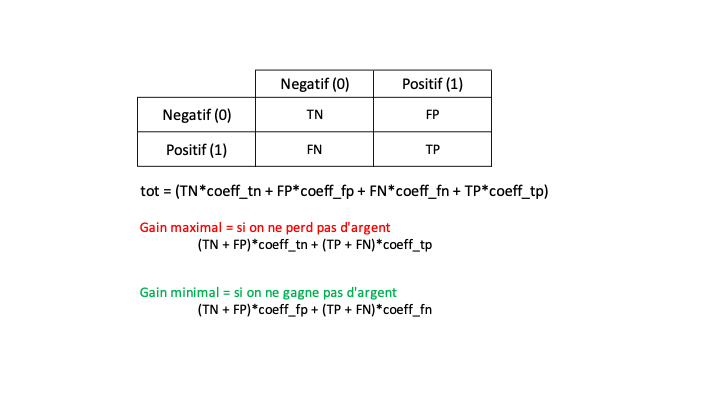

puis gain = (tot-gain_min) / (gain_max-gain_min)


Exemple de coefficients possibles en respectant la métrique métier :
* FN ==> perte d'argent pour la banque ==> -100 
* TP ==> refus de prêt ==> 0
* TN ==> prêt accordé, gain d'argent pour la banque ==> +10
* FP ==> client perdu, perte d'argent pour la banque ==> -1

In [16]:
from sklearn.metrics import fbeta_score as calcul_fbeta_score
import time
import mlflow
import mlflow.sklearn
import logging
logging.getLogger('mlflow').setLevel(logging.ERROR)

# os_path_join(OUT_FOLDER, 'mlflowruns')
mlflow.set_tracking_uri(f'{OUT_FOLDER}/mlflowruns')

time: 0 ns (started: 2023-10-28 20:11:15 +00:00)


In [17]:
def classification(best_param, X_train, y_train, X_test, y_test, algo_name, file_name=None):
    
    print(colored("Exécution en cours ....\n",'blue'))

    start_time = time.time()
    model = best_param.fit(X_train, y_train)
    end_time = time.time()
    execution_time = end_time - start_time

    if file_name is None:
        pass
    else :
        # save the model to disk
        filename = file_name
        pickle.dump(model, open(filename, 'wb'))

    start_time = time.time()
    prediction = best_param.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time

    #prediction de probabilité d'appartenance à 0 et 1
    probability = best_param.predict_proba(X_test)
    probability_positive = probability[:, 1]
    resume_prediction_class = pd.DataFrame(
        {'cat_reel': y_test, 'cat_predit': prediction}).reset_index()

    probability_positive_class = pd.DataFrame(
        {'SK_ID_CURR': X_test.index, 'positive_probability': probability_positive})
    
    # print(probability_positive_class)
    

    print(f"Qualité de la classification {algo_name} \n ")
    accuracy = accuracy_score(y_test, prediction)
    print("L'accuracy score est de      : {}".format(round(accuracy,5)))
    precision = precision_score(y_test, prediction, average='binary')  #binary car ici 0 ou 1 si plusieurs label c'est weighted
    print('Le score de précision est de : {}'.format(round(precision,5)))
    recall = recall_score(y_test, prediction, average='binary')
    print('Le score recall est de       : {}'.format(round(recall,5)))

    f1 = f1_score(y_test, prediction, average='binary')
    print('Le score f1 est de           : {}'.format(round(f1,5)))    
    AUC = roc_auc_score(y_test, probability[:,1]) # proba de na pas rembourser prêt donc d'être 1
    print('Le score AUC est de          : {}'.format(round(AUC,5)))
    fbeta_score = calcul_fbeta_score(y_test, prediction, beta=2)
    
    return model, accuracy, precision, recall, f1, AUC, fbeta_score, prediction, probability, \
            execution_time, prediction_time, resume_prediction_class, probability_positive_class

def matrix_TN_FN(y_test, y_prediction):
    
    """
    Cette fonction retourne une matrice de confusion.
    """
    
    # Création de la matrice de confusion.
    df_matrice_confusion = pd.DataFrame(columns=['Predicted Negative (0)','Predicted Positive (1)'], 
                                        index=['Real Negative (0)','Real Positive (1)'])

    # DataFrame de comparaison.
    df_pred_compare = pd.concat([pd.Series(y_test.reset_index(drop=True)), pd.Series(y_prediction)], axis=1)
    df_pred_compare.columns = ['Real category', 'Prediction']
    
    # Masque suivant les tp,tn, fp...
    mask_real_pos  = (df_pred_compare['Real category']==1)
    mask_pred_pos  = (df_pred_compare['Prediction']==1)

    mask_real_neg  = (df_pred_compare['Real category']==0)
    mask_pred_neg  = (df_pred_compare['Prediction']==0)
    
    # Négatif.
    true_negative  = df_pred_compare[mask_real_neg & mask_pred_neg].shape[0]
    false_negative = df_pred_compare[mask_real_pos & mask_pred_neg].shape[0]

    # Positif.
    false_positive = df_pred_compare[mask_real_neg & mask_pred_pos].shape[0]
    true_positive  = df_pred_compare[mask_real_pos & mask_pred_pos].shape[0]

    # Remplissage de la matrice.
    df_matrice_confusion['Predicted Negative (0)'] = ["{} (TN)".format(true_negative), "{} (FN)".format(false_negative)]
    df_matrice_confusion['Predicted Positive (1)'] = ["{} (FP)".format(false_positive), "{} (TP)".format(true_positive)]

    
    return df_matrice_confusion

from sklearn.metrics import roc_curve, roc_auc_score

def cf_matrix_roc_auc(y_true, y_pred, y_pred_proba, size):
    '''This function will make a pretty plot of 
     an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''

    fig               = plt.figure(figsize=size)
    ax1               = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')
     
    cf_matrix         = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp    = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    group_names       = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts      = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='RdPu')
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, 
                    top = False, labeltop=True)

    AUC         = roc_auc_score(y_true, y_pred_proba[:,1])
    #plt.subplot(222)
    ax2         = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:,1])  # pour la courbe ROC utilisation de la probabiilité d'être 1
    plt.plot(fpr, tpr, color = 'pink', linewidth=5, label = 'AUC = {:.4f}'.format(AUC))
    plt.plot([0, 1], [0, 1], color = 'darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
 
    print('True negative   = ', tn)
    print('False positive  = ', fp)
    print('False negative  = ', fn)
    print('True positive   = ', tp)

    return tn, fp, fn, tp

time: 0 ns (started: 2023-10-28 20:11:16 +00:00)


In [19]:
coeff_tn = 10
coeff_fp = -1
coeff_fn = -100
coeff_tp = 0

def fonction_metier(y_true, y_pred):
    '''Créer un score métier à partir de la matrice de confusion.
    :param: y_true (vraies valeurs), y_pred (valeurs prédites par le modèle)
    :return: gain (score métier)
    '''
    TP_coeff = 0       # Vrais positifs
    FP_coeff = -1       # Faux positifs (prédit comme faisant défaut (1) mais ne fait pas défaut (0))
    FN_coeff = -100     # Faux négatifs (prédit comme ne faisant pas défaut (0) mais font défaut (1))
    TN_coeff = 10       # Vrais négatifs
    
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()
    
    gain = (TP*TP_coeff + TN*TN_coeff + FP*FP_coeff + FN*FN_coeff)/(TN+FP+FN+TP)
    
    return gain

def score_banq(tn, fp, fn, tp, coeff_tn, coeff_fp, coeff_fn, coeff_tp):

    total    = (coeff_tn*tn + coeff_fp*fp + coeff_fn*fn + coeff_tp*tp)
    #calcul du gain maximal que peut avoir la banque quand il n'y a pas de perte d'argent. C'est à dire que le modèle ne détecte que TN et les TP.
    max_gain = (tn + fp)*coeff_tn + (tp + fn)*coeff_tp
    #calcul du gain minimal (perte) que peut avoir la banque quand il n'y a pas de gain d'argent. C'est à dire que le modèle ne détecte que FN et les FP.
    min_gain = (tn + fp)*coeff_fp + (tp + fn)*coeff_fn
    #normalisation min-max feature scalling : score= (tot-min)/(max-min) https://en.wikipedia.org/wiki/Normalization_(statistics) 
    score    = (total - min_gain)/(max_gain - min_gain)

    return score

def score_metier_max(y_pred_proba, y_true, verbose=True):
    '''Créer un graphique permettant de déterminer quel peut être le score max en fonction du threshold.
    :param: y_pred_proba (probabilités prédites par le modèle), y_true (vraies valeurs),
    verbose (affiche le graphe ou juste le score maximal)
    :return: graphique, 
    '''
    scores = []
    for threshold in np.linspace(0, 1, num=101):
        y_pred = np.where(y_pred_proba > threshold, 1, 0)
        score  = fonction_metier(y_true, y_pred)
        scores.append(score)

    if verbose == True:
        score_max = max(scores)
        opti_threshold = np.linspace(0, 1, num=101)[scores.index(score_max)]
        y_pred = np.where(y_pred_proba > opti_threshold, 1, 0)
        
        print("Score métier maximum : {:.2f}".format(score_max))
        print("Threshold optimal    : {}".format(opti_threshold))
        
        fig, ax = plt.subplots(figsize=(6, 5))
        plt.plot(np.linspace(0, 1, num=101), scores, label="model score")
        plt.axvline(x=opti_threshold, color='k', dashes=(0.5, 1), 
                    label="optimal threshold: {}".format(opti_threshold))
        
        plt.title("Score métier en fonction du threshold", fontsize=10)
        plt.xlabel("Thresholds", fontsize=10)
        plt.ylabel("Score métier", fontsize=10)
        plt.legend()
        plt.show()
     
    else:
        return max(scores)

time: 0 ns (started: 2023-10-28 20:11:42 +00:00)


### Connexion MLFlow

-  MLflow permet de se connecter au serveur pour le suivi des expériences de machine learning.

- Serveur MLflow en local : Si vous utilisez le serveur MLflow en local, l'adresse est généralement http://127.0.0.1:5000/ par défaut. Cela signifie que le serveur MLflow est accessible sur votre ordinateur local (localhost) via le port 5000. Vous pouvez ouvrir votre navigateur et accéder à cette adresse pour voir l'interface utilisateur MLflow.

In [15]:
# Connexion en local
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

time: 0 ns (started: 2023-09-28 12:56:54 +00:00)


verifier si mlflow a demarré : 

on tape ceci dans anacondaprompt **mlflow server --host 127.0.0.1 --port 5000**

et on comme resultat: **INFO:waitress:Serving on http://127.0.0.1:5000**

In [20]:
mlflow.autolog(log_input_examples=True, silent=True)

time: 1.19 s (started: 2023-10-28 20:11:52 +00:00)


### Split des données

Avant d'encoder les variables catégoriques, et normaliser les variables, il faut diviser entre données d'entrainement et test, pour éviter 'data leakage' :

- Entrainement sur les données train
- Utilise les jeux de données test pour simuler des nouvelles observations (donc aucun partage de connaissance entre données train et test)

Pour division entre données d'entrainement et test, on a plusieurs stratégies :

- une division aléatoire (ex 80% entrainement, 20% test) : Mais on risque de mettre beaucoup de créer de bias dans le jeu d'entrainement si il n'est pas répresentatif des classes à prédire

- stratification : Essayer de garantie que le jeu de données d'entrainement ont le même distribution de classes cibles

#### Références

- <https://scikit-learn.org/stable/common_pitfalls.html#data-leakage>
- <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html>

In [21]:
# def create_X_y(df: pd.DataFrame):
#     df = df.set_index('SK_ID_CURR')
#     target = df['TARGET'].copy()
#     fields = df.drop(columns=['TARGET'])
#     return fields, target


# X, y = create_X_y(train_df)
# print(X.shape)
# print(y.shape)

time: 0 ns (started: 2023-10-28 20:12:01 +00:00)


In [22]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

TARGET
0    0.91927
1    0.08073
Name: proportion, dtype: float64
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
time: 16 ms (started: 2023-10-28 20:12:01 +00:00)


In [23]:
from sklearn.compose import make_column_selector

cat_selector       = make_column_selector(dtype_include=object)
num_selector       = make_column_selector(dtype_include=np.number)
bool_selector      = make_column_selector(dtype_include=bool)

category_features  = cat_selector(X_train)
numerical_features = num_selector(X_train)
bool_features      = bool_selector(X_train)
target_features    = y_train.name

print(f'numerical_features : {len(numerical_features)}')
print(f'category_features  : {len(category_features)}')
print(f'bool_features      : {len(bool_features)}')
print(f'target_features    : {target_features}')


numerical_features : 90
category_features  : 0
bool_features      : 10
target_features    : TARGET
time: 15 ms (started: 2023-10-28 20:12:07 +00:00)


In [24]:
X_train.dtypes.value_counts()

float64    82
bool       10
int64       8
Name: count, dtype: int64

time: 16 ms (started: 2023-10-28 20:12:08 +00:00)


## Normalisation des données

In [25]:
X_train.dtypes.value_counts()

float64    82
bool       10
int64       8
Name: count, dtype: int64

time: 16 ms (started: 2023-10-28 20:12:10 +00:00)


In [26]:
X_train.select_dtypes(include=int)

CODE_GENDER  REG_CITY_NOT_LIVE_CITY  REGION_RATING_CLIENT_W_CITY  \
SK_ID_CURR                                                                     
326316                0                       0                            2   
158869                0                       0                            3   
358982                1                       0                            2   
455697                0                       0                            1   
276249                1                       0                            2   
...                 ...                     ...                          ...   
248136                1                       0                            2   
331135                1                       0                            2   
216408                0                       0                            1   
226583                1                       0                            3   
332242                1                       0                            3   

            FLAG_DOCUMENT_3  FLAG_EMP_PHONE  REG_REGION_NOT_LIVE_REGION  \
SK_ID_CURR                                                                
326316                    1               1                           0   
158869                    0               1                           0   
358982                    1               0                           0   
455697                    0               1                           0   
276249                    1               1                           0   
...                     ...             ...                         ...   
248136                    1               1                           0   
331135                    0               1                           0   
216408                    0               1                           0   
226583                    1               1                           0   
332242                    0               1                           0   

            REG_CITY_NOT_WORK_CITY  REGION_RATING_CLIENT  
SK_ID_CURR                                                
326316                           1                     2  
158869                           1                     3  
358982                           0                     2  
455697                           0                     1  
276249                           0                     2  
...                            ...                   ...  
248136                           0                     2  
331135                           0                     2  
216408                           1                     1  
226583                           0                     3  
332242                           0                     3  

[246005 rows x 8 columns]

time: 32 ms (started: 2023-10-28 20:12:11 +00:00)


In [27]:
cols                 = X_train.select_dtypes(['float64']).columns
X_train_scaled       = X_train.copy()
X_test_scaled        = X_test.copy()
scaler               = StandardScaler()

scaler.fit(X_train_scaled[cols])

X_train_scaled[cols] = scaler.transform(X_train_scaled[cols])
X_test_scaled[cols]  = scaler.transform(X_test_scaled[cols])

time: 781 ms (started: 2023-10-28 20:12:17 +00:00)


### Cross validation

In [28]:
def model_best_params(model, param_grid, score, ModelName, run_name, X_train, y_train, X_test, y_test):
    classifier_grid        = GridSearchCV(model, param_grid, 
                                          scoring = score, 
                                          cv = 4, n_jobs = -1, verbose = 1)  
    classifier_grid.fit(X_train, y_train)

    params_name            = f'best_params_{model.__class__.__name__}'
    globals()[params_name] = classifier_grid.best_params_

    print("  ")
    print("Nom du modèle         :", ModelName)
    print("best params name      :", params_name)
    print("best params values    :", globals()[params_name])
    print(f"Score {score} Train  :", classifier_grid.best_score_)
    
    # Injectez les meilleurs paramètres dans le modèle
    model.set_params(**globals()[params_name])

    # Sauvegarde du modèle
    with open(f'{MODEL_FOLDER}/{ModelName}.pkl', 'wb') as model_file:
        pickle.dump(model, model_file)
    
    #  MLFLOW
    # model_mlflow(model, ModelName, run_name, X_train, y_train, X_test, y_test)
        
    return model, globals()[params_name]

time: 0 ns (started: 2023-10-28 20:12:19 +00:00)


In [29]:
# # Fixer les valeurs des hyperparamètres à tester
# param_grid = {"C"    :[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 20],
#              'solver': ['lbfgs', 'liblinear']}     
# model      = LogisticRegression(random_state=RANDOM_STATE)
# ModelName  = f'Baseline_{model.__class__.__name__}'
# score = 'roc_auc'

# globals()[ModelName], globals()[f'best_params_{model.__class__.__name__}'] = \
# model_best_params(model, param_grid, score, X_train_scaled, y_train)

time: 0 ns (started: 2023-10-28 20:12:20 +00:00)


In [30]:
# # Fixer les valeurs des hyperparamètres à tester
# param_grid = {'n_estimators'      : np.arange(0, 1000, 100),  # nombre d'arbres de décision
#               'max_depth'         : np.arange(0, 50, 5), # nombre maximum de niveaux dans chaque arbre de décision 
#               'min_samples_leaf'  : np.arange(1, 20, 2),   # nombre minimal d'observation pour créer une feuille
#               'min_samples_split' : np.arange(1, 20, 2)} # nombre minimal d'observation avant séparation du noeud        
  
# model      = RandomForestClassifier(random_state = RANDOM_STATE)
# ModelName  = f'Baseline_{model.__class__.__name__}'

# globals()[ModelName], globals()[f'best_params_{model.__class__.__name__}'] = \
# model_best_params(model, param_grid, score, X_train_scaled, y_train)

time: 0 ns (started: 2023-10-28 20:12:20 +00:00)


In [31]:
# # Fixer les valeurs des hyperparamètres à tester
# param_grid = {'n_estimators' : np.arange(0, 500, 100),  #nombre d'arbres de décision #(10,100,10). [100, 500, 1000, 1500, 2000]
#               'max_depth'    : np.arange(0, 50, 10)} #nombre maximum de niveaux dans chaque arbre de décision    
# model      = XGBClassifier(objective= 'binary:logistic', random_state = RANDOM_STATE)
# ModelName  = f'Baseline_{model.__class__.__name__}'

# globals()[ModelName], globals()[f'best_params_{model.__class__.__name__}'] = \
# model_best_params(model, param_grid, score, X_train_scaled, y_train)

time: 0 ns (started: 2023-10-28 20:12:21 +00:00)


In [32]:
# # Fixer les valeurs des hyperparamètres à tester
# param_grid = {
#         'n_estimators'  : np.arange(500, 1500, 100),
#         'learning_rate' : [1, 0.1, 0.01, 0.001]
#         }
# model      = LGBMClassifier(objective='binary', random_state = RANDOM_STATE)
# ModelName  = f'Baseline_{model.__class__.__name__}'

# globals()[f'best_params_{model.__class__.__name__}'] = \
# model_best_params(model, param_grid, score, X_train_scaled, y_train)

time: 0 ns (started: 2023-10-28 20:12:21 +00:00)


In [33]:
# best_params = LogisticRegression(**globals()[f'best_params_{model.__class__.__name__}'], random_state=42)

time: 0 ns (started: 2023-10-28 20:12:22 +00:00)


In [34]:
# model, accuracy, precision, recall, f1, AUC, fbeta_score, prediction, probability, execution_time, \
# prediction_time, resume_prediction_class, probability_positive_class = \
# classification(best_params, X_train_scaled, y_train, X_test_scaled, y_test, 
#                "Baseline - Regression logistique", file_name=None)


time: 0 ns (started: 2023-10-28 20:12:23 +00:00)


In [35]:
# tn, fp, fn, tp  = cf_matrix_roc_auc(y_test, prediction, probability, (15, 10))
# score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
# score_gain

time: 0 ns (started: 2023-10-28 20:12:23 +00:00)


In [36]:
# df_matrice_confusion = matrix_TN_FN(y_test, prediction)
# df_matrice_confusion

time: 0 ns (started: 2023-10-28 20:12:23 +00:00)


In [37]:
# roc_auc = roc_auc_score(y_test, probability[:,1])  # on se base sur la probabilité d'être en défaut de paiement
# print('AUC : %0.4f' %roc_auc)
# print(classification_report(y_test, prediction))

time: 0 ns (started: 2023-10-28 20:12:24 +00:00)


In [38]:
# Sample_balancing = []

# def results():
#     res=pd.DataFrame(
#             {
#              "Modele": ModelName,
#              "Accuracy": accuracy,
#              "AUC": AUC,
#              "Recall class 1": recall,
#              "F1":f1,
#              "fbeta": fbeta_score,
#              "TP":tp,
#              "Precision":precision,
#              "FN":fn,
#              "score Gain":score_gain,
#              # "prediction": prediction,
#              #  "probability": probability,
#              "time": prediction_time
#             },
#             index=[len(Sample_balancing)],
#         )
#     Sample_balancing.append(res)
#     return res


time: 0 ns (started: 2023-10-28 20:12:24 +00:00)


In [39]:
# ModelName='baseline'
# results()

time: 0 ns (started: 2023-10-28 20:12:24 +00:00)


In [40]:
import mlflow.pyfunc
import mlflow.pyfunc.model
import mlflow.tracking

def delete_mlflow_model(model_name):
    # Créez une instance du suivi MLflow
    tracking_uri = "http://127.0.0.1:5000/"  # Remplacez par l'URL de votre serveur MLflow
    mlflow.set_tracking_uri(tracking_uri)
    client = mlflow.tracking.MlflowClient()

    # Récupérez la liste des modèles
    models = client.search_registered_models(f"name='{model_name}'")

    # Si un modèle avec le même nom existe, supprimez-le
    if len(models) > 0:
        model_version = models[0].latest_versions[0].version
        client.delete_registered_model(model_name)
        print(f"Modèle {model_name} version {model_version} supprimé avec succès.")
    else:
        print(f"Aucun modèle avec le nom {model_name} trouvé.")

# Utilisation
# delete_mlflow_model(ModelName)


time: 15 ms (started: 2023-10-28 20:12:25 +00:00)


### Techniques d'équilibrage des classes

[Plusieurs méthodes](https://publications.polymtl.ca/5349/1/2020_GuillaumeVergnolle.pdf) sont envisagées pour équilibrer les classes dans l'ensemble d'entraînement.
Elles se distinguent en deux catégories : les méthodes de **sur-échantillonnage** et de **souséchantillonnage**.

<h4> Stratégies de sur-échantillonnage </h4>
    
**SMOTE** est une des méthodes de sur-échantillonnage utilisée. En créant des observations synthétiques, on est capable de balancer les classes jusqu'à un rapport de 1. On utilisera la fonction **SMOTE** de la librairie imblearn, dont le paramètre `sampling_strategy` permet de déterminer la proportion cible entre la classe **positive** et **négative**. Les mêmes paramètres sont disponibles pour la méthode de sur-échantillonnage aléatoire avec la fonction
`RandomOverSampler` de la même librairie.
    
<h4> Stratégies de sous-échantillonnage</h4>

Pour le sous-échantillonnage aléatoire, on utilisera la fonction `RandomUnderSampler`. Cette
fonction partage aussi le paramètre `sampling_strategy` qui permet de déterminer l'équilibre
des classes désiré. Le sous-échantillonnage avec liens Tomek et la méthode Edited Nearest Neighbors sont disponibles avec les fonctions `TomekLinks` et `EditedNearestNeighbours` respectivement. Ces méthodes ne permettent pas d'atteindre une proportion de classe cible mais suppriment des instances avec des considérations de distance.

<h4> Combinaisons de stratégies de ré-échantillonnage </h4>
Certaines méthodes de sur-échantillonnage et de sous-échantillonnage peuvent être combinées afin de déterminer la meilleure stratégie. 

    — Ensemble de base non-équilibré (BASE)
    — Random Over-Sampling (ROS)
    — Random Under-Sampling (RUS)
    — SMOTE (SMT)
    — SMOTE + Liens Tomek (SMT+TMK)
    — SMOTE + Edited Nearest Neighbors (SMT+ENN)

Afin de déterminer la valeur optimale du paramètre `sampling_strategy` des méthodes `Random Under-Sampling`, `Random Over-Sampling` et `SMOTE`, différentes valeurs sont testées pour chaque compagnie et chaque découpage sur un modèle de base. La valeur du paramètre qui donne les meilleures performances est conservée pour chaque découpage et chaque compagnie.

## <a id="5.4.1"> Aucun rééquilibrage </a>

In [37]:
mlflow.set_experiment('Baseline-models')

<Experiment: artifact_location='mlflow-artifacts:/976256387780739693', creation_time=1695334942254, experiment_id='976256387780739693', last_update_time=1695334942254, lifecycle_stage='active', name='Baseline-models', tags={}>

time: 78 ms (started: 2023-09-28 13:00:26 +00:00)


In [26]:
# !ls

time: 0 ns (started: 2023-09-21 22:22:23 +00:00)


In [41]:
# Aucun rééquilibrage 
import mlflow.sklearn

def model_mlflow(classifier_model, ModelName, run_name, X_train, y_train, X_test, y_test):
    
    with mlflow.start_run(run_name=run_name):
        # Classifier
        classifier_model.fit(X_train, y_train)

        # Classification
        model, accuracy, precision, recall, f1, AUC, fbeta_score, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class =\
        classification(classifier_model, X_train, y_train, X_test, y_test, ModelName, file_name=None)

        # Matrice de confusion
        df_matrice_confusion = matrix_TN_FN(y_test, prediction)
        display(df_matrice_confusion)

        # Courbe ROC
        tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (15,10))

        score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)

        roc_auc = roc_auc_score(y_test, probability[:,1])  # on se base sur la probabilité d'être en défaut de paiement
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(y_test, prediction))

        mlflow.log_metric("test_score_métier", round(score_gain, 4))
        mlflow.log_metric("test_accuracy",round(accuracy, 4))
        mlflow.log_metric("test_precision", round(precision, 4))
        mlflow.log_metric("test_recall", round(recall, 4))
        mlflow.log_metric("test_f1_score", round(f1, 4))
        mlflow.log_metric("test_fbeta_score", round(fbeta_score, 4))
        mlflow.log_metric("test_rocauc", round(AUC, 4))

        # Supprimer le modèle existant s'il existe
        # Recherchez les exécutions précédentes avec le nom de modèle spécifié
        # runs = mlflow.search_runs(filter_string=f"tags.mlflow.runName = '{ModelName}'")
        # if not runs.empty:
        #     mlflow.sklearn.delete_model(runs.iloc[0].artifact_uri)

        # Enregistrez le modèle
        # mlflow.sklearn.save_model(model, ModelName)
        # Terminez l'expérience MLflow
        mlflow.end_run()
        return  model, accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
        prediction, probability, execution_time, prediction_time

time: 16 ms (started: 2023-10-28 20:12:44 +00:00)


In [39]:
Sample_balancing = []

def results():
    res = pd.DataFrame(
        {
            "Modele": [ModelName],
            "Accuracy": [accuracy],
            "AUC": [AUC],
            "Recall class 1": [recall],
            "F1": [f1],
            "fbeta": [fbeta_score],
            "TP": [tp],
            "Precision": [precision],
            "FN": [fn],
            "score Gain": [score_gain],
            # "prediction": [prediction],
            # "probability": [probability],
            "train_time": [execution_time],
            "predict_time": [prediction_time],
        }
    )
    Sample_balancing.append(res)
    return res

time: 0 ns (started: 2023-09-28 13:00:59 +00:00)


#### <font color='grey'>Régression logistique</font>

Exécution en cours ....

Qualité de la classification Baseline_LogisticRegression 
 
L'accuracy score est de      : 0.91938
Le score de précision est de : 0.52047
Le score recall est de       : 0.01793
Le score f1 est de           : 0.03466
Le score AUC est de          : 0.75218


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             56455 (TN)                82 (FP)
Real Positive (1)              4876 (FN)                89 (TP)

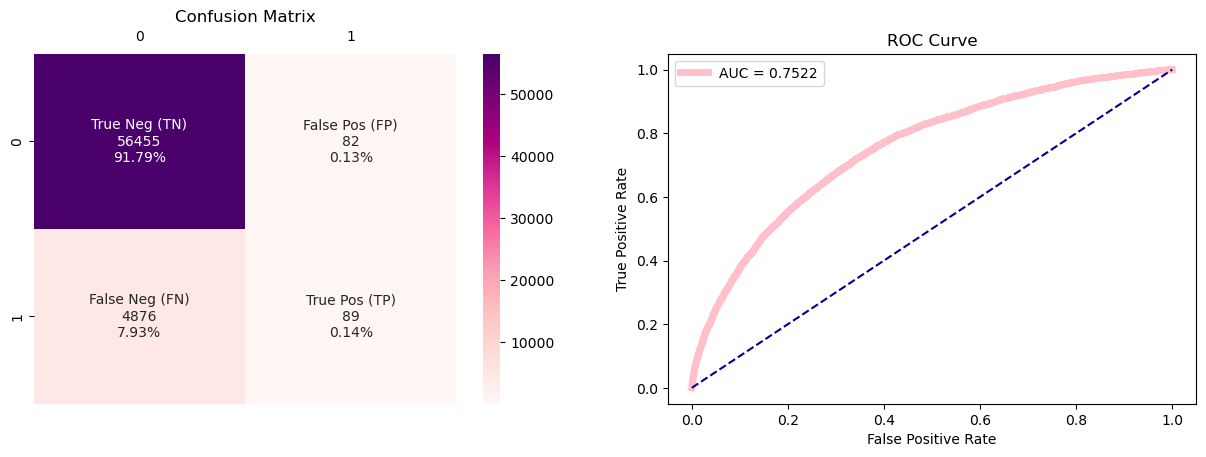

True negative   =  56455
False positive  =  82
False negative  =  4876
True positive   =  89
AUC : 0.7522
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.52      0.02      0.03      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502

time: 49.5 s (started: 2023-09-28 13:01:07 +00:00)


In [40]:
classifier_model = LogisticRegression(max_iter=1500, random_state=RANDOM_STATE)
ModelName        = f'Baseline_{classifier_model.__class__.__name__}'
run_name         = f'Baseline_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train_scaled, y_train, X_test_scaled, y_test)

In [41]:
results()

Modele  Accuracy      AUC  Recall class 1        F1  \
0  Baseline_LogisticRegression  0.919385  0.75218        0.017925  0.034657   

      fbeta  TP  Precision    FN  score Gain  train_time  predict_time  
0  0.022216  89   0.520468  4876    0.563216   20.256721      1.077921

time: 0 ns (started: 2023-09-28 13:01:57 +00:00)


#### <font color='grey'>Random Forest</font>

Exécution en cours ....

Qualité de la classification Baseline_RandomForestClassifier 
 
L'accuracy score est de      : 0.91945
Le score de précision est de : 0.72
Le score recall est de       : 0.00363
Le score f1 est de           : 0.00721
Le score AUC est de          : 0.7116725563654713


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             56530 (TN)                 7 (FP)
Real Positive (1)              4947 (FN)                18 (TP)

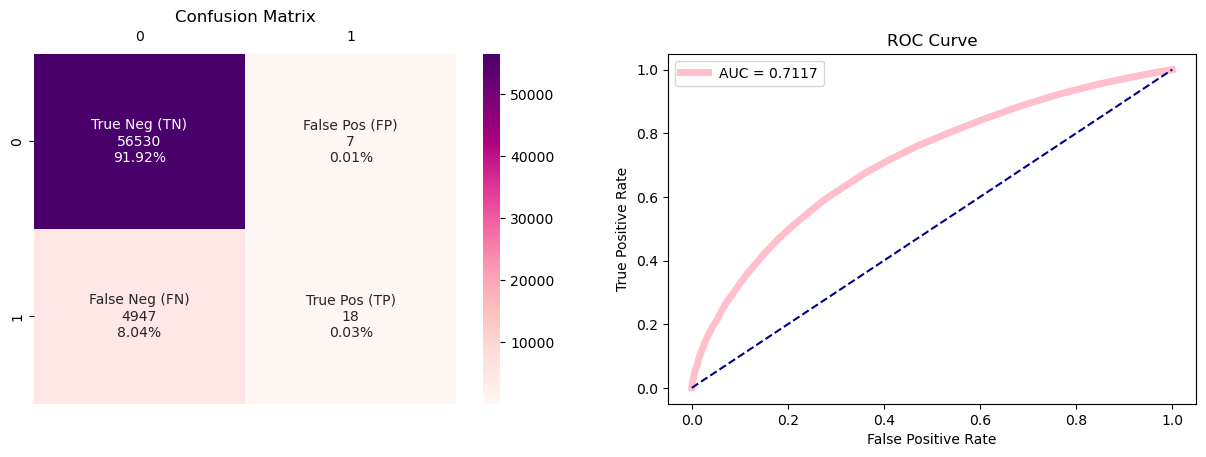

True negative   =  56530
False positive  =  7
False negative  =  4947
True positive   =  18
AUC : 0.7117
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.72      0.00      0.01      4965

    accuracy                           0.92     61502
   macro avg       0.82      0.50      0.48     61502
weighted avg       0.90      0.92      0.88     61502



Modele  Accuracy       AUC  Recall class 1  \
0  Baseline_RandomForestClassifier   0.91945  0.711673        0.003625   

         F1     fbeta  TP  Precision    FN  score Gain  train_time  \
0  0.007214  0.004526  18       0.72  4947    0.557606  797.193539   

   predict_time  
0      5.725014

time: 26min 7s (started: 2023-09-21 22:23:37 +00:00)


In [31]:
classifier_model = RandomForestClassifier(random_state = RANDOM_STATE)
ModelName        = f'Baseline_{classifier_model.__class__.__name__}'
run_name         = f'Baseline_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train_scaled, y_train, X_test_scaled, y_test)
results()

#### <font color='grey'>DecisionTreeClassifier </font>

Exécution en cours ....

Qualité de la classification Baseline_DecisionTreeClassifier 
 
L'accuracy score est de      : 0.85259
Le score de précision est de : 0.14407
Le score recall est de       : 0.16717
Le score f1 est de           : 0.15476
Le score AUC est de          : 0.5399764853790817


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             51606 (TN)              4931 (FP)
Real Positive (1)              4135 (FN)               830 (TP)

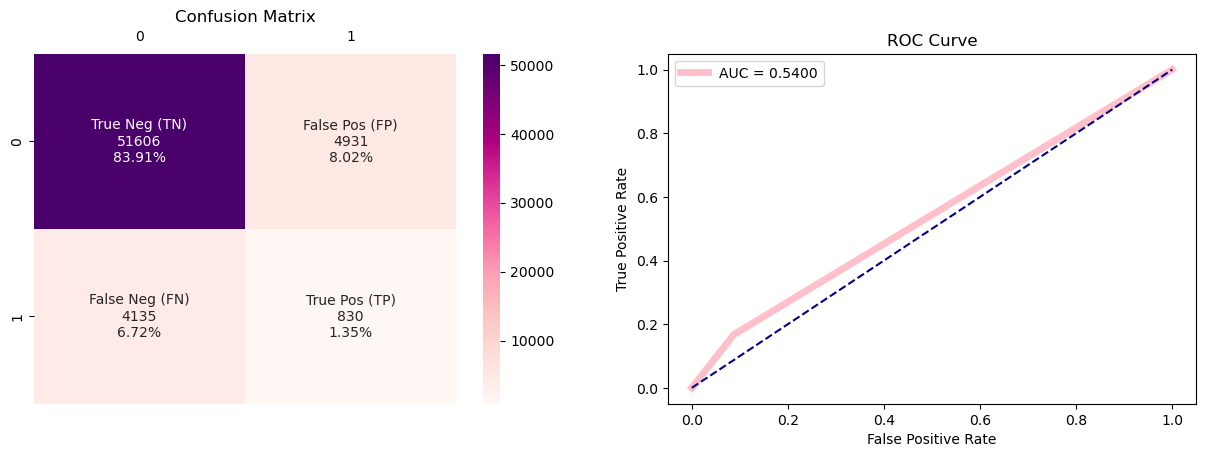

True negative   =  51606
False positive  =  4931
False negative  =  4135
True positive   =  830
AUC : 0.5400
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     56537
           1       0.14      0.17      0.15      4965

    accuracy                           0.85     61502
   macro avg       0.53      0.54      0.54     61502
weighted avg       0.86      0.85      0.86     61502



Modele  Accuracy       AUC  Recall class 1  \
0  Baseline_DecisionTreeClassifier   0.85259  0.539976         0.16717   

         F1     fbeta   TP  Precision    FN  score Gain  train_time  \
0  0.154764  0.161977  830   0.144072  4135    0.581779  104.036886   

   predict_time  
0      1.277169

time: 3min 30s (started: 2023-09-22 08:24:30 +00:00)


In [62]:
classifier_model = DecisionTreeClassifier(random_state = RANDOM_STATE)
ModelName        = f'Baseline_{classifier_model.__class__.__name__}'
run_name         = f'Baseline_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train_scaled, y_train, X_test_scaled, y_test)
results()


#### <font color='grey'>XGBClassifier</font>

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Exécution en cours ....



is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Qualité de la classification Baseline_XGBClassifier 
 
L'accuracy score est de      : 0.91888
Le score de précision est de : 0.47309
Le score recall est de       : 0.0425
Le score f1 est de           : 0.07799
Le score AUC est de          : 0.7611521715382101


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             56302 (TN)               235 (FP)
Real Positive (1)              4754 (FN)               211 (TP)

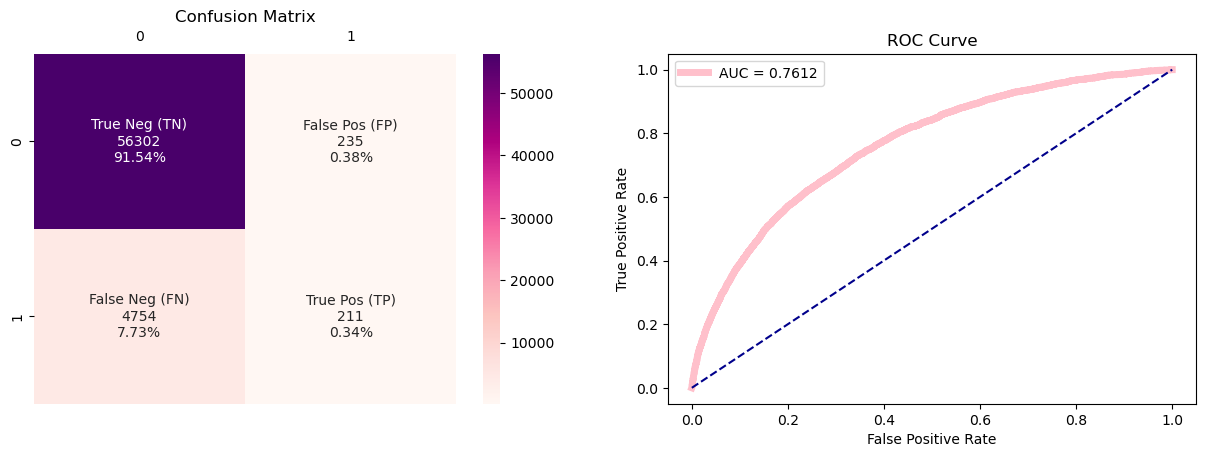

True negative   =  56302
False positive  =  235
False negative  =  4754
True positive   =  211
AUC : 0.7612
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.47      0.04      0.08      4965

    accuracy                           0.92     61502
   macro avg       0.70      0.52      0.52     61502
weighted avg       0.89      0.92      0.89     61502



Modele  Accuracy       AUC  Recall class 1        F1  \
0  Baseline_XGBClassifier  0.918881  0.761152        0.042497  0.077989   

      fbeta   TP  Precision    FN  score Gain  train_time  predict_time  
0  0.051955  211   0.473094  4754     0.57262   44.395665      1.369597

time: 1min 37s (started: 2023-09-22 05:23:48 +00:00)


In [33]:
classifier_model = XGBClassifier(objective = 'binary:logistic', random_state = RANDOM_STATE)
ModelName        = f'Baseline_{classifier_model.__class__.__name__}'
run_name         = f'Baseline_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train_scaled, y_train, X_test_scaled, y_test)
results()

#### <font color='grey'>LGBMClassifier</font>

Exécution en cours ....

Qualité de la classification Baseline_LGBMClassifier 
 
L'accuracy score est de      : 0.91961
Le score de précision est de : 0.54884
Le score recall est de       : 0.02377
Le score f1 est de           : 0.04556
Le score AUC est de          : 0.7684731158685999


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             56440 (TN)                97 (FP)
Real Positive (1)              4847 (FN)               118 (TP)

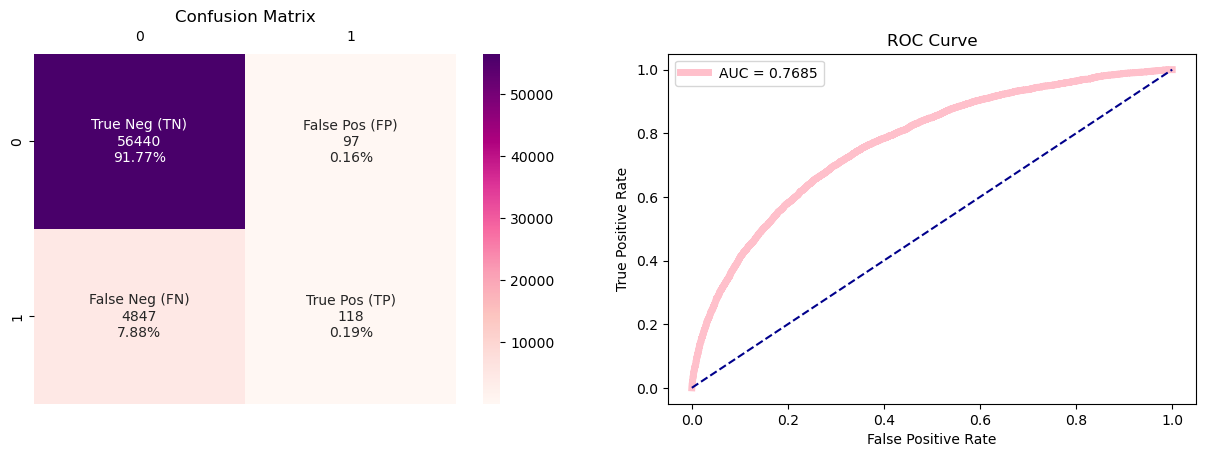

True negative   =  56440
False positive  =  97
False negative  =  4847
True positive   =  118
AUC : 0.7685
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.55      0.02      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.73      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502



Modele  Accuracy       AUC  Recall class 1       F1  \
0  Baseline_LGBMClassifier  0.919612  0.768473        0.023766  0.04556   

     fbeta   TP  Precision    FN  score Gain  train_time  predict_time  
0  0.02939  118   0.548837  4847    0.565662   14.078109      1.436847

time: 32 s (started: 2023-09-22 08:32:04 +00:00)


In [64]:
classifier_model = LGBMClassifier(objective='binary', random_state = RANDOM_STATE)
ModelName        = f'Baseline_{classifier_model.__class__.__name__}'
run_name         = f'Baseline_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train_scaled, y_train, X_test_scaled, y_test)
results()

## <a id="5.4.2"> Rééquilibrage avec class_weight</a>


La méthode des *class weight* permet de prendre en compte le caractère biaisé de la distribution du dataset et de créer un modèle pénalisé. Il s'agit ici de simplement attribuer des poids différents aux différentes classes de notre dataset, en donnant un poids plus important aux classes minoritaires, afin d'influencer le modèle lors de son entraînement. Nous pénalisons ainsi plus fortement une erreur de classification d'une classe minoritaire par rapport à une erreur de classification d'une classe majoritaire.

#### <font color='grey'>Régression logistique</font>

Exécution en cours ....

Qualité de la classification Class_Weight_LogisticRegression 
 
L'accuracy score est de      : 0.69359
Le score de précision est de : 0.1635
Le score recall est de       : 0.67915
Le score f1 est de           : 0.26355
Le score AUC est de          : 0.7520951558587741


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             39285 (TN)             17252 (FP)
Real Positive (1)              1593 (FN)              3372 (TP)

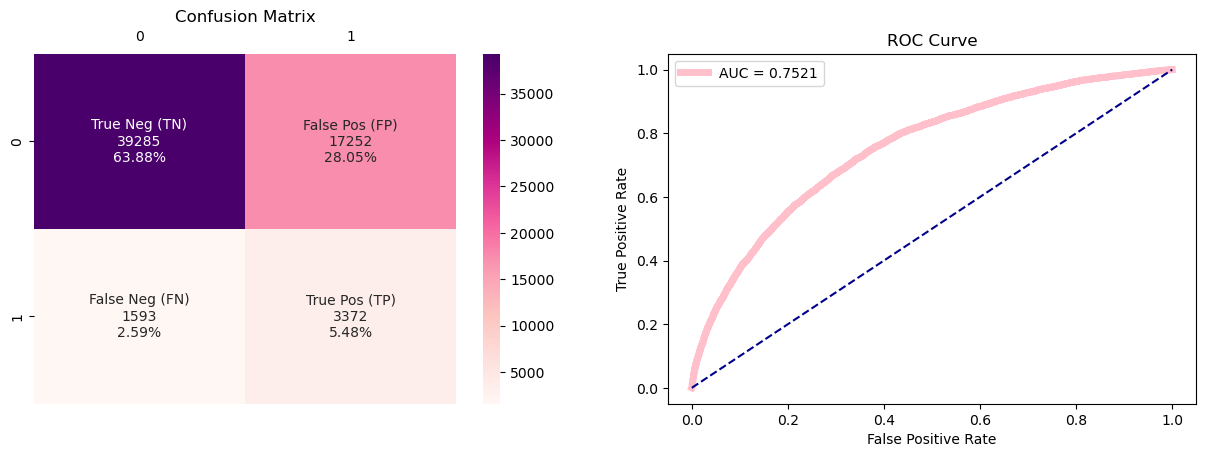

True negative   =  39285
False positive  =  17252
False negative  =  1593
True positive   =  3372
AUC : 0.7521
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56537
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.69      0.76     61502



Modele  Accuracy       AUC  Recall class 1  \
0  Class_Weight_LogisticRegression  0.693587  0.752095        0.679154   

         F1     fbeta    TP  Precision    FN  score Gain  train_time  \
0  0.263551  0.416461  3372   0.163499  1593    0.687885   30.918692   

   predict_time  
0      1.194009

time: 1min 4s (started: 2023-09-22 05:25:26 +00:00)


In [34]:
classifier_model = LogisticRegression(max_iter=1500, class_weight='balanced', random_state=RANDOM_STATE)
ModelName        = f'Class_Weight_{classifier_model.__class__.__name__}'
run_name         = f'Class_Weight_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train_scaled, y_train, X_test_scaled, y_test)
results()

#### <font color='grey'>Random Forest</font>

Exécution en cours ....

Qualité de la classification Class_Weight_RandomForestClassifier 
 
L'accuracy score est de      : 0.91912
Le score de précision est de : 0.26316
Le score recall est de       : 0.00101
Le score f1 est de           : 0.00201
Le score AUC est de          : 0.721860373553196


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             56523 (TN)                14 (FP)
Real Positive (1)              4960 (FN)                 5 (TP)

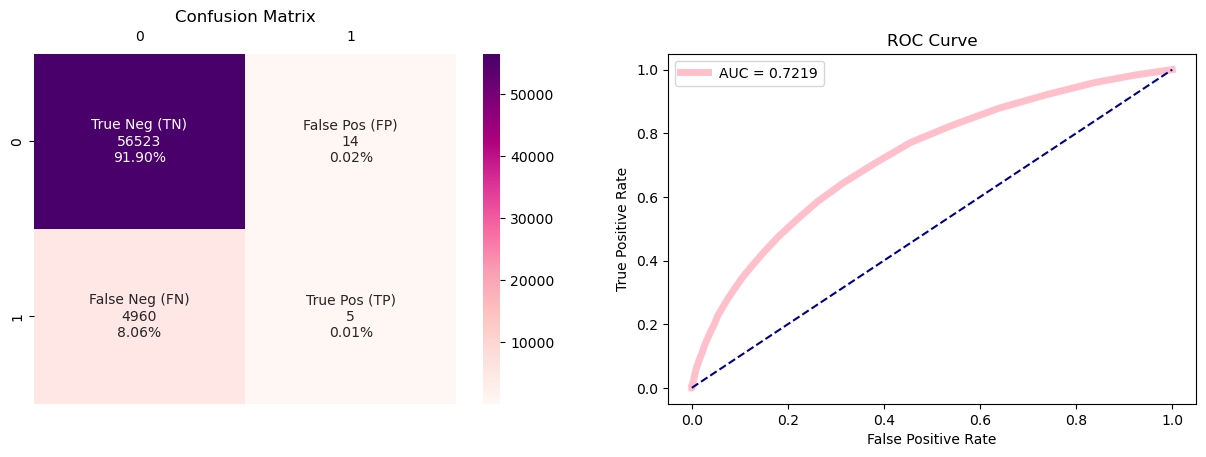

True negative   =  56523
False positive  =  14
False negative  =  4960
True positive   =  5
AUC : 0.7219
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.26      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.59      0.50      0.48     61502
weighted avg       0.87      0.92      0.88     61502



Modele  Accuracy      AUC  Recall class 1  \
0  Class_Weight_RandomForestClassifier  0.919125  0.72186        0.001007   

         F1     fbeta  TP  Precision    FN  score Gain  train_time  \
0  0.002006  0.001258   5   0.263158  4960    0.556374   521.65939   

   predict_time  
0      2.919039

time: 18min (started: 2023-09-22 05:26:30 +00:00)


In [35]:
classifier_model = RandomForestClassifier(class_weight='balanced', random_state = RANDOM_STATE)
ModelName        = f'Class_Weight_{classifier_model.__class__.__name__}'
run_name         = f'Class_Weight_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train_scaled, y_train, X_test_scaled, y_test)
results()

#### <font color='grey'>DecisionTreeClassifier </font>

Exécution en cours ....

Qualité de la classification Class_Weight_DecisionTreeClassifier 
 
L'accuracy score est de      : 0.86005
Le score de précision est de : 0.13898
Le score recall est de       : 0.14119
Le score f1 est de           : 0.14007
Le score AUC est de          : 0.5321856832484342


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             52194 (TN)              4343 (FP)
Real Positive (1)              4264 (FN)               701 (TP)

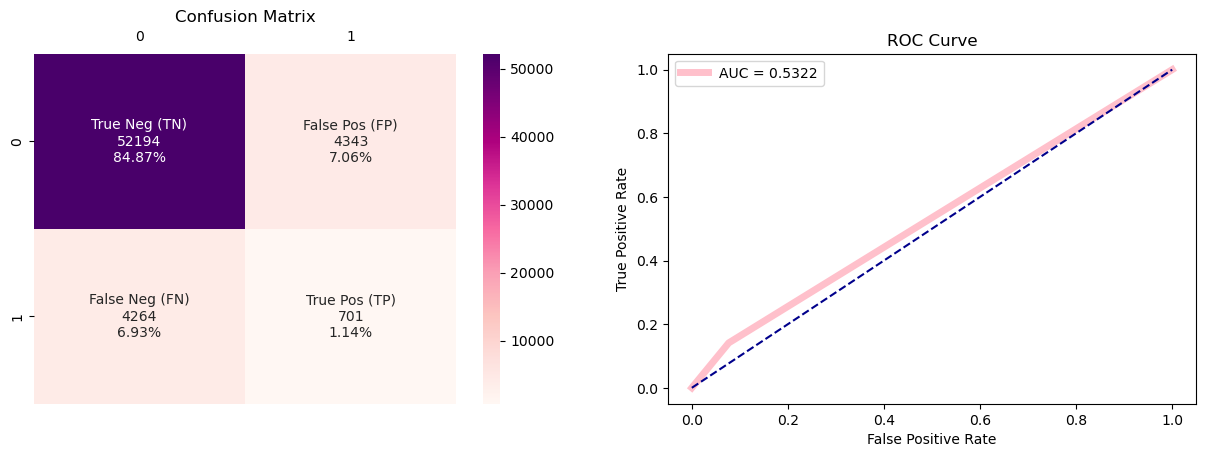

True negative   =  52194
False positive  =  4343
False negative  =  4264
True positive   =  701
AUC : 0.5322
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56537
           1       0.14      0.14      0.14      4965

    accuracy                           0.86     61502
   macro avg       0.53      0.53      0.53     61502
weighted avg       0.86      0.86      0.86     61502



Modele  Accuracy       AUC  Recall class 1  \
0  Class_Weight_DecisionTreeClassifier  0.860053  0.532186        0.141188   

         F1    fbeta   TP  Precision    FN  score Gain  train_time  \
0  0.140074  0.14074  701   0.138977  4264    0.576028   90.106841   

   predict_time  
0      1.141628

time: 3min 3s (started: 2023-09-22 08:28:00 +00:00)


In [63]:
classifier_model = DecisionTreeClassifier(class_weight='balanced', random_state = RANDOM_STATE)
ModelName        = f'Class_Weight_{classifier_model.__class__.__name__}'
run_name         = f'Class_Weight_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train_scaled, y_train, X_test_scaled, y_test)
results()


#### <font color='grey'>XGBClassifier</font>

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


[05:44:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.



is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Exécution en cours ....



is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


[05:45:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.



is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated 

Qualité de la classification Class_Weight_XGBClassifier 
 
L'accuracy score est de      : 0.91888
Le score de précision est de : 0.47309
Le score recall est de       : 0.0425
Le score f1 est de           : 0.07799
Le score AUC est de          : 0.7611521715382101


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             56302 (TN)               235 (FP)
Real Positive (1)              4754 (FN)               211 (TP)

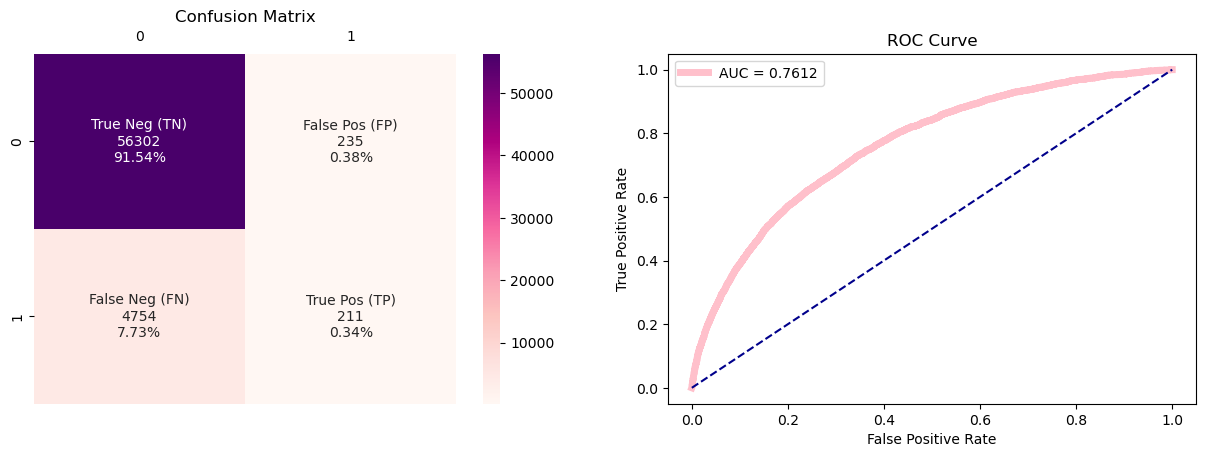

True negative   =  56302
False positive  =  235
False negative  =  4754
True positive   =  211
AUC : 0.7612
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.47      0.04      0.08      4965

    accuracy                           0.92     61502
   macro avg       0.70      0.52      0.52     61502
weighted avg       0.89      0.92      0.89     61502



Modele  Accuracy       AUC  Recall class 1        F1  \
0  Class_Weight_XGBClassifier  0.918881  0.761152        0.042497  0.077989   

      fbeta   TP  Precision    FN  score Gain  train_time  predict_time  
0  0.051955  211   0.473094  4754     0.57262   43.046565      1.266119

time: 1min 29s (started: 2023-09-22 05:44:31 +00:00)


In [36]:
classifier_model = XGBClassifier(objective= 'binary:logistic', class_weight='balanced', random_state = RANDOM_STATE)
ModelName        = f'Class_Weight_{classifier_model.__class__.__name__}'
run_name         = f'Class_Weight_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train_scaled, y_train, X_test_scaled, y_test)
results()

#### <font color='grey'>LGBMClassifier</font>

Exécution en cours ....

Qualité de la classification Class_Weight_LGBMClassifier 
 
L'accuracy score est de      : 0.71611
Le score de précision est de : 0.17544
Le score recall est de       : 0.68016
Le score f1 est de           : 0.27893
Le score AUC est de          : 0.7684586416605932


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             40665 (TN)             15872 (FP)
Real Positive (1)              1588 (FN)              3377 (TP)

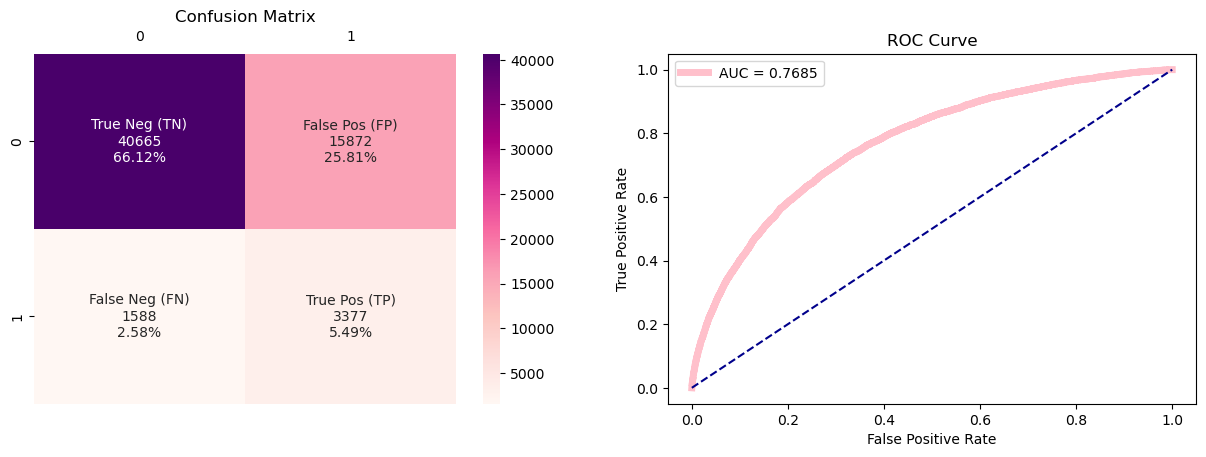

True negative   =  40665
False positive  =  15872
False negative  =  1588
True positive   =  3377
AUC : 0.7685
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56537
           1       0.18      0.68      0.28      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.70      0.55     61502
weighted avg       0.90      0.72      0.78     61502



Modele  Accuracy       AUC  Recall class 1       F1  \
0  Class_Weight_LGBMClassifier  0.716107  0.768459        0.680161  0.27893   

      fbeta    TP  Precision    FN  score Gain  train_time  predict_time  
0  0.431742  3377   0.175438  1588    0.701905   13.322023      1.388551

time: 30.9 s (started: 2023-09-22 05:46:00 +00:00)


In [37]:
classifier_model = LGBMClassifier(objective='binary', class_weight='balanced', random_state = RANDOM_STATE)
ModelName        = f'Class_Weight_{classifier_model.__class__.__name__}'
run_name         = f'Class_Weight_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train_scaled, y_train, X_test_scaled, y_test)
results()

## <a id="5.4.3"> Rééquilibrage avec Sur-échantillonnage : SMOTE </a>



L'oversampling (sur-échantillonnage) est une technique utilisée pour remédier au déséquilibre de classes dans un jeu de données, où une classe est sous-représentée par rapport à une autre classe. L'objectif de l'oversampling est de générer des échantillons synthétiques de la classe minoritaire afin d'équilibrer les classes et d'améliorer les performances du modèle.

Le SMOTE, acronyme pour Synthetic Minority Oversampling TEchnique, est une méthode de suréchantillonnage des observations minoritaires. Pour éviter de réaliser un simple clonage des individus minoritaires, le SMOTE se base sur un principe simple : générer de nouveaux individus minoritaires qui ressemblent aux autres, sans être strictement identiques. Cela permet de densifier de façon plus homogène la population d'individus minoritaires.

In [65]:
# Rééquilibrage avec Sur-échantillonnage (upsampling) de la classe minoritaire : SMOTE 

from imblearn.over_sampling import SMOTE
from collections import Counter
print('Equilibre des classes : {}'.format(Counter(y_train)))
# Définition de l'instance SMOTE
sampling = SMOTE(random_state = RANDOM_SEED)
sample_name=sampling.__class__.__name__
print('sample_name :', sample_name)
# Application du SMOTE aux données
globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'] = \
sampling.fit_resample(X_train_scaled, y_train)
print('Equilibre des classes : {}'.format(Counter(globals()[f'y_train_{sample_name}'])))


Equilibre des classes : Counter({0: 226145, 1: 19860})
sample_name : SMOTE
Equilibre des classes : Counter({0: 226145, 1: 226145})
time: 6.27 s (started: 2023-09-22 08:32:36 +00:00)


#### <font color='grey'>Régression logistique</font>

Exécution en cours ....

Qualité de la classification SMOTE_LogisticRegression 
 
L'accuracy score est de      : 0.80056
Le score de précision est de : 0.17953
Le score recall est de       : 0.41188
Le score f1 est de           : 0.25006
Le score AUC est de          : 0.6840002984615178


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             47191 (TN)              9346 (FP)
Real Positive (1)              2920 (FN)              2045 (TP)

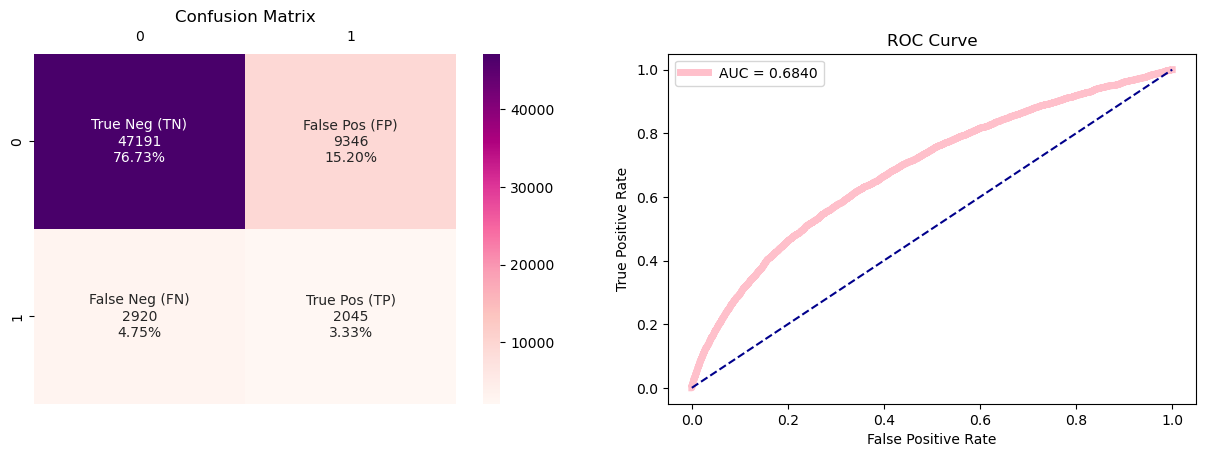

True negative   =  47191
False positive  =  9346
False negative  =  2920
True positive   =  2045
AUC : 0.6840
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     56537
           1       0.18      0.41      0.25      4965

    accuracy                           0.80     61502
   macro avg       0.56      0.62      0.57     61502
weighted avg       0.88      0.80      0.83     61502



Modele  Accuracy    AUC  Recall class 1        F1  \
0  SMOTE_LogisticRegression  0.800559  0.684        0.411883  0.250061   

     fbeta    TP  Precision    FN  score Gain  train_time  predict_time  
0  0.32719  2045   0.179528  2920    0.646993   68.070039      1.054486

time: 2min 15s (started: 2023-09-22 05:46:37 +00:00)


In [39]:
classifier_model = LogisticRegression(max_iter=1500, random_state=RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>Random Forest</font>

Exécution en cours ....

Qualité de la classification SMOTE_RandomForestClassifier 
 
L'accuracy score est de      : 0.89161
Le score de précision est de : 0.23414
Le score recall est de       : 0.15086
Le score f1 est de           : 0.18349
Le score AUC est de          : 0.7129337468689017


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             54087 (TN)              2450 (FP)
Real Positive (1)              4216 (FN)               749 (TP)

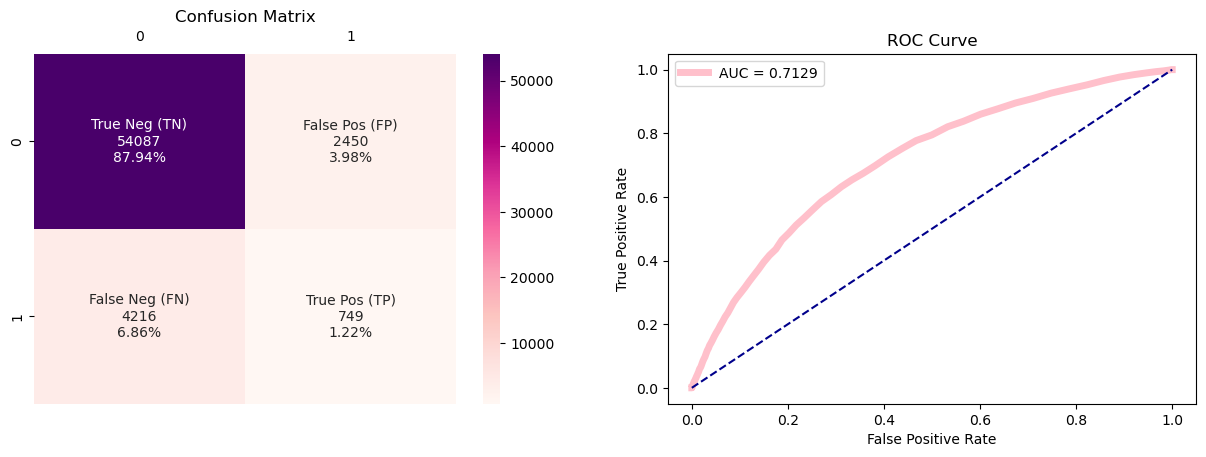

True negative   =  54087
False positive  =  2450
False negative  =  4216
True positive   =  749
AUC : 0.7129
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     56537
           1       0.23      0.15      0.18      4965

    accuracy                           0.89     61502
   macro avg       0.58      0.55      0.56     61502
weighted avg       0.87      0.89      0.88     61502



Modele  Accuracy       AUC  Recall class 1        F1  \
0  SMOTE_RandomForestClassifier  0.891613  0.712934        0.150856  0.183488   

      fbeta   TP  Precision    FN  score Gain   train_time  predict_time  
0  0.162409  749   0.234136  4216    0.598938  1658.809002      4.000133

time: 54min 43s (started: 2023-09-22 05:48:52 +00:00)


In [40]:
classifier_model = RandomForestClassifier(random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>DecisionTreeClassifier </font>

Exécution en cours ....

Qualité de la classification SMOTE_DecisionTreeClassifier 
 
L'accuracy score est de      : 0.78724
Le score de précision est de : 0.13104
Le score recall est de       : 0.29043
Le score f1 est de           : 0.1806
Le score AUC est de          : 0.5606524248368503


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             46975 (TN)              9562 (FP)
Real Positive (1)              3523 (FN)              1442 (TP)

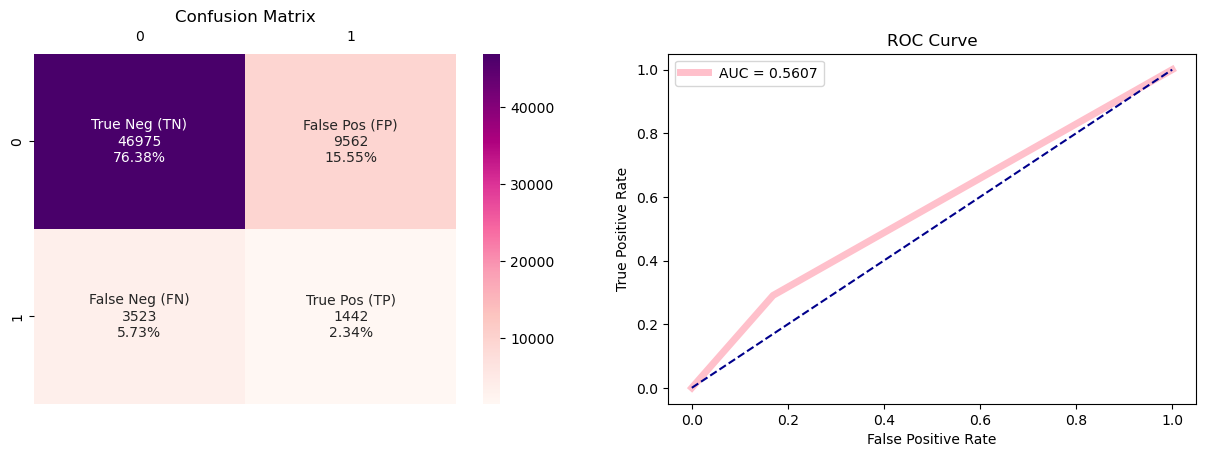

True negative   =  46975
False positive  =  9562
False negative  =  3523
True positive   =  1442
AUC : 0.5607
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     56537
           1       0.13      0.29      0.18      4965

    accuracy                           0.79     61502
   macro avg       0.53      0.56      0.53     61502
weighted avg       0.87      0.79      0.82     61502



Modele  Accuracy       AUC  Recall class 1      F1  \
0  SMOTE_DecisionTreeClassifier  0.787243  0.560652        0.290433  0.1806   

      fbeta    TP  Precision    FN  score Gain  train_time  predict_time  
0  0.233605  1442   0.131043  3523    0.590952  226.620423      1.106726

time: 7min 23s (started: 2023-09-22 08:32:46 +00:00)


In [66]:
classifier_model = DecisionTreeClassifier(random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>XGBClassifier</font>

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Exécution en cours ....



is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Qualité de la classification SMOTE_XGBClassifier 
 
L'accuracy score est de      : 0.90576
Le score de précision est de : 0.27455
Le score recall est de       : 0.10191
Le score f1 est de           : 0.14865
Le score AUC est de          : 0.7153135677923472


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             55200 (TN)              1337 (FP)
Real Positive (1)              4459 (FN)               506 (TP)

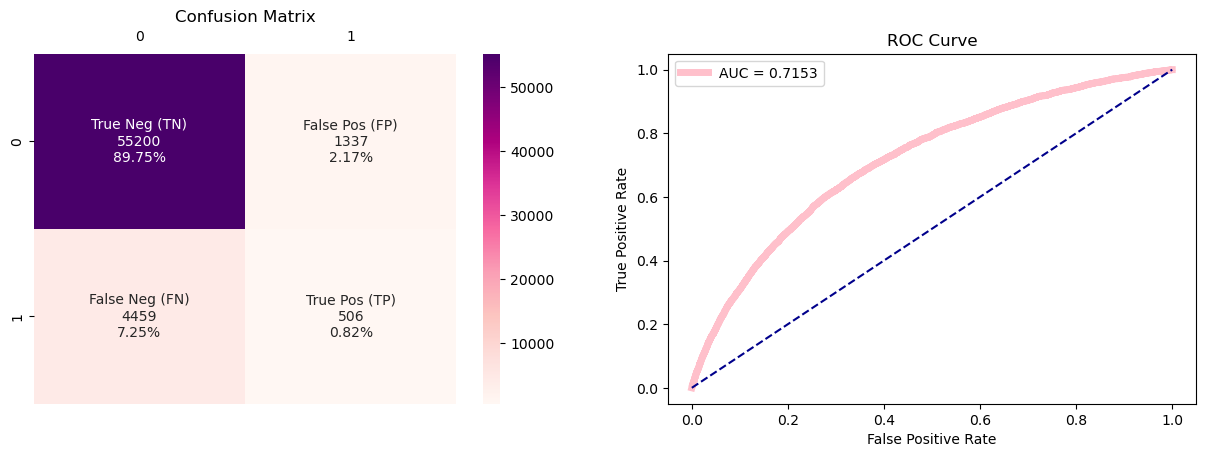

True negative   =  55200
False positive  =  1337
False negative  =  4459
True positive   =  506
AUC : 0.7153
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     56537
           1       0.27      0.10      0.15      4965

    accuracy                           0.91     61502
   macro avg       0.60      0.54      0.55     61502
weighted avg       0.87      0.91      0.89     61502



Modele  Accuracy       AUC  Recall class 1        F1  \
0  SMOTE_XGBClassifier  0.905759  0.715314        0.101913  0.148649   

      fbeta   TP  Precision    FN  score Gain  train_time  predict_time  
0  0.116574  506   0.274552  4459    0.588158  111.254269       1.38781

time: 3min 41s (started: 2023-09-22 06:43:35 +00:00)


In [41]:
classifier_model = XGBClassifier(objective= 'binary:logistic', random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>LGBMClassifier</font>

Exécution en cours ....

Qualité de la classification SMOTE_LGBMClassifier 
 
L'accuracy score est de      : 0.90189
Le score de précision est de : 0.25782
Le score recall est de       : 0.1146
Le score f1 est de           : 0.15867
Le score AUC est de          : 0.7095124776454443


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             54899 (TN)              1638 (FP)
Real Positive (1)              4396 (FN)               569 (TP)

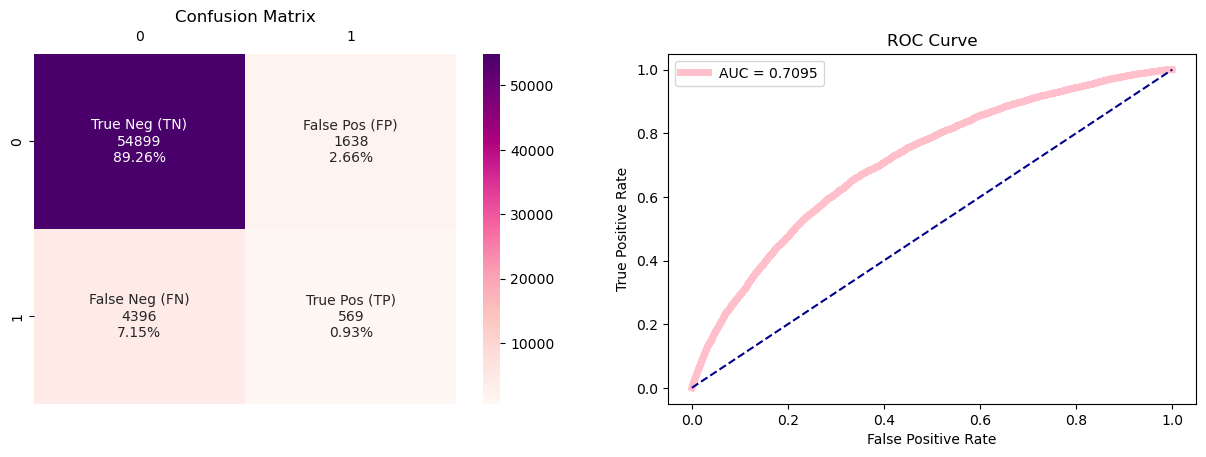

True negative   =  54899
False positive  =  1638
False negative  =  4396
True positive   =  569
AUC : 0.7095
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     56537
           1       0.26      0.11      0.16      4965

    accuracy                           0.90     61502
   macro avg       0.59      0.54      0.55     61502
weighted avg       0.87      0.90      0.88     61502



Modele  Accuracy       AUC  Recall class 1        F1  \
0  SMOTE_LGBMClassifier  0.901889  0.709512        0.114602  0.158673   

      fbeta   TP  Precision    FN  score Gain  train_time  predict_time  
0  0.128926  569   0.257816  4396    0.590831   20.585783      1.567918

time: 46.1 s (started: 2023-09-22 06:47:17 +00:00)


In [42]:
classifier_model = LGBMClassifier(objective='binary', random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

## <a id="5.4.4"> Rééquilibrage avec Sous-échantillonnage : Tomek Links </a>

L'undersampling (sous-échantillonnage) est une technique utilisée pour remédier au déséquilibre de classes dans un jeu de données, où une classe est sur-représentée par rapport à une autre classe. L'objectif de l'undersampling est de réduire le nombre d'échantillons de la classe majoritaire afin d'équilibrer les classes et d'améliorer les performances du modèle.

Tomek Links est une approche de sous-échantillonnage de la classe majoritaire. L'idée est de chercher les points de la classe majoritaire qui sont assez proches d'un point de la classe minoritaire. Les paires de points identifiées sont appelées tomek links. Dans chaque tomek link on va retirer le point qui appartient à la classe majoritaire.

In [67]:
# Rééquilibrage avec Sous-échantillonnage (undersampling) de la classe majoritaire : Tomek Links
print('Equilibre des classes : {}'.format(Counter(y_train)))
# Création de l'objet TomekLinks
sampling = TomekLinks()
# Sous-échantillonnage en utilisant Tomek Links
sample_name=sampling.__class__.__name__
print('sample_name :', sample_name)
# Application du SMOTE aux données
globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'] = \
sampling.fit_resample(X_train_scaled, y_train)
print('Equilibre des classes : {}'.format(Counter(globals()[f'y_train_{sample_name}'])))

Equilibre des classes : Counter({0: 226145, 1: 19860})
sample_name : TomekLinks
Equilibre des classes : Counter({0: 221811, 1: 19860})
time: 3min 1s (started: 2023-09-22 08:40:09 +00:00)


#### <font color='grey'>Régression logistique</font>

Exécution en cours ....

Qualité de la classification TomekLinks_LogisticRegression 
 
L'accuracy score est de      : 0.91943
Le score de précision est de : 0.52451
Le score recall est de       : 0.02155
Le score f1 est de           : 0.0414
Le score AUC est de          : 0.7521393907199166


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             56440 (TN)                97 (FP)
Real Positive (1)              4858 (FN)               107 (TP)

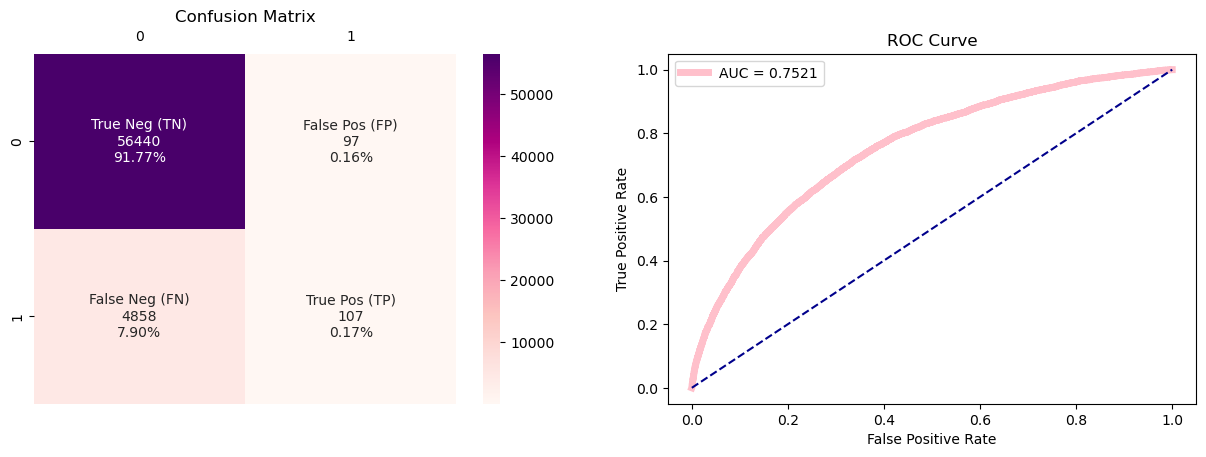

True negative   =  56440
False positive  =  97
False negative  =  4858
True positive   =  107
AUC : 0.7521
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.52      0.02      0.04      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502



Modele  Accuracy       AUC  Recall class 1  \
0  TomekLinks_LogisticRegression  0.919434  0.752139        0.021551   

         F1     fbeta   TP  Precision    FN  score Gain  train_time  \
0  0.041401  0.026665  107    0.52451  4858    0.564678   27.916593   

   predict_time  
0      1.050925

time: 59 s (started: 2023-09-22 06:51:17 +00:00)


In [44]:
classifier_model = LogisticRegression(max_iter=1500, random_state=RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>Random Forest</font>

Exécution en cours ....

Qualité de la classification TomekLinks_RandomForestClassifier 
 
L'accuracy score est de      : 0.91922
Le score de précision est de : 0.44828
Le score recall est de       : 0.00262
Le score f1 est de           : 0.00521
Le score AUC est de          : 0.7116448334300269


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             56521 (TN)                16 (FP)
Real Positive (1)              4952 (FN)                13 (TP)

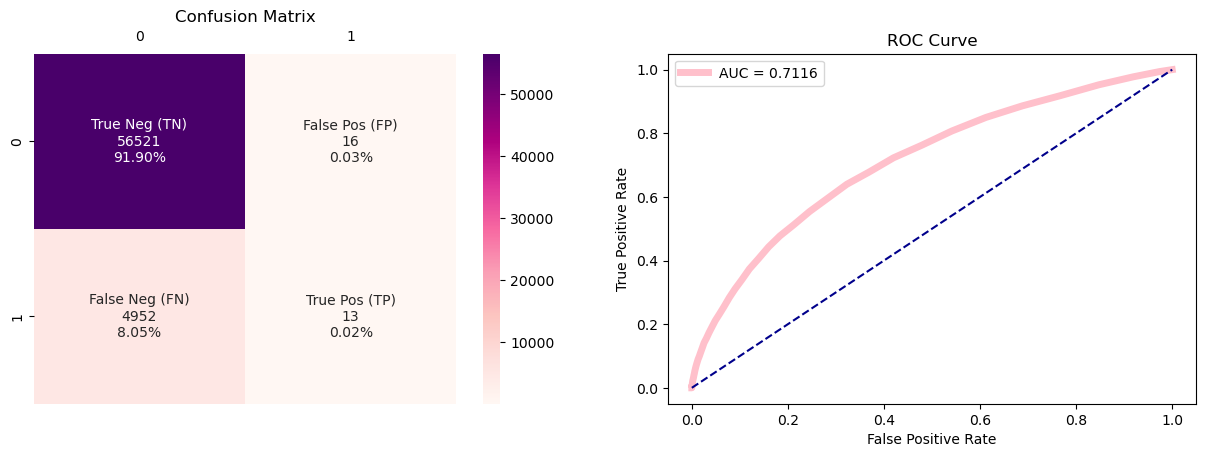

True negative   =  56521
False positive  =  16
False negative  =  4952
True positive   =  13
AUC : 0.7116
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.45      0.00      0.01      4965

    accuracy                           0.92     61502
   macro avg       0.68      0.50      0.48     61502
weighted avg       0.88      0.92      0.88     61502



Modele  Accuracy       AUC  Recall class 1  \
0  TomekLinks_RandomForestClassifier  0.919222  0.711645        0.002618   

         F1     fbeta  TP  Precision    FN  score Gain  train_time  \
0  0.005206  0.003268  13   0.448276  4952     0.55707  709.120639   

   predict_time  
0      4.289615

time: 23min 48s (started: 2023-09-22 06:52:16 +00:00)


In [45]:
classifier_model = RandomForestClassifier(random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>DecisionTreeClassifier </font>

Exécution en cours ....

Qualité de la classification TomekLinks_DecisionTreeClassifier 
 
L'accuracy score est de      : 0.84973
Le score de précision est de : 0.13944
Le score recall est de       : 0.16657
Le score f1 est de           : 0.1518
Le score AUC est de          : 0.538144399052383


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             51433 (TN)              5104 (FP)
Real Positive (1)              4138 (FN)               827 (TP)

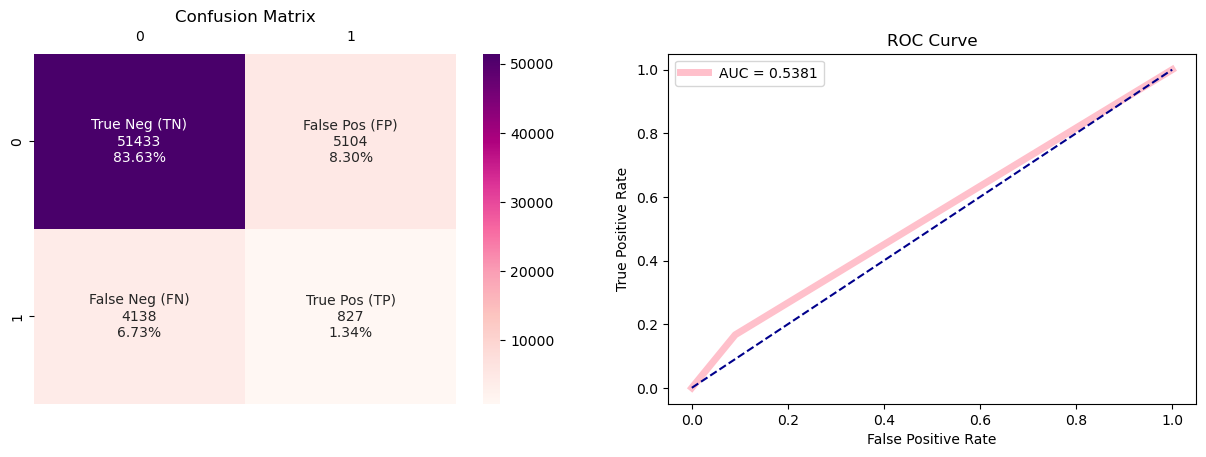

True negative   =  51433
False positive  =  5104
False negative  =  4138
True positive   =  827
AUC : 0.5381
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     56537
           1       0.14      0.17      0.15      4965

    accuracy                           0.85     61502
   macro avg       0.53      0.54      0.53     61502
weighted avg       0.86      0.85      0.86     61502



Modele  Accuracy       AUC  Recall class 1  \
0  TomekLinks_DecisionTreeClassifier  0.849728  0.538144        0.166566   

         F1     fbeta   TP  Precision    FN  score Gain  train_time  \
0  0.151799  0.160327  827   0.139437  4138    0.579809  105.331335   

   predict_time  
0      1.041952

time: 3min 28s (started: 2023-09-22 08:43:11 +00:00)


In [68]:
classifier_model = DecisionTreeClassifier(random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>XGBClassifier</font>

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Exécution en cours ....



is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Qualité de la classification TomekLinks_XGBClassifier 
 
L'accuracy score est de      : 0.9193
Le score de précision est de : 0.50176
Le score recall est de       : 0.0574
Le score f1 est de           : 0.10302
Le score AUC est de          : 0.7598008672448121


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             56254 (TN)               283 (FP)
Real Positive (1)              4680 (FN)               285 (TP)

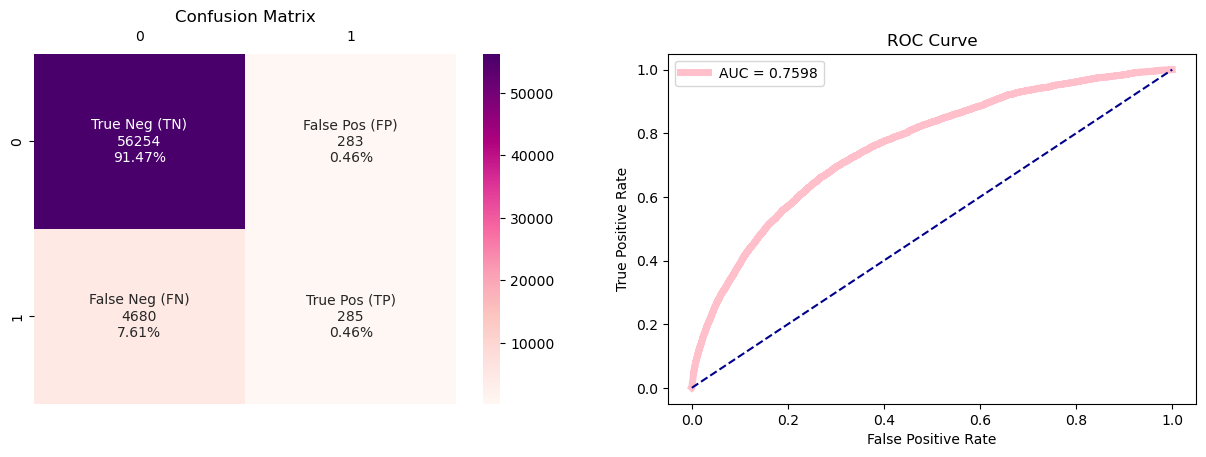

True negative   =  56254
False positive  =  283
False negative  =  4680
True positive   =  285
AUC : 0.7598
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56537
           1       0.50      0.06      0.10      4965

    accuracy                           0.92     61502
   macro avg       0.71      0.53      0.53     61502
weighted avg       0.89      0.92      0.89     61502



Modele  Accuracy       AUC  Recall class 1        F1  \
0  TomekLinks_XGBClassifier  0.919303  0.759801        0.057402  0.103018   

      fbeta   TP  Precision    FN  score Gain  train_time  predict_time  
0  0.069757  285   0.501761  4680    0.578764    45.66732      1.474951

time: 1min 33s (started: 2023-09-22 07:24:07 +00:00)


In [46]:
classifier_model = XGBClassifier(objective= 'binary:logistic', random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>LGBMClassifier</font>

Exécution en cours ....

Qualité de la classification TomekLinks_LGBMClassifier 
 
L'accuracy score est de      : 0.9195
Le score de précision est de : 0.52612
Le score recall est de       : 0.0284
Le score f1 est de           : 0.05389
Le score AUC est de          : 0.7678844398897416


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             56410 (TN)               127 (FP)
Real Positive (1)              4824 (FN)               141 (TP)

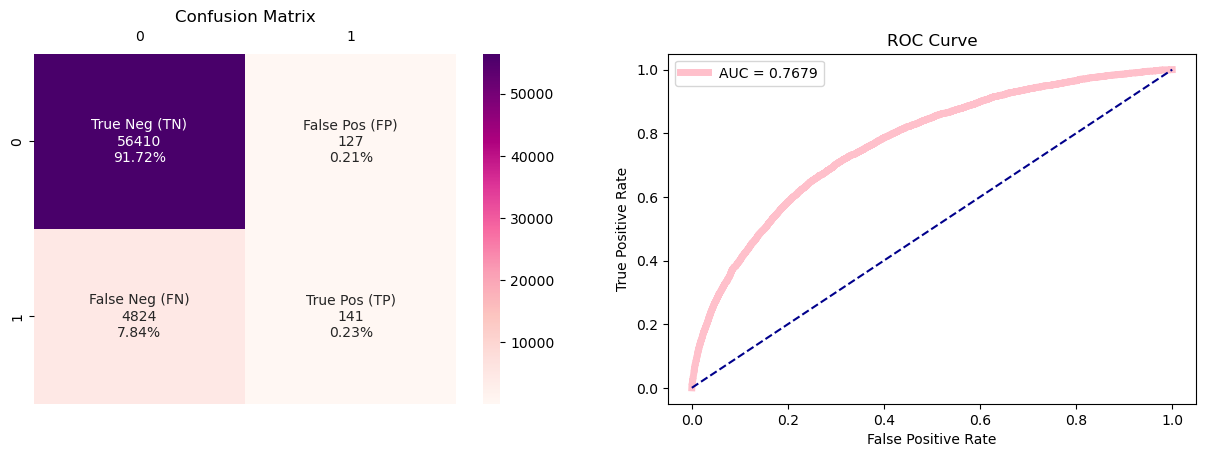

True negative   =  56410
False positive  =  127
False negative  =  4824
True positive   =  141
AUC : 0.7679
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.53      0.03      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.51      0.51     61502
weighted avg       0.89      0.92      0.88     61502



Modele  Accuracy       AUC  Recall class 1        F1  \
0  TomekLinks_LGBMClassifier  0.919499  0.767884        0.028399  0.053889   

      fbeta   TP  Precision    FN  score Gain  train_time  predict_time  
0  0.035026  141   0.526119  4824    0.567423   13.408668      1.699861

time: 31.3 s (started: 2023-09-22 07:25:40 +00:00)


In [47]:
classifier_model = LGBMClassifier(objective='binary', random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

In [48]:
# Affichez la distribution des classes après sous-échantillonnage
print("Distribution des classes après sous-échantillonnage :", Counter(globals()[f'y_train_{sample_name}']))

Distribution des classes après sous-échantillonnage : Counter({0: 221811, 1: 19860})
time: 31 ms (started: 2023-09-22 07:31:32 +00:00)


## <a id="5.4.5"> RandomUnderSampler </a>

Le ***Random Undersampler*** vise à résoudre ce problème en réduisant aléatoirement le nombre d'exemples de la classe majoritaire pour équilibrer les proportions entre les classes. Voici comment fonctionne généralement cette méthode :

- [X] **Étape 1** : Identifier les classes déséquilibrées.
Tout d'abord, vous devez déterminer quelles classes sont déséquilibrées dans votre ensemble de données. Cela implique de compter le nombre d'exemples dans chaque classe.

- [X] **Étape 2** : Sélectionner aléatoirement des exemples.
Une fois que vous avez identifié les classes déséquilibrées, vous pouvez utiliser le Random Undersampler pour sélectionner aléatoirement un sous-ensemble d'exemples de la classe majoritaire. L'objectif est de réduire le nombre d'exemples de la classe majoritaire pour qu'il soit similaire à celui de la classe minoritaire.

- [X] **Étape 3** : Entraîner le modèle.

In [69]:
# Rééquilibrage avec Sous-échantillonnage (undersampling) de la classe majoritaire : RandomUnderSampler

print('Equilibre des classes : {}'.format(Counter(y_train)))
# Création de l'objet 
sampling = RandomUnderSampler()
# Sous-échantillonnage en utilisant RandomUnderSampler
sample_name=sampling.__class__.__name__
print('sample_name :', sample_name)
# Application du SMOTE aux données
globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'] = \
sampling.fit_resample(X_train_scaled, y_train)
print('Equilibre des classes : {}'.format(Counter(globals()[f'y_train_{sample_name}'])))

Equilibre des classes : Counter({0: 226145, 1: 19860})
sample_name : RandomUnderSampler
Equilibre des classes : Counter({0: 19860, 1: 19860})
time: 219 ms (started: 2023-09-22 08:46:40 +00:00)


#### <font color='grey'>Régression logistique</font>

Exécution en cours ....

Qualité de la classification RandomUnderSampler_LogisticRegression 
 
L'accuracy score est de      : 0.69383
Le score de précision est de : 0.16385
Le score recall est de       : 0.68056
Le score f1 est de           : 0.26411
Le score AUC est de          : 0.7513744521607565


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             39293 (TN)             17244 (FP)
Real Positive (1)              1586 (FN)              3379 (TP)

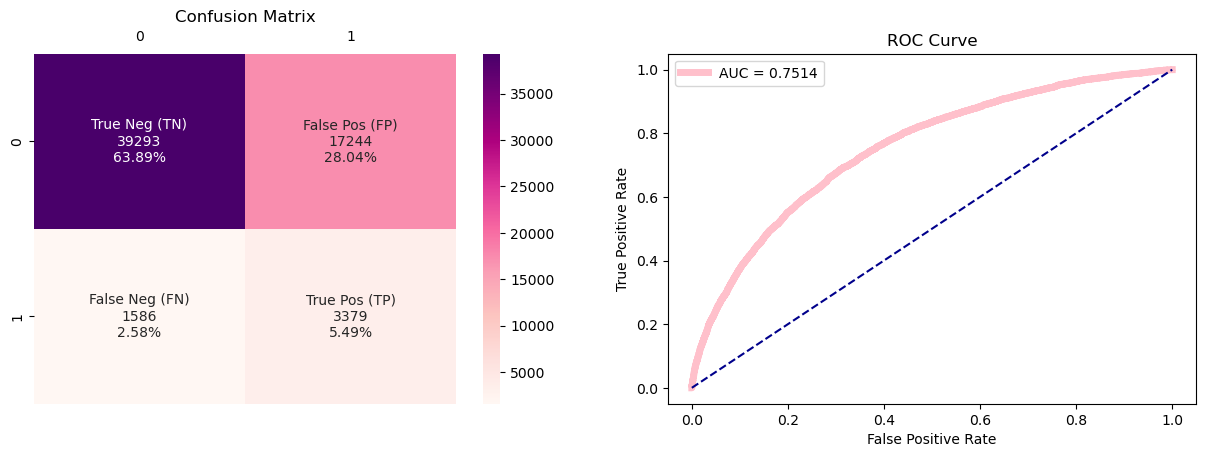

True negative   =  39293
False positive  =  17244
False negative  =  1586
True positive   =  3379
AUC : 0.7514
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56537
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.69      0.76     61502



Modele  Accuracy       AUC  Recall class 1  \
0  RandomUnderSampler_LogisticRegression  0.693831  0.751374        0.680564   

         F1     fbeta    TP  Precision    FN  score Gain  train_time  \
0  0.264108  0.417336  3379   0.163846  1586    0.688589    6.944206   

   predict_time  
0      1.048449

time: 17 s (started: 2023-09-22 07:31:42 +00:00)


In [50]:
classifier_model = LogisticRegression(max_iter=1500, random_state=RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>Random Forest</font>

Exécution en cours ....

Qualité de la classification RandomUnderSampler_RandomForestClassifier 
 
L'accuracy score est de      : 0.68718
Le score de précision est de : 0.15878
Le score recall est de       : 0.66888
Le score f1 est de           : 0.25664
Le score AUC est de          : 0.7396349539191697


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             38942 (TN)             17595 (FP)
Real Positive (1)              1644 (FN)              3321 (TP)

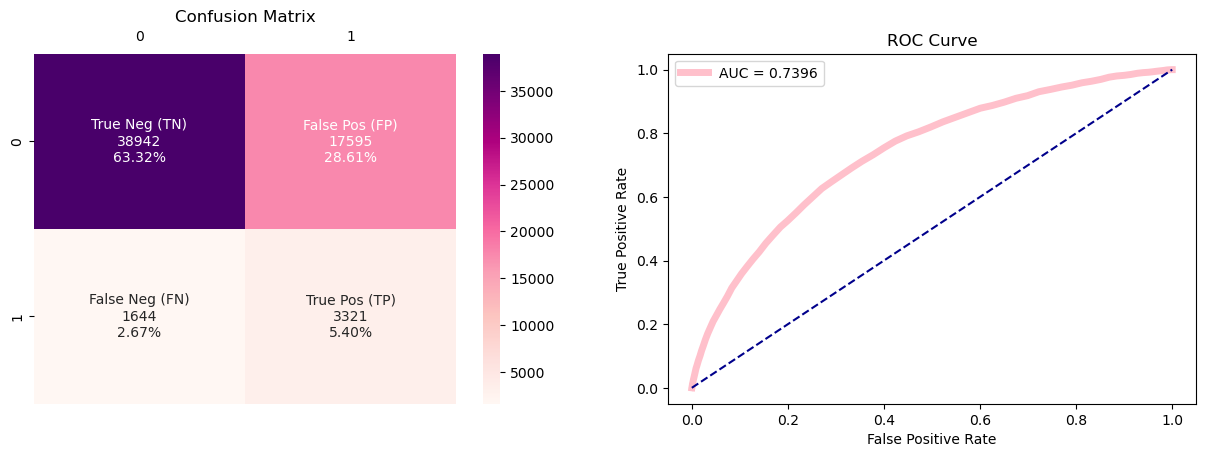

True negative   =  38942
False positive  =  17595
False negative  =  1644
True positive   =  3321
AUC : 0.7396
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56537
           1       0.16      0.67      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.68      0.53     61502
weighted avg       0.89      0.69      0.76     61502



Modele  Accuracy       AUC  \
0  RandomUnderSampler_RandomForestClassifier  0.687181  0.739635   

   Recall class 1        F1     fbeta    TP  Precision    FN  score Gain  \
0        0.668882  0.256636  0.407225  3321   0.158778  1644    0.679951   

   train_time  predict_time  
0   92.398735      3.022235

time: 3min 10s (started: 2023-09-22 07:31:59 +00:00)


In [51]:
classifier_model = RandomForestClassifier(random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>DecisionTreeClassifier </font>

Exécution en cours ....

Qualité de la classification RandomUnderSampler_DecisionTreeClassifier 
 
L'accuracy score est de      : 0.58629
Le score de précision est de : 0.11136
Le score recall est de       : 0.59094
Le score f1 est de           : 0.1874
Le score AUC est de          : 0.5884091839010114


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             33124 (TN)             23413 (FP)
Real Positive (1)              2031 (FN)              2934 (TP)

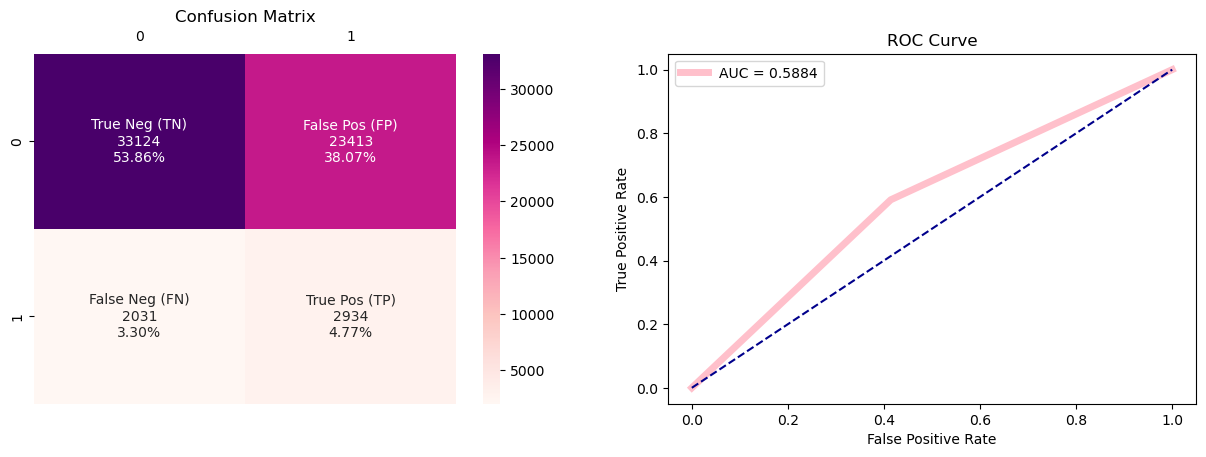

True negative   =  33124
False positive  =  23413
False negative  =  2031
True positive   =  2934
AUC : 0.5884
              precision    recall  f1-score   support

           0       0.94      0.59      0.72     56537
           1       0.11      0.59      0.19      4965

    accuracy                           0.59     61502
   macro avg       0.53      0.59      0.45     61502
weighted avg       0.88      0.59      0.68     61502



Modele  Accuracy       AUC  \
0  RandomUnderSampler_DecisionTreeClassifier   0.58629  0.588409   

   Recall class 1        F1     fbeta    TP  Precision    FN  score Gain  \
0        0.590937  0.187404  0.317484  2934    0.11136  2031    0.588126   

   train_time  predict_time  
0   14.233217      1.082424

time: 32.1 s (started: 2023-09-22 08:46:40 +00:00)


In [70]:
classifier_model = DecisionTreeClassifier(random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>XGBClassifier</font>

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Exécution en cours ....



is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Qualité de la classification RandomUnderSampler_XGBClassifier 
 
L'accuracy score est de      : 0.68396
Le score de précision est de : 0.1599
Le score recall est de       : 0.6852
Le score f1 est de           : 0.25929
Le score AUC est de          : 0.7494275322485302


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             38663 (TN)             17874 (FP)
Real Positive (1)              1563 (FN)              3402 (TP)

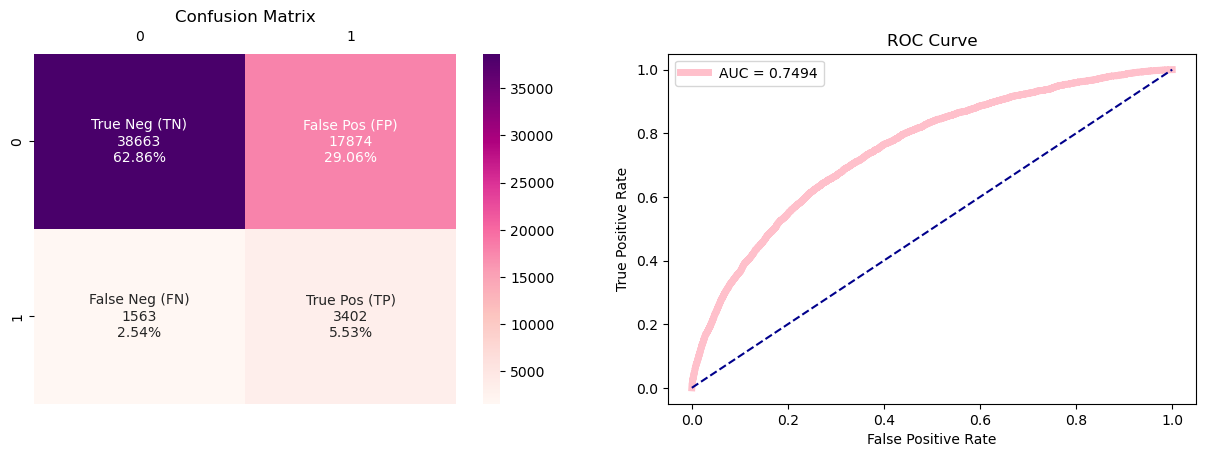

True negative   =  38663
False positive  =  17874
False negative  =  1563
True positive   =  3402
AUC : 0.7494
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56537
           1       0.16      0.69      0.26      4965

    accuracy                           0.68     61502
   macro avg       0.56      0.68      0.53     61502
weighted avg       0.90      0.68      0.76     61502



Modele  Accuracy       AUC  Recall class 1  \
0  RandomUnderSampler_XGBClassifier  0.683961  0.749428        0.685196   

         F1     fbeta    TP  Precision    FN  score Gain  train_time  \
0  0.259289  0.413506  3402   0.159898  1563    0.684449   10.169579   

   predict_time  
0      1.579034

time: 24.4 s (started: 2023-09-22 07:35:09 +00:00)


In [52]:
classifier_model = XGBClassifier(objective= 'binary:logistic', random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>LGBMClassifier</font>

Exécution en cours ....

Qualité de la classification RandomUnderSampler_LGBMClassifier 
 
L'accuracy score est de      : 0.69512
Le score de précision est de : 0.16742
Le score recall est de       : 0.69889
Le score f1 est de           : 0.27013
Le score AUC est de          : 0.7634391729958374


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             39281 (TN)             17256 (FP)
Real Positive (1)              1495 (FN)              3470 (TP)

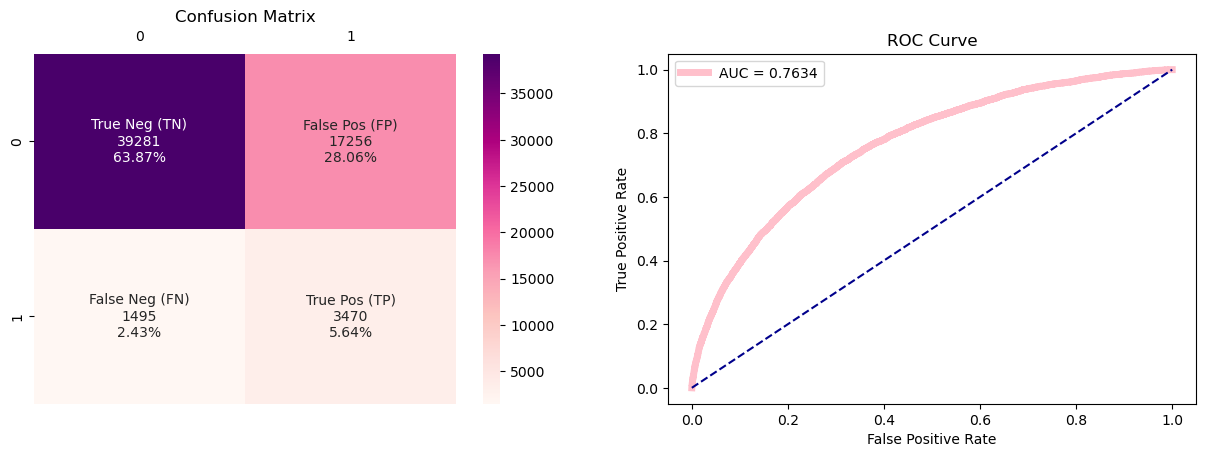

True negative   =  39281
False positive  =  17256
False negative  =  1495
True positive   =  3470
AUC : 0.7634
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56537
           1       0.17      0.70      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.70      0.54     61502
weighted avg       0.90      0.70      0.76     61502



Modele  Accuracy       AUC  Recall class 1  \
0  RandomUnderSampler_LGBMClassifier  0.695116  0.763439        0.698892   

         F1     fbeta    TP  Precision    FN  score Gain  train_time  \
0  0.270134  0.427487  3470   0.167423  1495    0.696608    6.340689   

   predict_time  
0      1.419471

time: 16.8 s (started: 2023-09-22 07:35:34 +00:00)


In [53]:
classifier_model = LGBMClassifier(objective='binary', random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

### RandomOverSampler

Le **`RandomOverSampler`** est une méthode qui augmente le nombre d'échantillons de la classe minoritaire dans un ensemble de données déséquilibré en utilisant une approche aléatoire. Il sélectionne des échantillons de la classe minoritaire existante de manière aléatoire et les duplique pour augmenter leur nombre jusqu'à ce que le déséquilibre des classes soit résolu ou qu'un ratio spécifié entre les classes soit atteint.

In [71]:
# Rééquilibrage avec Sous-échantillonnage (undersampling) de la classe majoritaire : Tomek Links
print('Equilibre des classes : {}'.format(Counter(y_train)))
# Random oversampling minority class
sampling = RandomOverSampler(random_state=RANDOM_STATE)
sample_name=sampling.__class__.__name__
print('sample_name :', sample_name)
# Application du SMOTE aux données
globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'] = \
sampling.fit_resample(X_train_scaled, y_train)
print('Equilibre des classes : {}'.format(Counter(globals()[f'y_train_{sample_name}'])))

Equilibre des classes : Counter({0: 226145, 1: 19860})
sample_name : RandomOverSampler
Equilibre des classes : Counter({0: 226145, 1: 226145})
time: 3.61 s (started: 2023-09-22 08:47:12 +00:00)


#### <font color='grey'>Régression logistique</font>

Exécution en cours ....

Qualité de la classification RandomOverSampler_LogisticRegression 
 
L'accuracy score est de      : 0.69354
Le score de précision est de : 0.16357
Le score recall est de       : 0.67976
Le score f1 est de           : 0.26369
Le score AUC est de          : 0.752163237716815


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             39279 (TN)             17258 (FP)
Real Positive (1)              1590 (FN)              3375 (TP)

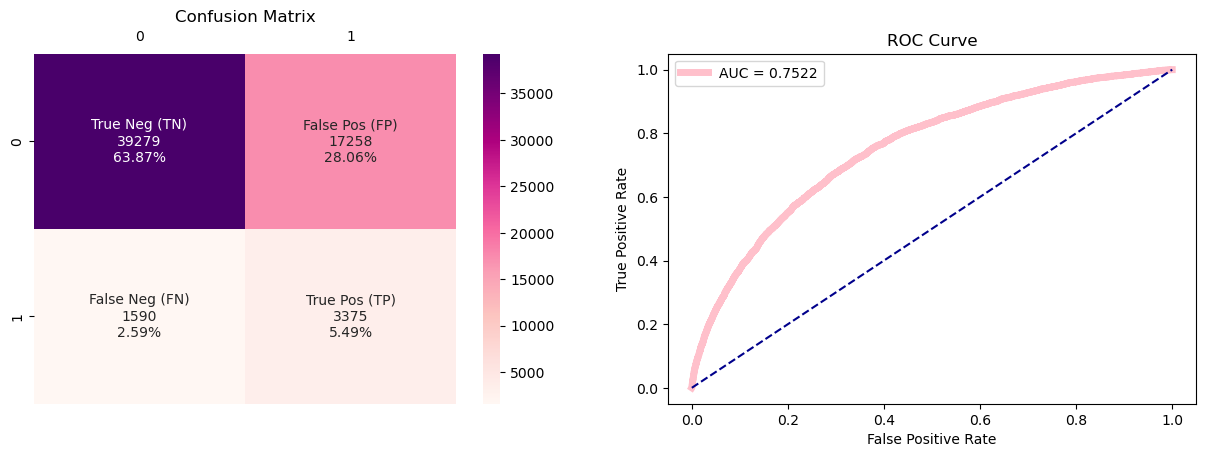

True negative   =  39279
False positive  =  17258
False negative  =  1590
True positive   =  3375
AUC : 0.7522
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56537
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.69      0.76     61502



Modele  Accuracy       AUC  Recall class 1  \
0  RandomOverSampler_LogisticRegression  0.693538  0.752163        0.679758   

         F1     fbeta    TP  Precision    FN  score Gain  train_time  \
0  0.263692  0.416739  3375   0.163573  1590    0.688094   54.917076   

   predict_time  
0      0.964776

time: 1min 52s (started: 2023-09-22 07:39:14 +00:00)


In [57]:
classifier_model = LogisticRegression(max_iter=1500, random_state=RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>Random Forest</font>

Exécution en cours ....

Qualité de la classification RandomOverSampler_RandomForestClassifier 
 
L'accuracy score est de      : 0.91886
Le score de précision est de : 0.41259
Le score recall est de       : 0.01188
Le score f1 est de           : 0.0231
Le score AUC est de          : 0.7326879468161382


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             56453 (TN)                84 (FP)
Real Positive (1)              4906 (FN)                59 (TP)

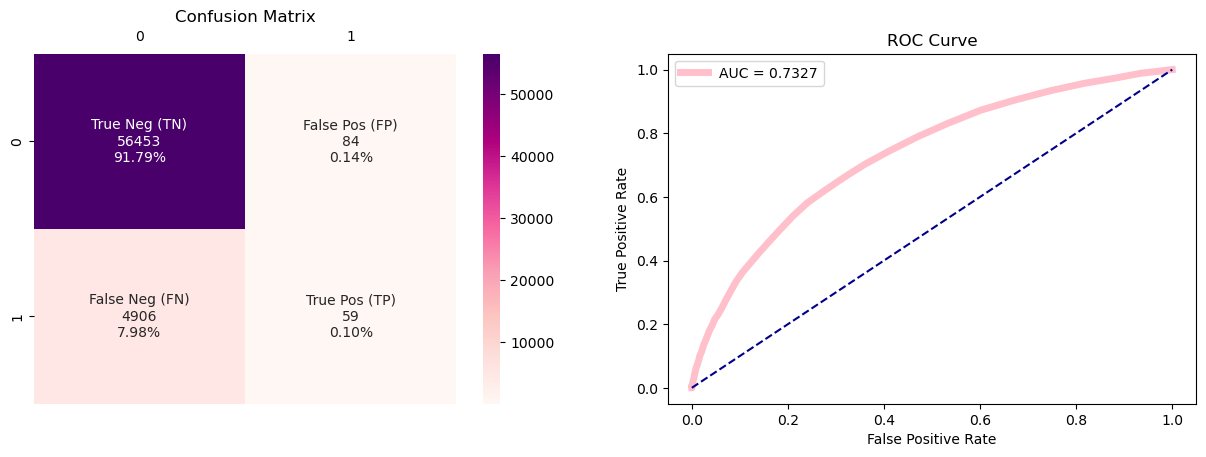

True negative   =  56453
False positive  =  84
False negative  =  4906
True positive   =  59
AUC : 0.7327
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.41      0.01      0.02      4965

    accuracy                           0.92     61502
   macro avg       0.67      0.51      0.49     61502
weighted avg       0.88      0.92      0.88     61502



Modele  Accuracy       AUC  \
0  RandomOverSampler_RandomForestClassifier  0.918864  0.732688   

   Recall class 1        F1     fbeta  TP  Precision    FN  score Gain  \
0        0.011883  0.023101  0.014748  59   0.412587  4906    0.560514   

   train_time  predict_time  
0  804.147341      3.618905

time: 27min 4s (started: 2023-09-22 07:41:06 +00:00)


In [58]:
classifier_model = RandomForestClassifier(random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>DecisionTreeClassifier </font>

Exécution en cours ....

Qualité de la classification RandomOverSampler_DecisionTreeClassifier 
 
L'accuracy score est de      : 0.85929
Le score de précision est de : 0.14887
Le score recall est de       : 0.1575
Le score f1 est de           : 0.15306
Le score AUC est de          : 0.5392107808945655


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             52066 (TN)              4471 (FP)
Real Positive (1)              4183 (FN)               782 (TP)

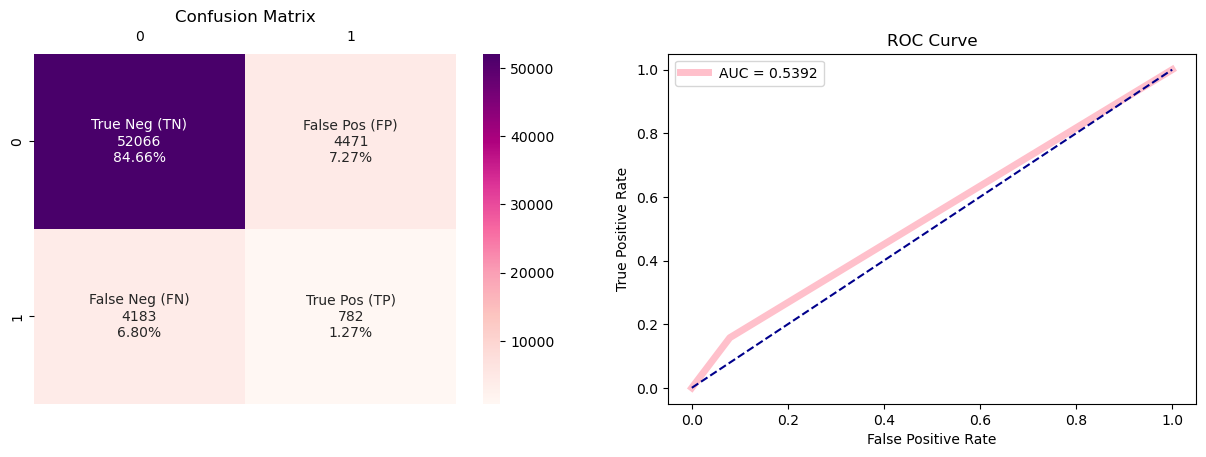

True negative   =  52066
False positive  =  4471
False negative  =  4183
True positive   =  782
AUC : 0.5392
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     56537
           1       0.15      0.16      0.15      4965

    accuracy                           0.86     61502
   macro avg       0.54      0.54      0.54     61502
weighted avg       0.86      0.86      0.86     61502



Modele  Accuracy       AUC  \
0  RandomOverSampler_DecisionTreeClassifier  0.859289  0.539211   

   Recall class 1        F1     fbeta   TP  Precision    FN  score Gain  \
0        0.157503  0.153063  0.155696  782   0.148867  4183    0.582012   

   train_time  predict_time  
0   94.467618      0.991392

time: 3min 11s (started: 2023-09-22 08:47:16 +00:00)


In [72]:
classifier_model = DecisionTreeClassifier(random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>XGBClassifier</font>

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Exécution en cours ....



is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Qualité de la classification RandomOverSampler_XGBClassifier 
 
L'accuracy score est de      : 0.75641
Le score de précision est de : 0.18766
Le score recall est de       : 0.60604
Le score f1 est de           : 0.28659
Le score AUC est de          : 0.7546058306762403


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             43512 (TN)             13025 (FP)
Real Positive (1)              1956 (FN)              3009 (TP)

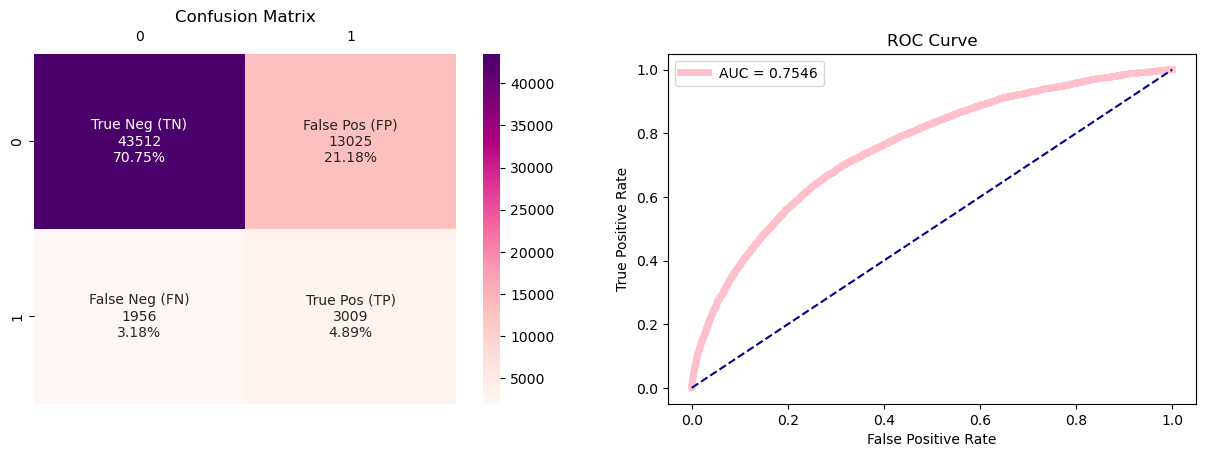

True negative   =  43512
False positive  =  13025
False negative  =  1956
True positive   =  3009
AUC : 0.7546
              precision    recall  f1-score   support

           0       0.96      0.77      0.85     56537
           1       0.19      0.61      0.29      4965

    accuracy                           0.76     61502
   macro avg       0.57      0.69      0.57     61502
weighted avg       0.89      0.76      0.81     61502



Modele  Accuracy       AUC  Recall class 1  \
0  RandomOverSampler_XGBClassifier  0.756414  0.754606        0.606042   

         F1     fbeta    TP  Precision    FN  score Gain  train_time  \
0  0.286585  0.419151  3009   0.187664  1956    0.697002   65.453414   

   predict_time  
0      1.359519

time: 2min 17s (started: 2023-09-22 08:08:10 +00:00)


In [59]:
classifier_model = XGBClassifier(objective= 'binary:logistic', random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

#### <font color='grey'>LGBMClassifier</font>

Exécution en cours ....

Qualité de la classification RandomOverSampler_LGBMClassifier 
 
L'accuracy score est de      : 0.71736
Le score de précision est de : 0.17668
Le score recall est de       : 0.68338
Le score f1 est de           : 0.28077
Le score AUC est de          : 0.7698651798594904


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             40726 (TN)             15811 (FP)
Real Positive (1)              1572 (FN)              3393 (TP)

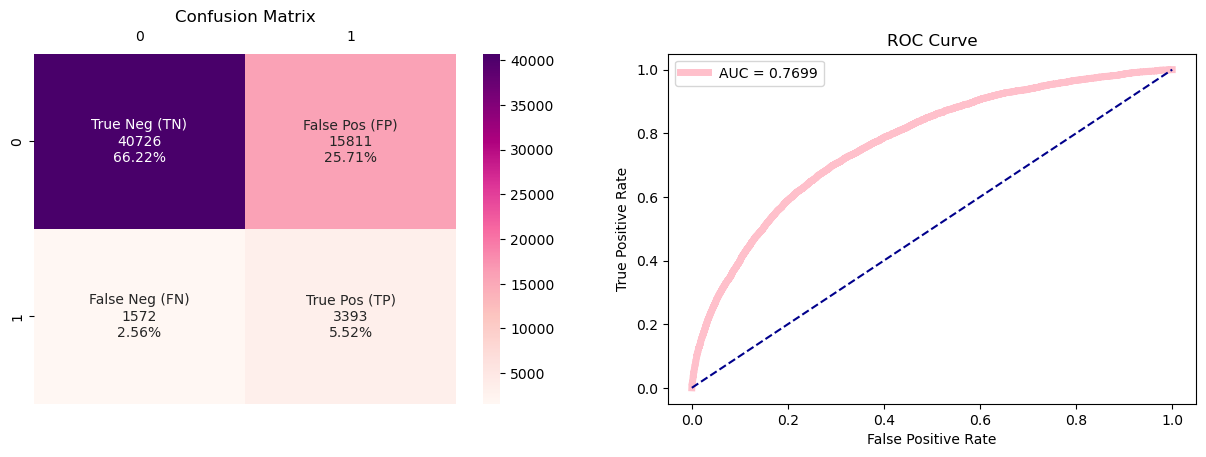

True negative   =  40726
False positive  =  15811
False negative  =  1572
True positive   =  3393
AUC : 0.7699
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56537
           1       0.18      0.68      0.28      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.70      0.55     61502
weighted avg       0.90      0.72      0.78     61502



Modele  Accuracy       AUC  Recall class 1  \
0  RandomOverSampler_LGBMClassifier  0.717359  0.769865        0.683384   

         F1     fbeta    TP  Precision    FN  score Gain  train_time  \
0  0.280773  0.434287  3393   0.176682  1572    0.703935   20.386565   

   predict_time  
0      1.472695

time: 45.4 s (started: 2023-09-22 08:10:27 +00:00)


In [60]:
classifier_model = LGBMClassifier(objective='binary', random_state = RANDOM_STATE)
ModelName        = f'{sample_name}_{classifier_model.__class__.__name__}'
run_name         = f'{sample_name}_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,
             globals()[f'X_train_{sample_name}'], globals()[f'y_train_{sample_name}'],
             X_test_scaled, y_test)
results()

### Bilan l'équilibrage

In [73]:
bilan_equilibrage = pd.concat(Sample_balancing, axis=0)
# Triez le DataFrame en utilisant sort_values
# bilan_equilibrage.sort_values(by        = ['AUC', 'TP', 'F1', 'Recall class 1', 'FN'],
#                               ascending = [True,   True, True, True,             False],
#                              inplace    = True,)
bilan_equilibrage.sort_values(by        = ['Recall class 1','AUC', 'score Gain', 'FN'],
                              ascending = [False,            False,  False,        True],
                             inplace    = True, )
# revoir les index
bilan_equilibrage = bilan_equilibrage.drop_duplicates()
bilan_equilibrage.reset_index(drop=True, inplace=True) 
bilan_equilibrage

Modele  Accuracy       AUC  \
0           RandomUnderSampler_LGBMClassifier  0.695116  0.763439   
1            RandomUnderSampler_XGBClassifier  0.683961  0.749428   
2            RandomOverSampler_LGBMClassifier  0.717359  0.769865   
3       RandomUnderSampler_LogisticRegression  0.693831  0.751374   
4                 Class_Weight_LGBMClassifier  0.716107  0.768459   
5        RandomOverSampler_LogisticRegression  0.693538  0.752163   
6             Class_Weight_LogisticRegression  0.693587  0.752095   
7   RandomUnderSampler_RandomForestClassifier  0.687181  0.739635   
8             RandomOverSampler_XGBClassifier  0.756414  0.754606   
9   RandomUnderSampler_DecisionTreeClassifier  0.586290  0.588409   
10                   SMOTE_LogisticRegression  0.800559  0.684000   
11               SMOTE_DecisionTreeClassifier  0.787243  0.560652   
12            Baseline_DecisionTreeClassifier  0.852590  0.539976   
13          TomekLinks_DecisionTreeClassifier  0.849728  0.538144   
14   RandomOverSampler_DecisionTreeClassifier  0.859289  0.539211   
15               SMOTE_RandomForestClassifier  0.891613  0.712934   
16        Class_Weight_DecisionTreeClassifier  0.860053  0.532186   
17                       SMOTE_LGBMClassifier  0.901889  0.709512   
18                        SMOTE_XGBClassifier  0.905759  0.715314   
19                   TomekLinks_XGBClassifier  0.919303  0.759801   
20                     Baseline_XGBClassifier  0.918881  0.761152   
21                 Class_Weight_XGBClassifier  0.918881  0.761152   
22                  TomekLinks_LGBMClassifier  0.919499  0.767884   
23                    Baseline_LGBMClassifier  0.919612  0.768473   
24              TomekLinks_LogisticRegression  0.919434  0.752139   
25                Baseline_LogisticRegression  0.919385  0.752183   
26   RandomOverSampler_RandomForestClassifier  0.918864  0.732688   
27            Baseline_RandomForestClassifier  0.919450  0.711673   
28          TomekLinks_RandomForestClassifier  0.919222  0.711645   
29        Class_Weight_RandomForestClassifier  0.919125  0.721860   

    Recall class 1        F1     fbeta    TP  Precision    FN  score Gain  \
0         0.698892  0.270134  0.427487  3470   0.167423  1495    0.696608   
1         0.685196  0.259289  0.413506  3402   0.159898  1563    0.684449   
2         0.683384  0.280773  0.434287  3393   0.176682  1572    0.703935   
3         0.680564  0.264108  0.417336  3379   0.163846  1586    0.688589   
4         0.680161  0.278930  0.431742  3377   0.175438  1588    0.701905   
5         0.679758  0.263692  0.416739  3375   0.163573  1590    0.688094   
6         0.679154  0.263551  0.416461  3372   0.163499  1593    0.687885   
7         0.668882  0.256636  0.407225  3321   0.158778  1644    0.679951   
8         0.606042  0.286585  0.419151  3009   0.187664  1956    0.697002   
9         0.590937  0.187404  0.317484  2934   0.111360  2031    0.588126   
10        0.411883  0.250061  0.327190  2045   0.179528  2920    0.646993   
11        0.290433  0.180600  0.233605  1442   0.131043  3523    0.590952   
12        0.167170  0.154764  0.161977   830   0.144072  4135    0.581779   
13        0.166566  0.151799  0.160327   827   0.139437  4138    0.579809   
14        0.157503  0.153063  0.155696   782   0.148867  4183    0.582012   
15        0.150856  0.183488  0.162409   749   0.234136  4216    0.598938   
16        0.141188  0.140074  0.140740   701   0.138977  4264    0.576028   
17        0.114602  0.158673  0.128926   569   0.257816  4396    0.590831   
18        0.101913  0.148649  0.116574   506   0.274552  4459    0.588158   
19        0.057402  0.103018  0.069757   285   0.501761  4680    0.578764   
20        0.042497  0.077989  0.051955   211   0.473094  4754    0.572620   
21        0.042497  0.077989  0.051955   211   0.473094  4754    0.572620   
22        0.028399  0.053889  0.035026   141   0.526119  4824    0.567423   
23        0.023766  0.045560  0.029390   118   0.54

time: 31 ms (started: 2023-09-22 08:50:27 +00:00)


Les méthodes **RandomUnderSampler** et **class_weight** fournissent les meilleurs scores. Nous optons pour l'approche d'undersampling en utilisant **RandomUnderSampler** pour équilibrer nos données.  Toutefois, il est important de noter que l'argument **class_weight n'est pas pris en charge par tous les modèles**. Par conséquent, nous privilégions l'utilisation de **RandomUnderSampler**.

In [74]:
def highlight_max_and_min(s, colname):
    max_color = 'background-color: green'
    min_color = 'background-color: yellow'
    
    if colname in columns_to_highlight_max:
        is_max = s == s.max()
        return [max_color if v else '' for v in is_max]
    elif colname in columns_to_highlight_min:
        is_min = s == s.min()
        return [min_color if v else '' for v in is_min]
    else:
        return [''] * len(s)

time: 15 ms (started: 2023-09-28 09:09:16 +00:00)


In [75]:
columns_to_highlight_max = ['Accuracy', 'AUC', 'Recall class 1', 'F1', 'fbeta',  'Precision', 'score Gain']  # Colonnes pour mettre en couleur la valeur maximale en rouge
columns_to_highlight_min = ['FN']  # Colonnes pour mettre en couleur la valeur minimale en bleu

styled_df = bilan_equilibrage.style.apply(lambda x: highlight_max_and_min(x, x.name), axis=0)
styled_df

time: 531 ms (started: 2023-09-28 09:09:21 +00:00)


In [74]:
bilan_equilibrage.to_csv(f'{OUT_FOLDER}/sample_balancing.csv', index=False)

time: 0 ns (started: 2023-09-22 08:50:27 +00:00)


In [72]:
bilan_equilibrage=pd.read_csv(f'{OUT_FOLDER}/sample_balancing.csv')

time: 94 ms (started: 2023-09-28 09:08:54 +00:00)


In [73]:
def display_shape(data_list: list, space=15):
    for df in data_list:
        print('{:{}}: {}'.format(namestr(df), space, df.shape))
 

time: 0 ns (started: 2023-09-28 09:09:00 +00:00)


In [82]:
display_shape([X_train_RandomUnderSampler, y_train_RandomUnderSampler])

X_train_RandomUnderSampler: (39720, 100)
y_train_RandomUnderSampler: (39720,)
time: 16 ms (started: 2023-09-22 11:37:07 +00:00)


In [40]:
import pandas as pd
import pickle

def save_pickle(data: pd.DataFrame, filename: str, dossier: str):
    if not os.path.exists(dossier):
        os.makedirs(dossier)
    chemin = os_path_join(dossier, filename)
    with open(chemin, 'wb') as file:
        pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)


def load_pickle(file_path: str):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data


def list_pickles_files(directory: str, prefix: str = None):
    pickle_files = [filename for filename in os.listdir(directory)
                    if filename.endswith('.pickle')]

    if prefix is not None:
        pickle_files = [filename for filename in pickle_files
                        if filename.startswith(prefix)]

    return pickle_files

time: 0 ns (started: 2023-09-27 19:32:32 +00:00)


In [92]:
save_pickle(X_train_RandomUnderSampler, filename  = 'X_train.pickle', dossier = f'{OUT_FOLDER}')
save_pickle(y_train_RandomUnderSampler, filename  = 'y_train.pickle', dossier = f'{OUT_FOLDER}')
save_pickle(X_test_scaled,              filename  = 'X_test.pickle',  dossier = f'{OUT_FOLDER}')
save_pickle(y_test,                     filename  = 'y_test.pickle',  dossier = f'{OUT_FOLDER}')

time: 46 ms (started: 2023-09-22 12:19:13 +00:00)


In [42]:
# Chargement des fichiers
X_train = load_pickle(file_path = f'{OUT_FOLDER}/X_train.pickle')
X_test  = load_pickle(file_path = f'{OUT_FOLDER}/X_test.pickle')
y_train = load_pickle(file_path = f'{OUT_FOLDER}/y_train.pickle')
y_test  = load_pickle(file_path = f'{OUT_FOLDER}/y_test.pickle')

time: 172 ms (started: 2023-09-28 13:02:11 +00:00)


### Modèles de classification

Nous allons tester ces differentes différents algorithmes : 

- **Dummy Classifier** : ne prend pas en compte les caractéristiques du jeu de données et se contente de faire des prédictions en utilisant des règles simples. Ici, on renvoie l'étiquette de classe la plus fréquente dans l'argument y observé.


- **Logistic Regression** : le but est de trouver une relation mathématique entre les variables d'entrée (features) et la variable de sortie (classe prédite). Cette relation est généralement exprimée sous la forme d'une fonction logistique qui transforme la sortie en une probabilité.


- **SVC**: L'algorithme fonctionne en trouvant un hyperplan optimal qui sépare les données d'entraînement en différentes classes. L'hyperplan est déterminé de manière à maximiser la marge entre les points de données de chaque classe. Les points de données les plus proches de l'hyperplan sont appelés vecteurs de support.


- **Decision Tree**: algorithme d'apprentissage automatique qui prend un ensemble de données en entrée et construit un modèle prédictif sous forme d'arbre hiérarchique. Chaque nœud de l'arbre représente une caractéristique de l'ensemble de données, chaque branche représente une règle de décision basée sur cette caractéristique, et chaque feuille représente une classe ou une valeur prédite.


- **Random Forest** : algorithme d'apprentissage automatique qui combine plusieurs arbres de décision pour effectuer des prédictions. Chaque arbre de la forêt donne une prédiction et la classe prédite est déterminée par un vote majoritaire.


- **XG Boost** : utilise un ensemble de modèles d'arbres de décision pour effectuer des prédictions. L'algorithme fonctionne en itérations successives pour minimiser une fonction de perte spécifiée et ajouter des arbres qui réduisent cette perte.


- **Light GBM** : algorithme d'apprentissage automatique basé sur le gradient boosting qui est conçu pour offrir une exécution rapide et des performances élevées. Il utilise une technique d'échantillonnage basée sur le gradient pour sélectionner les échantillons les plus informatifs pendant le processus d'apprentissage.

## <a id="6.1">6.1  Baseline: Dummy Classifier </a>

In [43]:
mlflow.set_experiment('Modelisation')

<Experiment: artifact_location='mlflow-artifacts:/202554147970899260', creation_time=1695385501612, experiment_id='202554147970899260', last_update_time=1695385501612, lifecycle_stage='active', name='Modelisation', tags={}>

time: 16 ms (started: 2023-09-28 13:02:18 +00:00)


In [42]:
def model_classifier(model, ModelName, X_train, y_train):
        # Entrainement du modèle
        model.fit(X_train, y_train)

        # Classification
        model, accuracy, precision, recall, f1, AUC, fbeta_score, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_clas =\
        classification(model, X_train, y_train, X_test, y_test, ModelName, file_name =None)

        # Matrice de confusion
        df_matrice_confusion = matrix_TN_FN(y_test, prediction)
        display(df_matrice_confusion)

         # Courbe ROC
        tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (15,10))

        score_gain     = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
        display(score_gain)

        roc_auc        = roc_auc_score(y_test, probability[:,1])  # on se base sur la probabilité d'être en défaut de paiement
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(y_test, prediction))

        print("test_score_métier ", score_gain)
        print("test_accuracy     ", accuracy)
        print("test_precision    ", precision)
        print("test_recall       ", recall)
        print("test_f1_score     ", f1_score)
        print("test_fbeta_score  ", fbeta_score)
        print("test_rocauc       ", roc_auc)
        return  accuracy, roc_auc, recall, f1, fbeta_score, tp, precision, fn, score_gain, prediction, probability, execution_time, prediction_time

time: 0 ns (started: 2023-10-28 20:13:16 +00:00)


In [43]:
models_perf = []

def results_models():
    res = pd.DataFrame(
        {
            "Modele": [ModelName],
            "Accuracy": [accuracy],
            "AUC": [AUC],
            "Recall class 1": [recall],
            "F1": [f1],
            "fbeta": [fbeta_score],
            "TP": [tp],
            "Precision": [precision],
            "FN": [fn],
            "score Gain": [score_gain],
            "train_time": [execution_time],
            "predict_time": [prediction_time],
        }
    )
    models_perf.append(res)
    return res

time: 0 ns (started: 2023-10-28 20:13:16 +00:00)


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Exécution en cours ....



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Qualité de la classification Model_Dummy_Classifier 
 
L'accuracy score est de      : 0.91927
Le score de précision est de : 0.0
Le score recall est de       : 0.0
Le score f1 est de           : 0.0
Le score AUC est de          : 0.5


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             56537 (TN)                 0 (FP)
Real Positive (1)              4965 (FN)                 0 (TP)

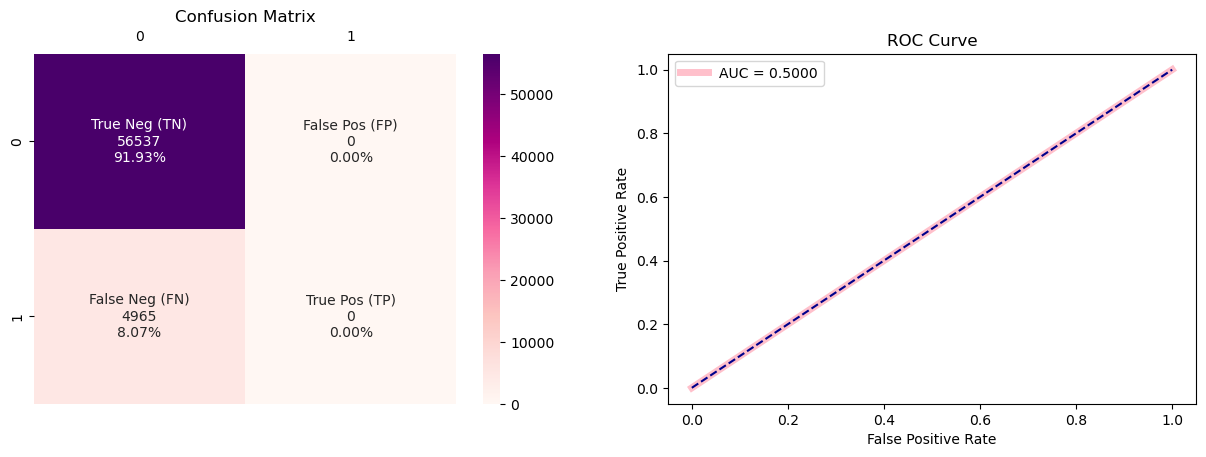

True negative   =  56537
False positive  =  0
False negative  =  4965
True positive   =  0
AUC : 0.5000
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Modele  Accuracy  AUC  Recall class 1   F1  fbeta  TP  \
0  Model_Dummy_Classifier  0.919271  0.5             0.0  0.0    0.0   0   

   Precision    FN  score Gain  train_time  predict_time  
0        0.0  4965    0.556065    4.292674      1.057134

time: 11.6 s (started: 2023-09-28 13:02:41 +00:00)


In [46]:
classifier_model = DummyClassifier(random_state = RANDOM_SEED)
ModelName        = 'Model_Dummy_Classifier'
run_name         = 'Model_Dummy_Classifier'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train, y_train, X_test, y_test)

results_models()

In [100]:
# model     = DummyClassifier(random_state = RANDOM_SEED)
# ModelName = 'Dummy Classifier'
# run_name  = 'Dummy Classifier'
# accuracy, _, recall, f1, fbeta_score, tp, precision, fn, score_gain, prediction, probability, execution_time, prediction_time=\
# model_classifier(model, ModelName, X_train_under, y_train_under)

# results_models()

time: 16 ms (started: 2023-09-22 12:25:35 +00:00)


Grâce à la matrice de confusion, on constate que le Dummy Classifier prédit bien seulement la classe 0 (client ne faisant pas défaut) et contient donc beaucoup de faux négatifs (mauvais client prédit bon client). C'est la raison pour laquelle il possède un score métier relativement faible (car ce dernier pénalise plus fortement les faux négatifs).

La plupart de nos scores sont à 0 puisque le modèle ne prédit aucune valeur positive. Les scores sont donc estimés à 0 puisque cela engendre une division par 0.

On constate que l'AUC est de 0.5 comme c'est le cas pour les modèles baseline.

Score métier maximum : 1.12
Threshold optimal    : 0.5


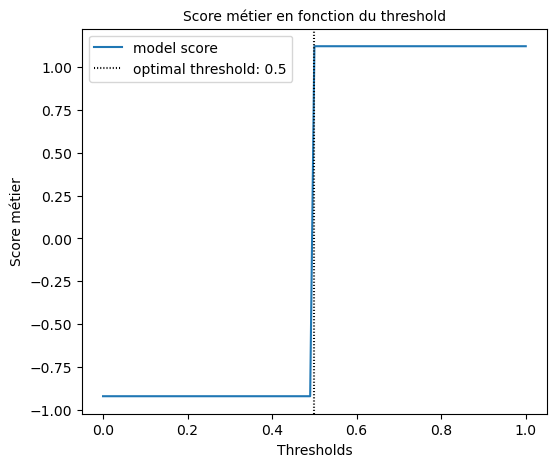

time: 890 ms (started: 2023-09-22 12:32:38 +00:00)


In [106]:
score_metier_max(probability[:, 1], y_test, verbose=True)

## <a id="6.2">6.2 Logistic Regression </a>

Exécution en cours ....

Qualité de la classification Model_LogisticRegression 
 
L'accuracy score est de      : 0.69172
Le score de précision est de : 0.16305
Le score recall est de       : 0.68197
Le score f1 est de           : 0.26317
Le score AUC est de          : 0.7519758994996208


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             39156 (TN)             17381 (FP)
Real Positive (1)              1579 (FN)              3386 (TP)

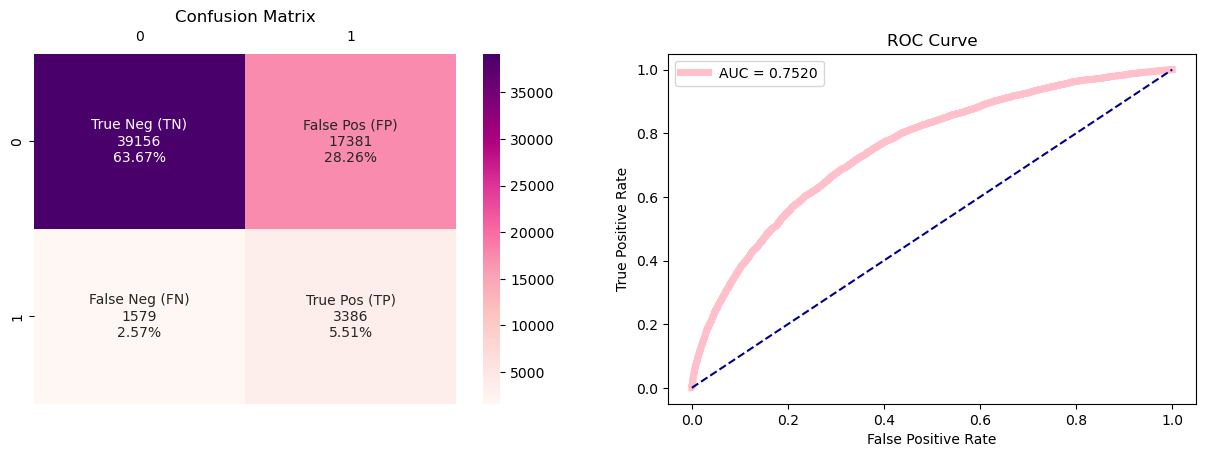

True negative   =  39156
False positive  =  17381
False negative  =  1579
True positive   =  3386
AUC : 0.7520
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56537
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.53     61502
weighted avg       0.90      0.69      0.76     61502



Modele  Accuracy       AUC  Recall class 1        F1  \
0  Model_LogisticRegression  0.691717  0.751976        0.681974  0.263174   

      fbeta    TP  Precision    FN  score Gain  train_time  predict_time  
0  0.416718  3386   0.163047  1579    0.687868    7.234787      1.064942

time: 18 s (started: 2023-09-22 12:33:19 +00:00)


In [107]:
classifier_model = LogisticRegression(max_iter=1500, random_state=RANDOM_STATE)
ModelName        = f'Model_{classifier_model.__class__.__name__}'
run_name         = f'Model_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train, y_train, X_test, y_test)

results_models()

In [105]:
# model     = LogisticRegression(max_iter=1000, random_state = RANDOM_SEED)
# ModelName = 'Logistic Regression'
# run_name  = 'Logistic Regression'
# accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, prediction, probability, execution_time, prediction_time=\
# model_classifier(model, ModelName, X_train, y_train)
# results_models()

time: 0 ns (started: 2023-09-22 12:29:39 +00:00)


Le score métier est nettement plus élevé à 0.68.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. Le modèle présente cependant une grande quantité de FP.

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision. 

On constate que le score ROC AUC est amélioré par rapport à la baseline et est de 0.75.

Score métier maximum : 3.59
Threshold optimal    : 0.5700000000000001


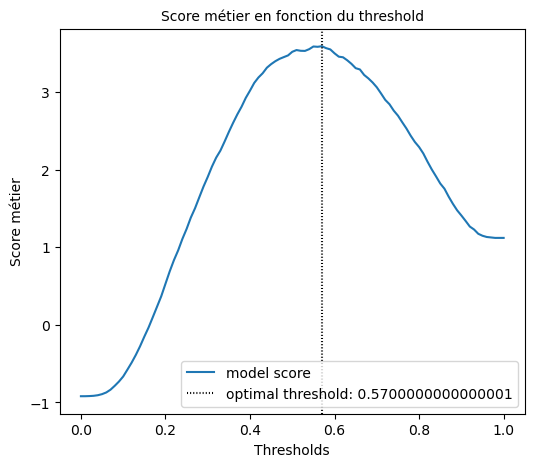

time: 1 s (started: 2023-09-22 12:33:38 +00:00)


In [108]:
score_metier_max(probability[:, 1], y_test, verbose=True)

Le score métier semble optimal quand le seuil est fixé à 0.56, cependant l'augmentation est minime.

## <a id="6.2">6.3 SVC (Support Vector Classifier) </a>

Exécution en cours ....

Qualité de la classification Model_SVC 
 
L'accuracy score est de      : 0.68899
Le score de précision est de : 0.16299
Le score recall est de       : 0.68983
Le score f1 est de           : 0.26368
Le score AUC est de          : 0.752175905765959


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             38949 (TN)             17588 (FP)
Real Positive (1)              1540 (FN)              3425 (TP)

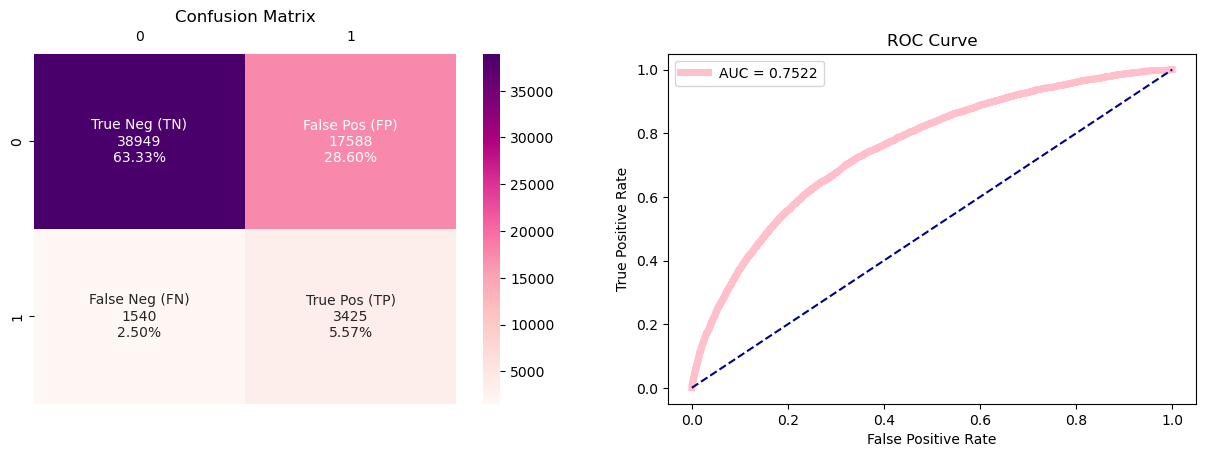

True negative   =  38949
False positive  =  17588
False negative  =  1540
True positive   =  3425
AUC : 0.7522
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56537
           1       0.16      0.69      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.53     61502
weighted avg       0.90      0.69      0.76     61502



Modele  Accuracy       AUC  Recall class 1        F1     fbeta    TP  \
0  Model_SVC  0.688986  0.752176        0.689829  0.263685  0.418981  3425   

   Precision    FN  score Gain   train_time  predict_time  
0   0.162994  1540    0.689319  2533.136927    300.204419

time: 1h 34min 13s (started: 2023-09-22 12:33:39 +00:00)


In [109]:
classifier_model = SVC(random_state = RANDOM_STATE, probability=True)
ModelName        = f'Model_{classifier_model.__class__.__name__}'
run_name         = f'Model_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train, y_train, X_test, y_test)

results_models()

Le score métier est légèrement dégradé par rapport à la regression logistique à 0.39, mais bien supérieur à la baseline.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. Le modèle présente cependant une grande quantité de FP.

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision.

On constate que le score ROC AUC est amélioré par rapport à la baseline et est de 0.69.

Score métier maximum : 3.64
Threshold optimal    : 0.56


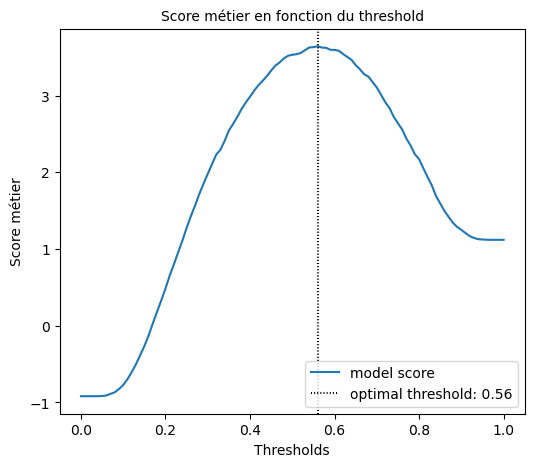

time: 1.16 s (started: 2023-09-22 14:07:52 +00:00)


In [110]:
score_metier_max(probability[:, 1], y_test, verbose=True)

Le score métier semble optimal quand le seuil est fixé à 0.53, cependant l'augmentation est minime.

## <a id="6.4">6.4 Decision Tree</a>

Exécution en cours ....

Qualité de la classification Model_DecisionTreeClassifier 
 
L'accuracy score est de      : 0.58629
Le score de précision est de : 0.11136
Le score recall est de       : 0.59094
Le score f1 est de           : 0.1874
Le score AUC est de          : 0.5884091839010114


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             33124 (TN)             23413 (FP)
Real Positive (1)              2031 (FN)              2934 (TP)

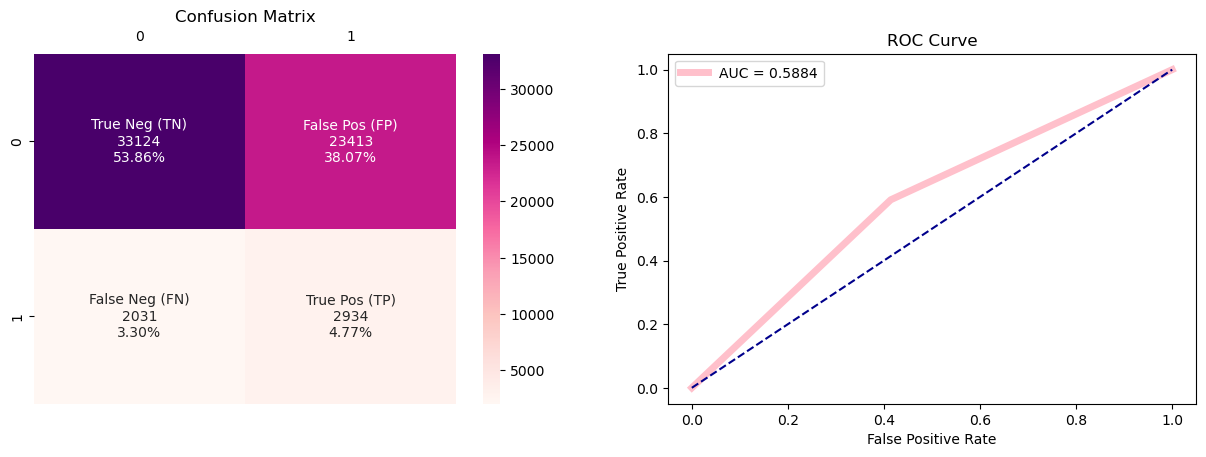

True negative   =  33124
False positive  =  23413
False negative  =  2031
True positive   =  2934
AUC : 0.5884
              precision    recall  f1-score   support

           0       0.94      0.59      0.72     56537
           1       0.11      0.59      0.19      4965

    accuracy                           0.59     61502
   macro avg       0.53      0.59      0.45     61502
weighted avg       0.88      0.59      0.68     61502



Modele  Accuracy       AUC  Recall class 1        F1  \
0  Model_DecisionTreeClassifier   0.58629  0.588409        0.590937  0.187404   

      fbeta    TP  Precision    FN  score Gain  train_time  predict_time  
0  0.317484  2934    0.11136  2031    0.588126   14.551581      0.949493

time: 32.4 s (started: 2023-09-22 14:07:53 +00:00)


In [111]:
classifier_model = DecisionTreeClassifier(random_state = RANDOM_STATE)
ModelName        = f'Model_{classifier_model.__class__.__name__}'
run_name         = f'Model_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train, y_train, X_test, y_test)

results_models()

Le score métier est dégradé par rapport à la regression logistique à 0.21, mais reste plus élevé que la baseline.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. Le modèle présente cependant une grande quantité de FP.

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision.

On constate que le score ROC AUC est légèrement amélioré par rapport à la baseline et est de 0.59.

Score métier maximum : 1.70
Threshold optimal    : 0.0


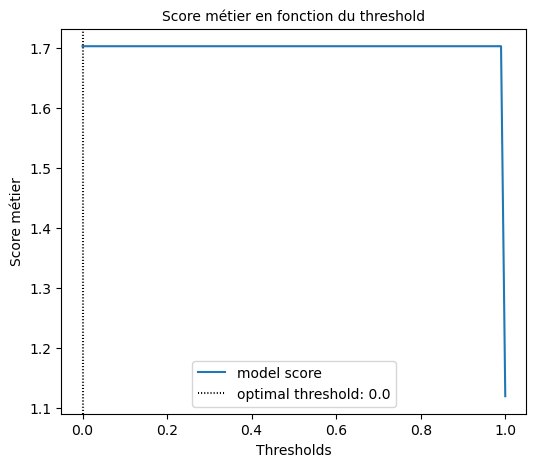

time: 1.38 s (started: 2023-09-22 14:08:25 +00:00)


In [112]:
score_metier_max(probability[:, 1], y_test, verbose=True)

On constate que peu importe le seuil, le score métier reste le même avec ce modèle.

## <a id="6.5">6.5 Random Forest Classifier </a>

Exécution en cours ....

Qualité de la classification Model_RandomForestClassifier 
 
L'accuracy score est de      : 0.69138
Le score de précision est de : 0.16053
Le score recall est de       : 0.66747
Le score f1 est de           : 0.25882
Le score AUC est de          : 0.7405345991550133


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             39207 (TN)             17330 (FP)
Real Positive (1)              1651 (FN)              3314 (TP)

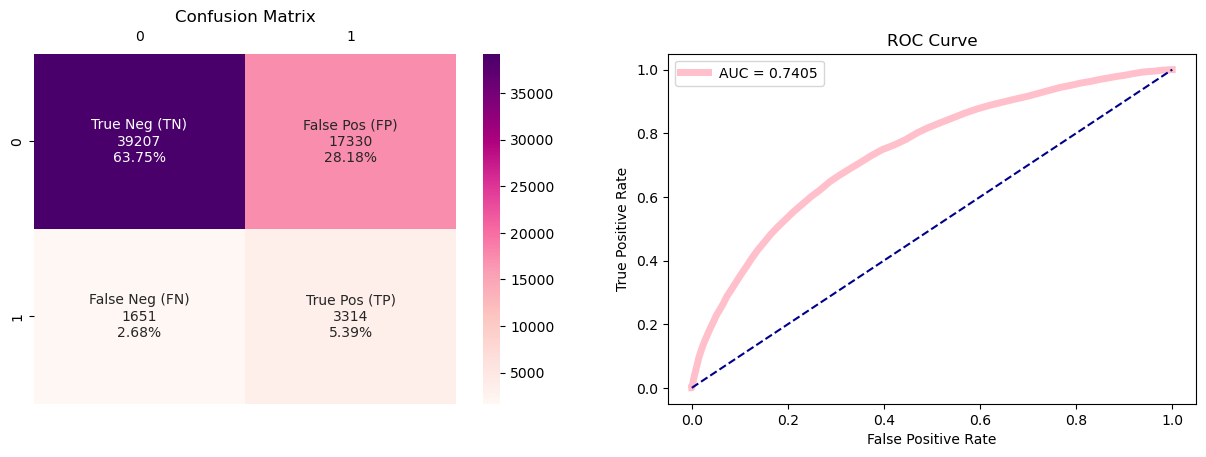

True negative   =  39207
False positive  =  17330
False negative  =  1651
True positive   =  3314
AUC : 0.7405
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56537
           1       0.16      0.67      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.68      0.53     61502
weighted avg       0.90      0.69      0.76     61502



Modele  Accuracy       AUC  Recall class 1        F1  \
0  Model_RandomForestClassifier  0.691376  0.740535        0.667472  0.258815   

      fbeta    TP  Precision    FN  score Gain  train_time  predict_time  
0  0.409095  3314   0.160531  1651    0.681932   98.769776       3.56124

time: 3min 20s (started: 2023-09-22 14:08:27 +00:00)


In [113]:
classifier_model = RandomForestClassifier(random_state = RANDOM_SEED)
ModelName        = f'Model_{classifier_model.__class__.__name__}'
run_name         = f'Model_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train, y_train, X_test, y_test)

results_models()

Le score métier est légèrement dégradé par rapport à la regression logistique à 0.38.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. Le modèle présente cependant une grande quantité de FP.

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision. 

On constate que le score ROC AUC est amélioré par rapport à la baseline et est de 0.69.

Score métier maximum : 3.46
Threshold optimal    : 0.53


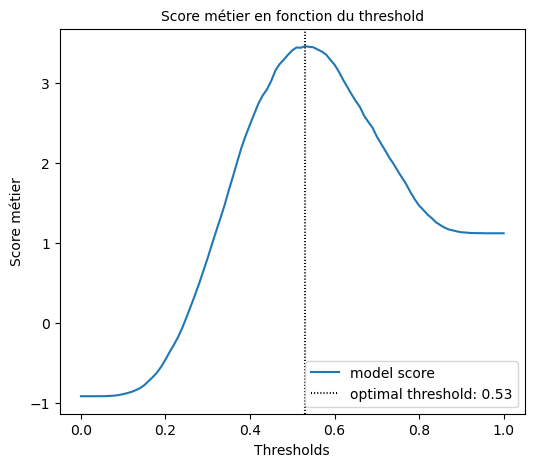

time: 1.27 s (started: 2023-09-22 14:11:47 +00:00)


In [114]:
score_metier_max(probability[:, 1], y_test, verbose=True)

Le score métier semble optimal quand le seuil est fixé à 0.52, cependant l'augmentation est minime.

## <a id="6.6">6.6 XGBoost Classifier </a>

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Exécution en cours ....



is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Qualité de la classification Model_XGBClassifier 
 
L'accuracy score est de      : 0.68793
Le score de précision est de : 0.1604
Le score recall est de       : 0.67674
Le score f1 est de           : 0.25933
Le score AUC est de          : 0.7456651661832698


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             38949 (TN)             17588 (FP)
Real Positive (1)              1605 (FN)              3360 (TP)

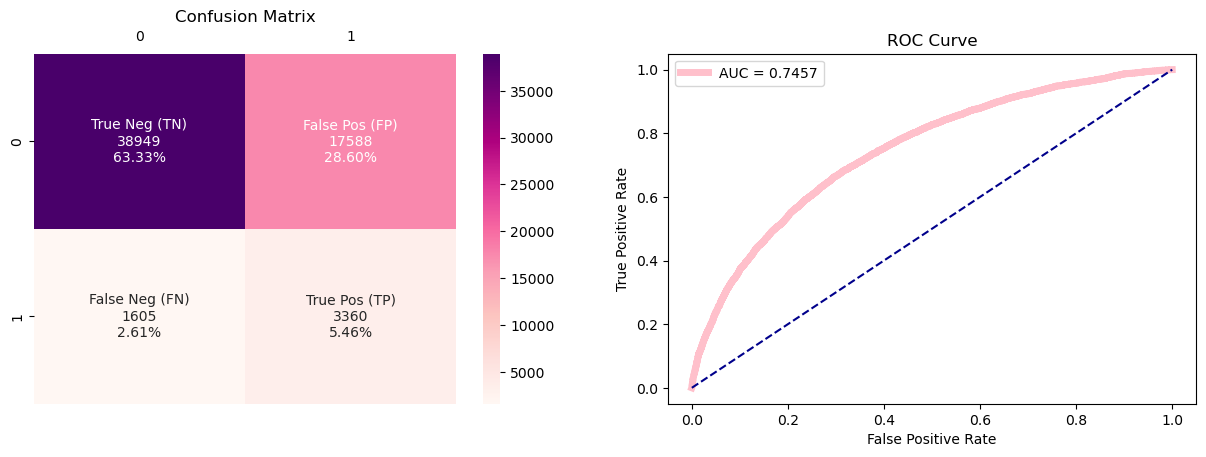

True negative   =  38949
False positive  =  17588
False negative  =  1605
True positive   =  3360
AUC : 0.7457
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56537
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.68      0.53     61502
weighted avg       0.90      0.69      0.76     61502



Modele  Accuracy       AUC  Recall class 1        F1  \
0  Model_XGBClassifier  0.687929  0.745665        0.676737  0.259329   

      fbeta    TP  Precision    FN  score Gain  train_time  predict_time  
0  0.411684  3360   0.160397  1605    0.683507   10.105386      1.399076

time: 24.6 s (started: 2023-09-22 14:11:49 +00:00)


In [115]:
classifier_model = XGBClassifier(random_state = RANDOM_SEED)
ModelName        = f'Model_{classifier_model.__class__.__name__}'
run_name         = f'Model_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train, y_train, X_test, y_test)

results_models()

Le score métier est légèrement plus élevé par rapport à Random Forest à 0.39.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. Le modèle présente cependant une grande quantité de FP.

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision. 

On constate que le score ROC AUC est amélioré par rapport à la baseline et est de 0.70.

Score métier maximum : 3.49
Threshold optimal    : 0.5700000000000001


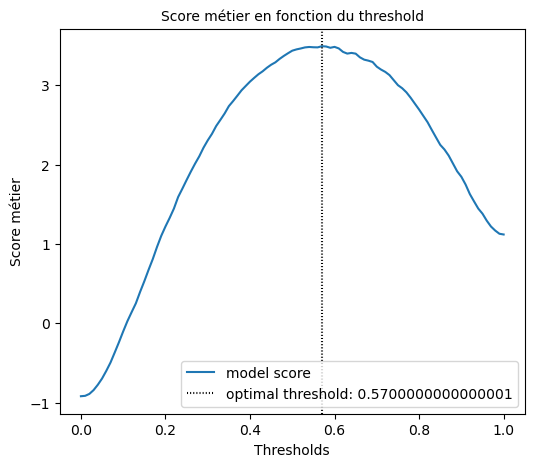

time: 1.03 s (started: 2023-09-22 14:12:13 +00:00)


In [116]:
score_metier_max(probability[:, 1], y_test, verbose=True)

Le score métier semble optimal quand le seuil est fixé à 0.55.

## <a id="6.7">6.7 Light GBM </a>

Exécution en cours ....

Qualité de la classification Model_LGBMClassifier 
 
L'accuracy score est de      : 0.69981
Le score de précision est de : 0.16934
Le score recall est de       : 0.69607
Le score f1 est de           : 0.2724
Le score AUC est de          : 0.7651805666354972


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             39584 (TN)             16953 (FP)
Real Positive (1)              1509 (FN)              3456 (TP)

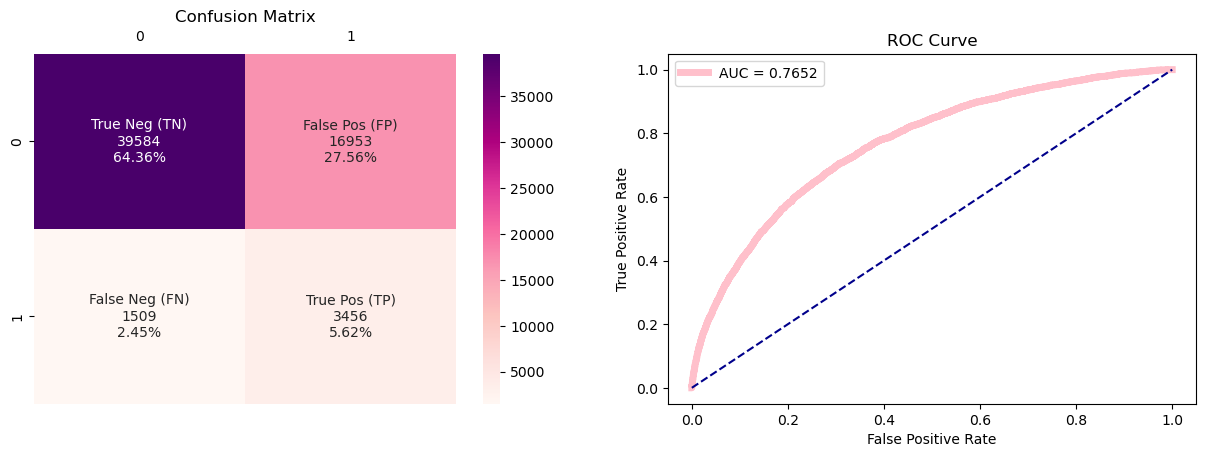

True negative   =  39584
False positive  =  16953
False negative  =  1509
True positive   =  3456
AUC : 0.7652
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56537
           1       0.17      0.70      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.70      0.54     61502
weighted avg       0.90      0.70      0.77     61502



Modele  Accuracy       AUC  Recall class 1        F1  \
0  Model_LGBMClassifier  0.699815  0.765181        0.696073  0.272405   

      fbeta    TP  Precision    FN  score Gain  train_time  predict_time  
0  0.429114  3456   0.169337  1509    0.698336     6.23322      1.624582

time: 16.7 s (started: 2023-09-22 14:12:14 +00:00)


In [117]:
classifier_model = LGBMClassifier(random_state = RANDOM_SEED)
ModelName        = f'Model_{classifier_model.__class__.__name__}'
run_name         = f'Model_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(classifier_model, ModelName, run_name,  X_train, y_train, X_test, y_test)

results_models()

Le score métier est légèrement plus élevé par rapport à XGBoots à 0.41.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. Le modèle présente cependant une grande quantité de FP.

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision. 

On constate que le score ROC AUC est amélioré par rapport à la baseline et est de 0.71.

Score métier maximum : 3.79
Threshold optimal    : 0.5700000000000001


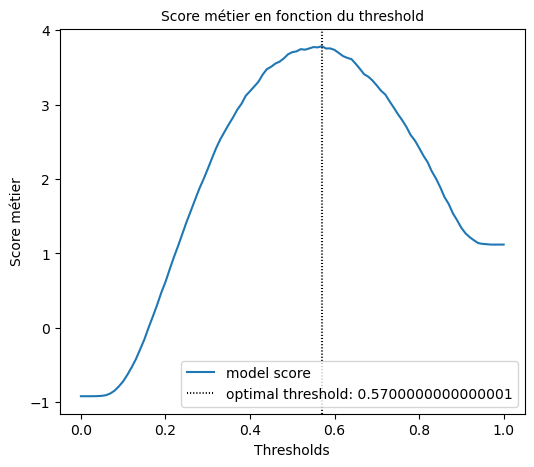

time: 1.02 s (started: 2023-09-22 14:12:48 +00:00)


In [119]:
score_metier_max(probability[:, 1], y_test, verbose=True)

### Bilan

In [123]:
model_performance = pd.concat(models_perf, axis=0)
# Triez le DataFrame en utilisant sort_values
# model_performance.sort_values(by        = ['AUC', 'TP', 'F1', 'Recall class 1', 'FN'],
#                               ascending = [True,   True, True, True,             False],
#                              inplace    = True,)
model_performance.sort_values(by        = ['Recall class 1','AUC', 'score Gain', 'FN'],
                              ascending = [False,            False,  False,        True],
                             inplace    = True, )
# revoir les index
model_performance = model_performance.loc[model_performance.Modele.str.contains('Model', case=False),:].drop_duplicates()
model_performance.reset_index(drop=True, inplace=True) 
model_performance

Modele  Accuracy       AUC  Recall class 1        F1  \
0          Model_LGBMClassifier  0.699815  0.765181        0.696073  0.272405   
1          Model_LGBMClassifier  0.699815  0.765181        0.696073  0.272405   
2                     Model_SVC  0.688986  0.752176        0.689829  0.263685   
3      Model_LogisticRegression  0.691717  0.751976        0.681974  0.263174   
4           Model_XGBClassifier  0.687929  0.745665        0.676737  0.259329   
5  Model_RandomForestClassifier  0.691376  0.740535        0.667472  0.258815   
6  Model_DecisionTreeClassifier  0.586290  0.588409        0.590937  0.187404   
7        Model_Dummy_Classifier  0.919271  0.500000        0.000000  0.000000   

      fbeta    TP  Precision    FN  score Gain   train_time  predict_time  
0  0.429114  3456   0.169337  1509    0.698336     6.136364      1.406532  
1  0.429114  3456   0.169337  1509    0.698336     6.233220      1.624582  
2  0.418981  3425   0.162994  1540    0.689319  2533.136927    300.204419  
3  0.416718  3386   0.163047  1579    0.687868     7.234787      1.064942  
4  0.411684  3360   0.160397  1605    0.683507    10.105386      1.399076  
5  0.409095  3314   0.160531  1651    0.681932    98.769776      3.561240  
6  0.317484  2934   0.111360  2031    0.588126    14.551581      0.949493  
7  0.000000     0   0.000000  4965    0.556065     4.237755      0.939791

time: 15 ms (started: 2023-09-22 14:53:24 +00:00)


In [126]:
columns_to_highlight_max = ['Accuracy', 'AUC', 'Recall class 1', 'F1', 'fbeta',  'Precision', 'score Gain']  # Colonnes pour mettre en couleur la valeur maximale en rouge
columns_to_highlight_min = ['FN']  # Colonnes pour mettre en couleur la valeur minimale en bleu

styled_model_df = model_performance.iloc[0:,:].style.apply(lambda x: highlight_max_and_min(x, x.name), axis=0)
styled_model_df

time: 15 ms (started: 2023-09-22 14:56:18 +00:00)


In [ ]:
model_performance.to_csv(f'{OUT_FOLDER}/model_performances.csv', index=False)

### Optimisation du modèle

In [47]:
mlflow.set_experiment('Model optimal')

<Experiment: artifact_location='mlflow-artifacts:/536811364292778427', creation_time=1695421698836, experiment_id='536811364292778427', last_update_time=1695421698836, lifecycle_stage='active', name='Model optimal', tags={}>

time: 16 ms (started: 2023-09-28 13:03:01 +00:00)


In [45]:
def model_best_params(model, param_grid, score, ModelName, run_name, X_train, y_train, X_test, y_test):
    classifier_grid        = GridSearchCV(model, param_grid, 
                                          scoring = score, 
                                          cv = 4, n_jobs = -1, verbose = 1)  
    classifier_grid.fit(X_train, y_train)

    params_name            = f'best_params_{model.__class__.__name__}'
    globals()[params_name] = classifier_grid.best_params_

    print("  ")
    print("Nom du modèle         :", ModelName)
    print("best params name      :", params_name)
    print("best params values    :", globals()[params_name])
    print(f"Score {score} Train  :", classifier_grid.best_score_)
    
    # Injectez les meilleurs paramètres dans le modèle
    model.set_params(**globals()[params_name])
    model.fit(X_train, y_train)
    
    # Sauvegarde du modèle
    with open(f'{MODEL_FOLDER}/{ModelName}.pkl', 'wb') as model_file:
        pickle.dump(model, model_file)
    
    #  MLFLOW
    model_mlflow(model, ModelName, run_name, X_train, y_train, X_test, y_test)
        
    return model, globals()[params_name]

time: 0 ns (started: 2023-10-28 20:14:15 +00:00)


In [37]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {
        'n_estimators'  : [50, 100, 150, 200, 500, 1000, 1500], # np.arange(50, 1500, 200),
        'max_depth'     : [-1, 2, 5, 7],
        'num_leaves'    : [2, 7, 10, 30, 60, 100],
        'learning_rate' : [0.001, 0.01, 0.1, 0.5, 1],
        }
score      = 'roc_auc'
model      = LGBMClassifier(objective='binary', random_state = RANDOM_STATE)
ModelName  = f'{model.__class__.__name__}'
run_name   = f'{model.__class__.__name__}'

globals()[f'best_params_{model.__class__.__name__}'] = \
model_best_params(model, param_grid, score, X_train, y_train)

Fitting 4 folds for each of 700 candidates, totalling 2800 fits
Nom du modèle         : LGBMClassifier
best params name      : best_params_LGBMClassifier
best params values    : {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1500, 'num_leaves': 7}
Score roc_auc Train  : 0.7686970729822227
time: 7h 49min 43s (started: 2023-09-22 22:30:57 +00:00)


In [46]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {
        'n_estimators'  : [100, 500, 1000, 1500], # np.arange(50, 1500, 200),
        'max_depth'     : [-1, 2, 5, 20],
        'num_leaves'    : [2, 7, 50],
        'learning_rate' : [0.01, 0.1, 0.2],
        }
score      = 'roc_auc'
model      = LGBMClassifier(objective='binary', random_state = RANDOM_STATE)
ModelName  = f'best_{model.__class__.__name__}'
run_name   = f'best_{model.__class__.__name__}'
globals()[model], globals()[f'best_params_{model.__class__.__name__}'] = \
model_best_params(model, param_grid, score, ModelName, run_name, X_train, y_train, X_test, y_test)

Fitting 4 folds for each of 144 candidates, totalling 576 fits
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.311192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17906
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  
Nom du modèle         : best_LGBMClassifier
best params name      : best_params_LGBMClassifier
best params values    : {'learning_rate':

UnsupportedModelRegistryStoreURIException:  Model registry functionality is unavailable; got unsupported URI 'C:/Users/Fane0763/OpenClassroom/OC Projet 7/out_put/mlflowruns' for model registry data storage. Supported URI schemes are: ['', 'file', 'databricks', 'databricks-uc', 'http', 'https', 'postgresql', 'mysql', 'sqlite', 'mssql']. See https://www.mlflow.org/docs/latest/tracking.html#storage for how to run an MLflow server against one of the supported backend storage locations.

time: 3h 40min 32s (started: 2023-10-28 20:14:29 +00:00)


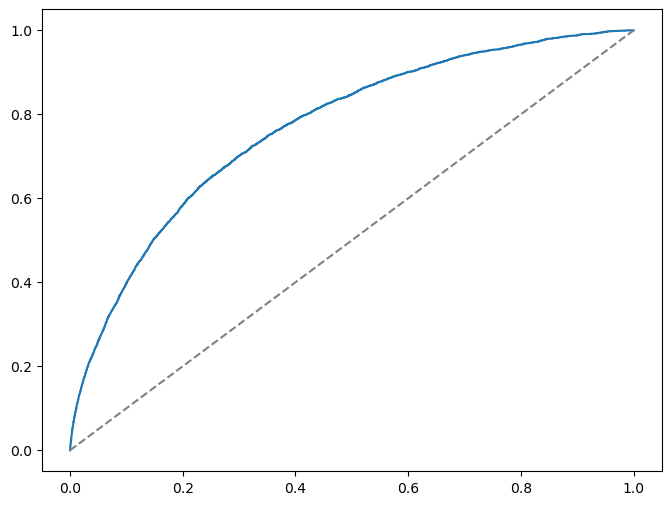

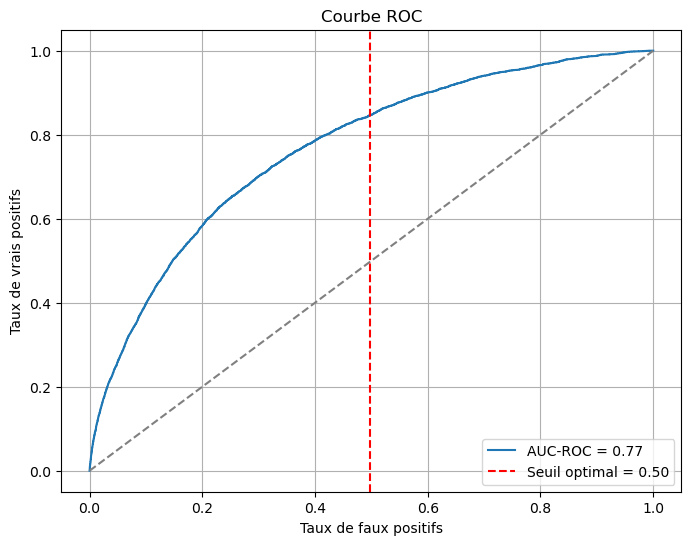

Seuil optimal: 0.50
time: 2.08 s (started: 2023-09-28 14:34:46 +00:00)


In [55]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Supposons que vous avez déjà entraîné votre modèle LGBMClassifier et obtenu des prédictions de probabilité
# sur l'ensemble de validation ou de test.
y_true = y_test  # Vos vraies étiquettes
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilités de classe positive

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Calcul de l'AUC-ROC
auc_roc = roc_auc_score(y_true, y_prob)

# Trouver le seuil optimal
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Afficher la courbe ROC avec le seuil optimal
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Seuil optimal = {optimal_threshold:.2f}')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"Seuil optimal: {optimal_threshold:.2f}")


In [57]:
y_true = y_test  # Vos vraies étiquettes
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilités de classe positive
# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

time: 1.83 s (started: 2023-09-28 14:40:31 +00:00)


Score métier maximum : 3.85
Threshold optimal    : 0.55


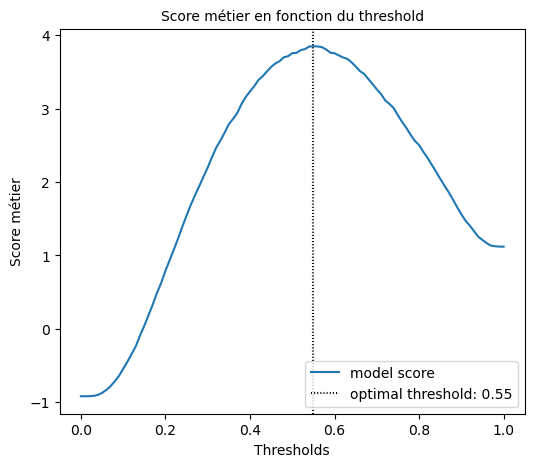

time: 953 ms (started: 2023-09-28 14:40:32 +00:00)


In [58]:
score_metier_max(y_prob, y_test, verbose=True)

In [59]:
model

LGBMClassifier(max_depth=2, n_estimators=1000, num_leaves=7, objective='binary',
               random_state=42)

time: 15 ms (started: 2023-09-28 14:40:41 +00:00)


---------
**Notre modèle final** est donc un **Light GBM** avec les paramètres `max_depth=2, n_estimators=1000, num_leaves=7, objective='binary',  random_state=42` et un seuil à **0.55**. 

In [60]:
globals()[f'best_params_{model.__class__.__name__}']

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000, 'num_leaves': 7}

time: 15 ms (started: 2023-09-28 14:40:46 +00:00)


In [61]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'num_leaves': 7,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

time: 15 ms (started: 2023-09-28 14:40:48 +00:00)


In [64]:
import joblib

def save_model(model, ModelName, ModelFolder):
    """
    Enregistre un modèle scikit-learn au format Joblib (.joblib) dans un dossier spécifié.

    Args:
        model: Le modèle scikit-learn que vous souhaitez enregistrer.
        ModelName (str): Le nom que vous souhaitez donner au modèle enregistré (sans l'extension .joblib).
        ModelFolder (str): Le chemin du dossier où vous souhaitez enregistrer le modèle.

    Returns:
        str: Un message de réussite ou d'erreur pour indiquer si l'enregistrement a réussi.

    Example:
        # Définissez le chemin du dossier où vous souhaitez enregistrer le modèle
        MODEL_FOLDER = '/chemin/vers/le/dossier'

        # Appel de la fonction pour enregistrer le modèle
        result_message = save_model(model, 'nom_du_modele', MODEL_FOLDER)
        print(result_message)
    """
    try:
        joblib.dump(model, f'{ModelFolder}/{ModelName}.joblib')
        return f"Modèle {ModelFolder}/{ModelName}.joblib enregistré avec succès."
    except Exception as e:
        return f"Erreur lors de l'enregistrement du modèle {ModelFolder}/{ModelName}.joblib : " + str(e)

    
save_model(model, ModelName, ModelFolder = MODEL_FOLDER)

'Modèle C:/Users/Fane0763/OpenClassroom/OC Projet 7/Models/best_LGBMClassifier.joblib enregistré avec succès.'

time: 31 ms (started: 2023-09-28 14:50:52 +00:00)


In [65]:
model

LGBMClassifier(max_depth=2, n_estimators=1000, num_leaves=7, objective='binary',
               random_state=42)

time: 0 ns (started: 2023-09-28 14:51:03 +00:00)


In [66]:
import joblib

def load_model(ModelName, ModelFolder):
    """
    Charge un modèle scikit-learn à partir d'un fichier au format Joblib (.joblib) dans un dossier spécifié.

    Args:
        ModelName (str): Le nom du modèle à charger (sans l'extension .joblib).
        ModelFolder (str): Le chemin du dossier où se trouve le modèle.

    Returns:
        object: Le modèle chargé depuis le fichier .joblib.
    """
    try:
        model_path = f"{ModelFolder}/{ModelName}.joblib"
        loaded_model = joblib.load(model_path)
        return loaded_model
    except Exception as e:
        return f"Erreur lors du chargement du modèle {ModelName}.joblib : " + str(e)
    
model1 = load_model(ModelName, ModelFolder = MODEL_FOLDER)
model1

LGBMClassifier(max_depth=2, n_estimators=1000, num_leaves=7, objective='binary',
               random_state=42)

time: 15 ms (started: 2023-09-28 14:55:01 +00:00)


In [69]:
import joblib

# Charger le modèle depuis le fichier .pkl
model = joblib.load(f'{MODEL_FOLDER}/best_LGBMClassifier.joblib')

predictions = model.predict(X_test) 
print(len(predictions))
predictions


61502


array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

time: 1.7 s (started: 2023-09-28 14:56:13 +00:00)


### Définition de pipeline

On ne peut pas utiliser les samplers dans `sklearn.pipeline.Pipeline`,
car sklearn pipeline va undersample ou oversample non seulement sur x_train, mais aussi sur **x_test**.

Il faut utiliser les pipelines de imblearn, qui applique une strategie de under ou oversampling **seulement sur le jeu de données d'entrainement**, mais pas le jeu de données test . Par exemple:

```python
lr_pipeline = imbpipeline.Pipeline(steps=[
    ('preprocess',numeric_pipeline),
    ('sampling', undersampler),
    ('feat_select','passthrough'),
   ('clf', LogisticRegression(class_weight=None)),
])
```

L'avantage d'utiliser un pipeline, c'est qu'on peut faire des gridsearch sur chaque un des **steps**, par exemple, en modifiant le sampler:

```python
param_grid = {
    'sampling': [undersampler, oversampler, smote_auto, smote_tomek],
    'clf__alpha': np.logspace(-5,3,20)
}

```

```python
from imblearn import pipeline as imbpipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
# from sklearn.svm import LinearSVC
# test model pipeline avec un classifier rapide
from sklearn.linear_model import RidgeClassifier


def create_model(
    sampling=SMOTE(random_state=RANDOM_SEED),
    preprocessor=numeric_pipeline,
    feature_selector=SelectKBest(score_func=f_classif, k=50),
    classifier=RidgeClassifier()
):
    model = imbpipeline.Pipeline(steps=[
        ('sampling', sampling),
        ('preprocess', preprocessor),
        ('feat_select', feature_selector),
        ('clf', classifier)
    ])
    # ('feat_select', SelectFromModel(LGBMClassifier, max_features=100)),
    return model


test_model = create_model(preprocessor=preprocessor)
test_model

```

In [70]:
datasets, titles = load_csv_files_as_dataframes(OUT_FOLDER)

Chargement...:  71%|██████████████████████████████████████████████▍                  | 10/14 [00:22<00:08,  2.21s/file]

time: 22.1 s (started: 2023-09-28 14:56:29 +00:00)


In [71]:
y_train = np.squeeze(y_train)
y_test  = np.squeeze(y_test)

time: 0 ns (started: 2023-09-28 14:58:42 +00:00)


In [72]:
# Sélectionnez automatiquement les colonnes de type float
num_cols = X_train.select_dtypes(include=[float]).columns
# num_cols = X_train.select_dtypes(['float64']).columns

# Créez un ColumnTransformer pour les colonnes numériques
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('simple_scale', StandardScaler()),
])

# Créez le pipeline final en utilisant le ColumnTransformer
numeric_pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers=[('num', num_transformer, num_cols),]))
])

numeric_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('simple_scale',
                                                                   StandardScaler())]),
                                                  Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'PREV_APP_CREDIT_PERC_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'DAYS_EMPLOYED_PERC',
       'APPROVED_DAYS_DECISION_MIN', 'APPROVED_AMT_ANNUITY_MEAN',
       'AMT_G...
       'APPROVED_DAYS_DECISION_MAX', 'APPROVED_APP_CREDIT_PERC_MAX',
       'APPROVED_AMT_APPLICATION_MEAN', 'APPROVED_AMT_ANNUITY_MIN',
       'APPROVED_AMT_ANNUITY_MAX', 'ANNUITY_INCOME_PERC', 'AMT_ANNUITY',
       'PREV_PRODUCT_COMBINATION_CardStreet_MEAN',
       'PREV_NAME_YIELD_GROUP_low_normal_MEAN',
       'PREV_NAME_TYPE_SUITE_nan_MEAN', 'PREV_NAME_PORTFOLIO_POS_MEAN',
       'PREV_NAME_PORTFOLIO_Cards_MEAN'],
      dtype='object'))]))])

time: 78 ms (started: 2023-09-28 14:58:44 +00:00)


In [74]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler

# Class passThrough
class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X
    
# Separation des colonnes (identifier les colonnes à Stantardiser)
numeric_columns = X_train.select_dtypes(include=[float]).columns
non_numeric_columns = list(set(X_train.columns)-set(numeric_columns))

# Transformations des colonnes
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('simple_scale', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('passthrough', PassthroughTransformer(), non_numeric_columns)
])

# Pipeline complet qui inclut l'équilibrage des classes, le prétraitement et le modèle
model_pipeline = imbpipeline(steps=[
    ('sampling', RandomUnderSampler(random_state=RANDOM_STATE)),  # Équilibrage des classes
    ('preprocess', preprocessor),  # Prétraitement
    ('clf', model)  # Modèle
])

time: 63 ms (started: 2023-09-28 14:59:56 +00:00)


In [75]:
model_pipeline.get_params()

{'memory': None,
 'steps': [('sampling', RandomUnderSampler(random_state=42)),
  ('preprocess',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('simple_scale',
                                                     StandardScaler())]),
                                    Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'PREV_APP_CREDIT_PERC_MEAN',
          'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'DAYS_EMPLOYED_PERC',
          'APPROVED_DAYS_DECISION_MIN', 'APPROVED_AMT_ANNUITY_MEAN',
          'AMT_GOODS_PRICE', 'AMT_CREDIT', 'REGION...
                                     'NAME_CONTRACT_TYPE_Revolvingloans',
                                     'NAME_EDUCATION_TYPE_Highereducation',
                                     'NAME_CONTRACT_TYPE_Cashloans',
                                     'REGION_RATING_CL

time: 31 ms (started: 2023-09-28 15:00:02 +00:00)


Exécution en cours ....

Qualité de la classification best_LGBMClassifier 
 
L'accuracy score est de      : 0.70303
Le score de précision est de : 0.17116
Le score recall est de       : 0.69708
Le score f1 est de           : 0.27484
Le score AUC est de          : 0.76898


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             39777 (TN)             16760 (FP)
Real Positive (1)              1504 (FN)              3461 (TP)

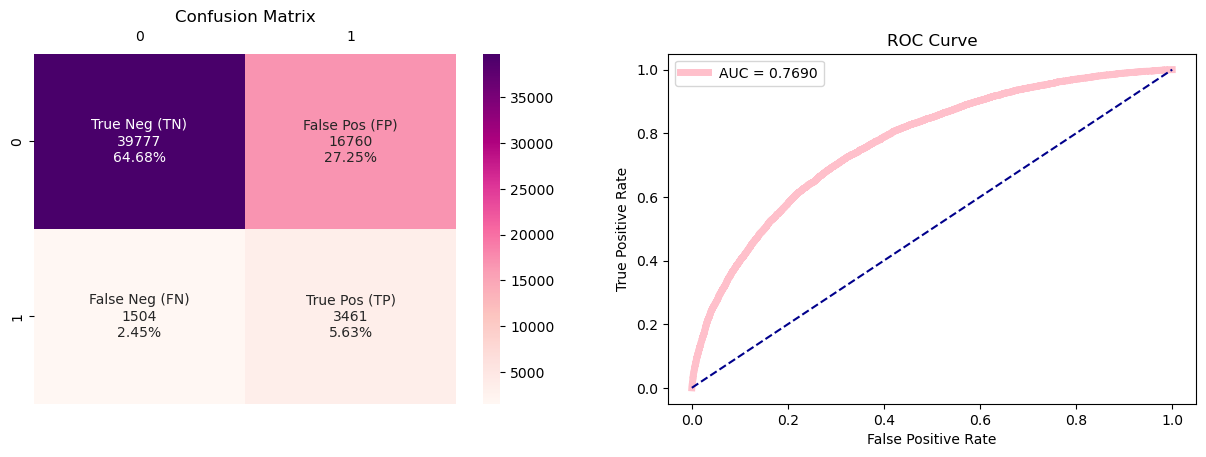

True negative   =  39777
False positive  =  16760
False negative  =  1504
True positive   =  3461
AUC : 0.7690
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56537
           1       0.17      0.70      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.70      0.54     61502
weighted avg       0.90      0.70      0.77     61502

time: 2min 22s (started: 2023-09-28 15:00:03 +00:00)


In [76]:
classifier_model = model
ModelName        = f'best_{classifier_model.__class__.__name__}'
run_name         = f'best_{classifier_model.__class__.__name__}'

globals()[ModelName], accuracy, AUC, recall, f1, fbeta_score, tp, precision, fn, score_gain, \
prediction, probability, execution_time, prediction_time = \
model_mlflow(model_pipeline, ModelName, run_name,  X_train, y_train, X_test, y_test)


In [77]:
save_model(globals()[ModelName], ModelName, ModelFolder = MODEL_FOLDER)


'Modèle C:/Users/Fane0763/OpenClassroom/OC Projet 7/Models/best_LGBMClassifier.joblib enregistré avec succès.'

time: 16 ms (started: 2023-09-28 15:03:48 +00:00)


In [80]:
print(best_params_LGBMClassifier)

save_model(model       = model_pipeline, 
           ModelName   = f'best_{classifier_model.__class__.__name__}_pipeline', 
           ModelFolder = MODEL_FOLDER)

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000, 'num_leaves': 7}


'Modèle C:/Users/Fane0763/OpenClassroom/OC Projet 7/Models/best_LGBMClassifier_pipeline.joblib enregistré avec succès.'

time: 15 ms (started: 2023-09-28 15:04:21 +00:00)


In [92]:
model_pipeline

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('simple_scale',
                                                                   StandardScaler())]),
                                                  Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'PREV_APP_CREDIT_PERC_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'DAYS_EMPLOYED_PERC',
       'APPROVED_DAYS_D...
                                                   'NAME_INCOME_TYPE_Pensioner',
                                                   'WALLSMATERIAL_MODE_Panel',
                                                   'NAME_EDUCATION_TYPE_Secondarysecondaryspecial',
                                                   'REGION_RATING_CLIENT',
                                                   'REG_REGION_NOT_LIVE_REGION',
                                                   'FLAG_OWN_CAR',
                                                   'OCCUPATION_TYPE_Drivers',
                                                   'CODE_GENDER',
                                                   'OCCUPATION_TYPE_LowskillLaborers'])])),
                ('clf',
                 LGBMClassifier(max_depth=2, n_estimators=1000, num_leaves=7,
                                objective='binary', random_state=42))])

time: 125 ms (started: 2023-09-28 15:13:36 +00:00)


In [82]:
best_LGBMClassifier 

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('simple_scale',
                                                                   StandardScaler())]),
                                                  Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'PREV_APP_CREDIT_PERC_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'DAYS_EMPLOYED_PERC',
       'APPROVED_DAYS_D...
                                                   'NAME_INCOME_TYPE_Pensioner',
                                                   'WALLSMATERIAL_MODE_Panel',
                                                   'NAME_EDUCATION_TYPE_Secondarysecondaryspecial',
                                                   'REGION_RATING_CLIENT',
                                                   'REG_REGION_NOT_LIVE_REGION',
                                                   'FLAG_OWN_CAR',
                                                   'OCCUPATION_TYPE_Drivers',
                                                   'CODE_GENDER',
                                                   'OCCUPATION_TYPE_LowskillLaborers'])])),
                ('clf',
                 LGBMClassifier(max_depth=2, n_estimators=1000, num_leaves=7,
                                objective='binary', random_state=42))])

time: 94 ms (started: 2023-09-28 15:04:26 +00:00)


## <font color='blue'>Importance des features </font>

### <font color='grey'>Features importance simple</font>

In [83]:
import mlflow
logged_model = 'runs:/1596a4f419cf4991a1bcbd049e52be6e/model'

# Load model as a PyFuncModel.
model = mlflow.pyfunc.load_model(logged_model)

# # Predict on a Pandas DataFrame.
# import pandas as pd
# loaded_model.predict(pd.DataFrame(data))

time: 641 ms (started: 2023-09-28 15:04:38 +00:00)


In [89]:
model =load_model(ModelName, ModelFolder = MODEL_FOLDER)
print(ModelName)

best_LGBMClassifier
time: 16 ms (started: 2023-09-28 15:09:51 +00:00)


In [93]:
best_LGBMClassifier.fit(X_train, y_train)

Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('simple_scale',
                                                                   StandardScaler())]),
                                                  Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'PREV_APP_CREDIT_PERC_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'DAYS_EMPLOYED_PERC',
       'APPROVED_DAYS_D...
                                                   'NAME_INCOME_TYPE_Pensioner',
                                                   'WALLSMATERIAL_MODE_Panel',
                                                   'NAME_EDUCATION_TYPE_Secondarysecondaryspecial',
                                                   'REGION_RATING_CLIENT',
                                                   'REG_REGION_NOT_LIVE_REGION',
                                                   'FLAG_OWN_CAR',
                                                   'OCCUPATION_TYPE_Drivers',
                                                   'CODE_GENDER',
                                                   'OCCUPATION_TYPE_LowskillLaborers'])])),
                ('clf',
                 LGBMClassifier(max_depth=2, n_estimators=1000, num_leaves=7,
                                objective='binary', random_state=42))])

time: 12.4 s (started: 2023-09-28 15:14:09 +00:00)


In [85]:
best_model=model
best_model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.lightgbm
  run_id: 1596a4f419cf4991a1bcbd049e52be6e

time: 0 ns (started: 2023-09-28 15:04:40 +00:00)


In [98]:
# Chargement des fichiers
X_train = load_pickle(file_path = f'{OUT_FOLDER}/X_train.pickle')
X_test  = load_pickle(file_path = f'{OUT_FOLDER}/X_test.pickle')
y_train = load_pickle(file_path = f'{OUT_FOLDER}/y_train.pickle')
y_test  = load_pickle(file_path = f'{OUT_FOLDER}/y_test.pickle')

time: 31 ms (started: 2023-09-28 15:17:00 +00:00)


In [99]:
import lightgbm as lgb
print("Version de LightGBM :", lgb.__version__)


Version de LightGBM : 3.3.5
time: 0 ns (started: 2023-09-28 15:17:02 +00:00)


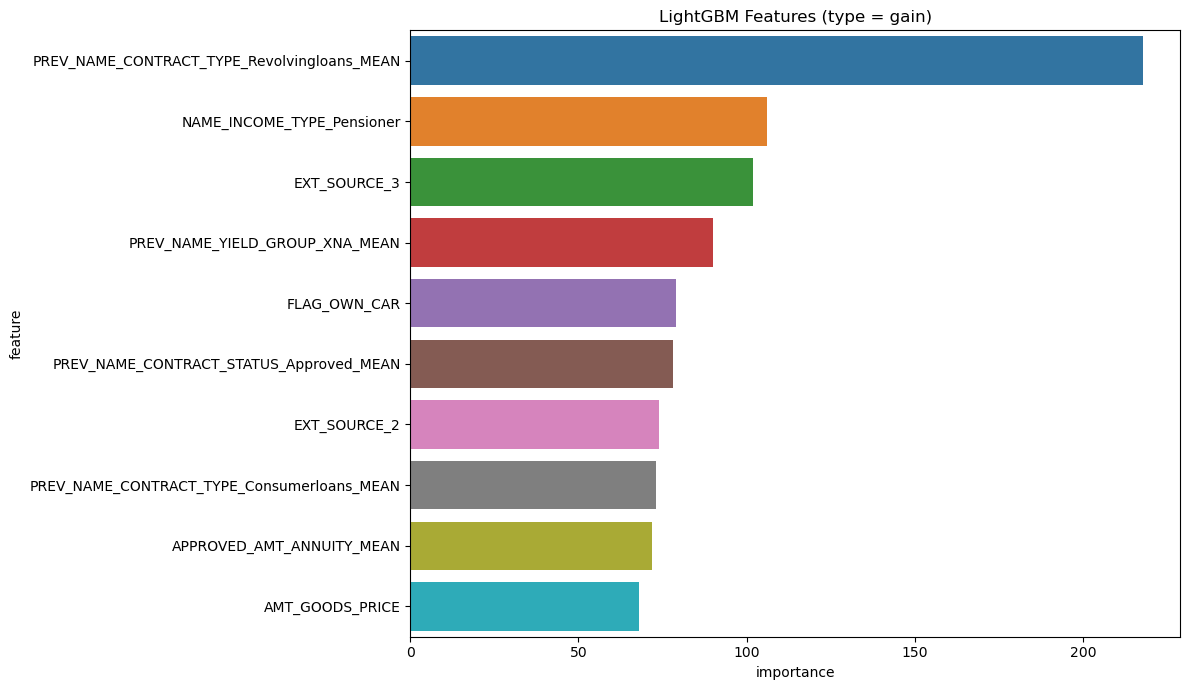

                                        feature  importance
56  PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN         218
22                   NAME_INCOME_TYPE_Pensioner         106
0                                  EXT_SOURCE_3         102
52               PREV_NAME_YIELD_GROUP_XNA_MEAN          90
75                                 FLAG_OWN_CAR          79
..                                          ...         ...
89                     APPROVED_AMT_ANNUITY_MAX           1
94                         REGION_RATING_CLIENT           0
86                 APPROVED_APP_CREDIT_PERC_MAX           0
82              BURO_CREDIT_TYPE_Microloan_MEAN           0
55      PREV_NAME_GOODS_CATEGORY_Furniture_MEAN           0

[100 rows x 2 columns]
time: 297 ms (started: 2023-09-28 15:17:04 +00:00)


In [100]:
# Accédez au modèle LightGBM dans le pipeline
lgb_model = best_LGBMClassifier.named_steps['clf']  # Remplacez 'clf' par le nom de l'étape du modèle dans votre pipeline

# Maintenant, accédez aux feature importances
importance_scores = lgb_model.feature_importances_


# Création du DataFrame d'importance des variables
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance_scores
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x="importance", y="feature", data=importance_df.sort_values(by="importance", ascending=False).head(10))
plt.title('LightGBM Features (type = gain)')
plt.tight_layout()
plt.show()

# Affichage du DataFrame d'importance des variables
print(importance_df)



In [102]:
# best_model.fit(X_train, y_train)

feature_imp = pd.DataFrame(sorted(zip(best_model.booster_.feature_importance(importance_type='gain'),
                                      X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 7))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
plt.title('LightGBM Features (type = gain)')
plt.tight_layout()
plt.show()

AttributeError: 'PyFuncModel' object has no attribute 'booster_'

time: 15 ms (started: 2023-09-28 15:17:18 +00:00)


Avec cette représentation, on peut dire que les features les plus importantes pour la prédiction d'accord d'un prêt sont les sources extérieures 2 et 3 qui sont les scores normalisés créés à partir d'une source de données externe. Ces scores pourraient regrouper différentes caractéristiques sur le paiement d'un crédit tel que le retard de paiement par exemple. Plus ces scores sont élevés et plus le client risque de ne pas voir sa demande de prêt accepté.
 
Nous avons le `PAY_MENT_RATE` et le nombre de jours depuis la naissance des clients (`DAYS_BIRTG`) donc leur âge joue un rôle important dans l'acceptation d'un crédit. 

### <font color='grey'> LIME </font>

LIME =Local Interpretable Model-Agnostic Explanations

LIME est une technique qui permet de créer un modèle simple autour de la prédiction que nous voulons expliquer et utilise ce modèle simple pour donner une explication. LIME peut être utilisé avec n'importe quel modèle de machine learning, pas seulement avec des arbres de décision ou des forêts aléatoires.

**L'idée de base de LIME est assez simple. Pour une prédiction donnée, LIME perturbe les entrées de la prédiction et essaie de comprendre comment ces perturbations affectent la sortie du modèle**. Les attributs qui affectent le plus la sortie lorsqu'ils sont perturbés sont considérés comme ayant une importance élevée pour cette prédiction spécifique.


In [158]:
#pip install lime
import lime
from lime import lime_tabular

# Création de l'explainer
explainer = lime_tabular.LimeTabularExplainer(X_train.values, 
                                              feature_names=X_train.columns.values.tolist(), 
                                              class_names=['0','1'], 
                                              verbose=True, 
                                              mode='classification')

time: 5.02 s (started: 2023-09-28 11:52:18 +00:00)


In [ ]:
# Choisissez un exemple spécifique à expliquer
i = 1
exp = explainer.explain_instance(X_test.values[i], best_model.predict_proba, num_features=5)

In [ ]:
# Afficher l'explication
exp.show_in_notebook(show_table=True)

### Shapley Values

La valeur de Shapley, dans le contexte de l'interprétation de modèles d'apprentissage automatique, permet d'évaluer l'impact de chaque caractéristique sur une prédiction donnée. **Elle fait cela en calculant la contribution moyenne de chaque caractéristique à la prédiction sur toutes les combinaisons possibles de caractéristiques**.

In [ ]:
#pip install shap
import shap
# Initialisation du Javascript
shap.initjs()

# Création de l'explainer
explainer = shap.TreeExplainer(model)

# Calcul des valeurs SHAP pour les instances de test
shap_values = explainer.shap_values(X_test)
print(shap_values.shape)
# Choisissez un exemple spécifique à expliquer
i = 1  # vous pouvez choisir l'indice de l'exemple que vous souhaitez expliquer
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:])


### <font color='grey'>Features importance SHAP</font>

Les valeurs de Shapley calculent l’importance d’une variable en comparant la sortie qu’un modèle peut prédire avec et sans cette variable. Cependant, étant donné que l’ordre dans lequel un modèle voit les variables peut affecter ses prédictions, cela se fait dans tous les ordres possibles, afin que les fonctionnalités soient comparées équitablement. Cette approche est inspirée de la théorie des jeux.

SHAP s’utilise pour expliquer un modèle existant. Prenant un cas de classification binaire construite avec un modèle sklearn. On entraine, tune et teste notre modèle. Ensuite on peut utiliser nos données et le modèle pour créer un modèle supplémentaire de SHAP qui explique notre modèle de classification.

Les valeurs Shap sont des tableaux d'une longueur correspondant au nombre de classes dans la cible. Ici, le problème est la classification binaire, et donc les valeurs Shap ont deux tableaux correspondant à l'une ou l'autre classe.

Les valeurs Shap sont des nombres à virgule flottante correspondant aux données de chaque ligne correspondant à chaque caractéristique. La valeur Shap représente la contribution de ce point de données particulier dans la prédiction des sorties. Si la valeur shap est très proche de zéro, on peut dire que le point de données contribue très peu aux prédictions. Si la valeur shap est une valeur fortement positive ou fortement négative, nous pouvons dire que le point de données contribue grandement à la prédiction de la classe positive ou négative.



In [145]:
# explain 10000 examples from the test set
# each row is an explanation for a sample, and the last column in the base rate of the model
shap_values = shap.TreeExplainer(best_model.booster_).shap_values(X_test.iloc[:10000,:])

time: 1.23 s (started: 2023-09-28 11:44:47 +00:00)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [146]:
# compute the global importance of each feature as the mean absolute value
# of the feature's importance over all the samples
global_importances = np.abs(shap_values).mean(0)[:-1]

time: 32 ms (started: 2023-09-28 11:44:54 +00:00)


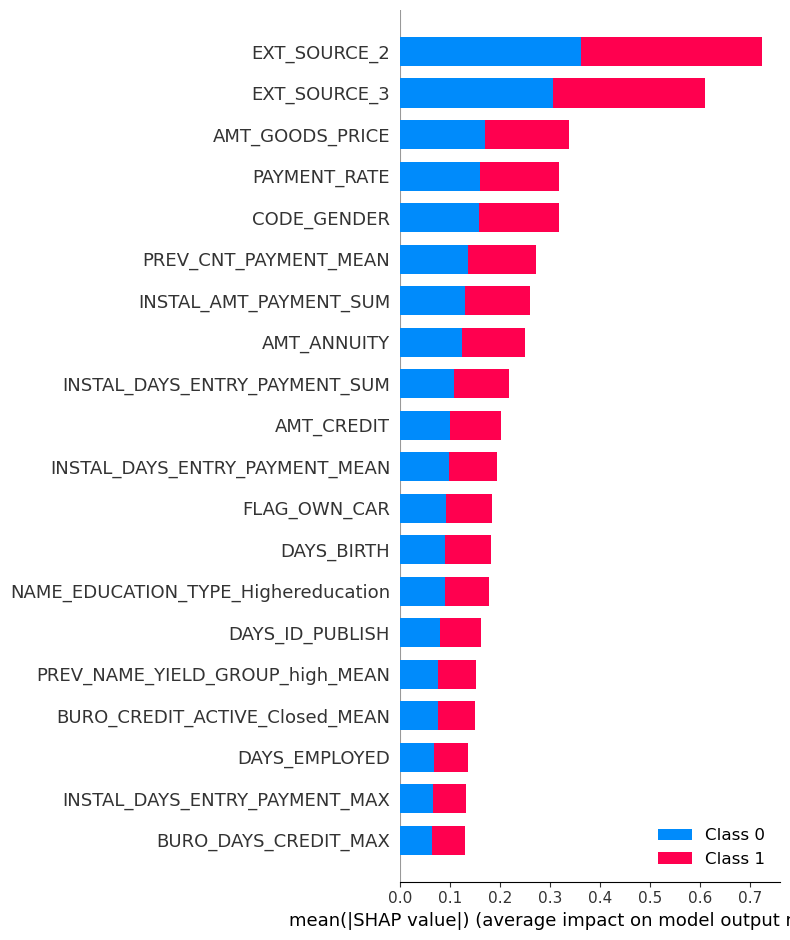

time: 531 ms (started: 2023-09-28 11:44:58 +00:00)


In [147]:
shap.summary_plot(shap_values, X_test.iloc[:10000,:])

Avec ce graphique, nous pouvons voir que nous retrouvons les EXT_SOURCES 1, 2 et 3 ainsi que CREDIT_REFUND_TIME. Un peu plus bas nous retrouvons DAYS_BIRTHS même si il semble jouer un rôle moins important pour le fait qu'une personne soit non solvable. Dans cette nouvelle représentation, le Genre du client est important dans la prédiction mais nous ne le prendrons pas en compte car cette information ferait de notre modèle un modèle discriminant. Nous trouvons également un rôle important pour la variable AMT_GOODS_PRICE qui correspond au montant du prix des biens pour lesquels le prêt est accordé pour les prêts de consommation qui ne sera pas pris en compte car le choix peut être biaisé et le crédit ne pourrait pas être accordé si le biens est trop cher.

Nous prendrons donc en comte les features EXT_SOURCES 1, 2, 3 ainsi que CREDIT_REFUND_TIME et l'âge.

Voyons plus en détail l'influence de chacune de ces variables sur la prédiction de non solvabilité.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


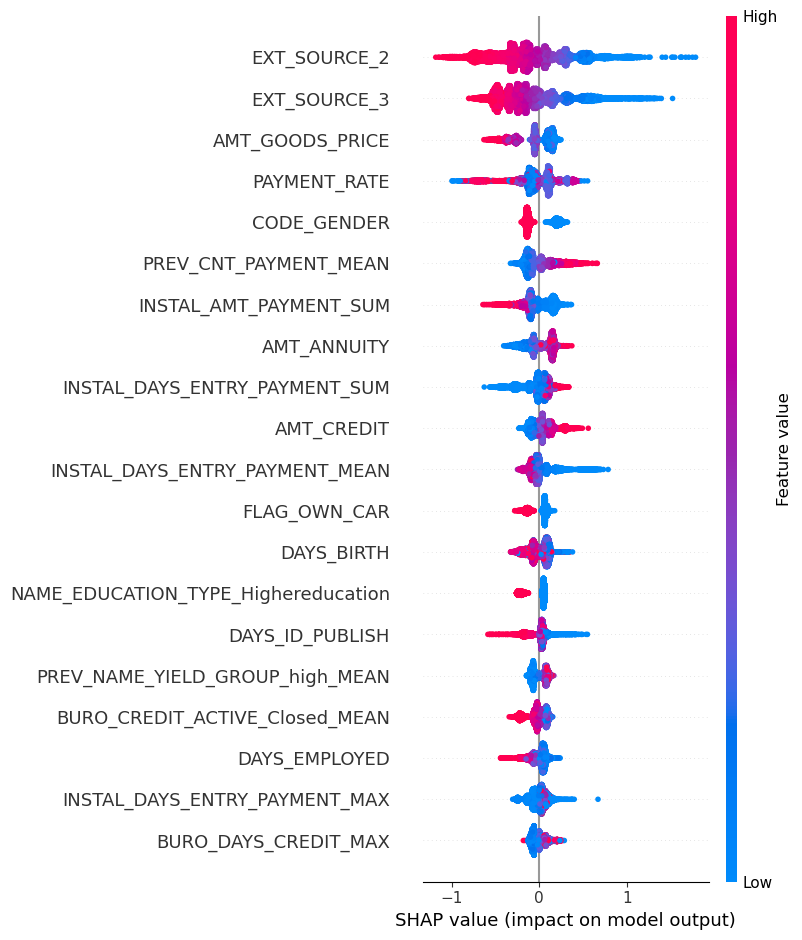

time: 2.44 s (started: 2023-09-28 11:45:18 +00:00)


In [148]:
shap.summary_plot(shap_values[1], X_test.astype("float").iloc[:10000,:])
#shap.summary_plot(shap_values[1], X_test.astype("float"))

Nous traçons les valeurs SHAP de chaque caractéristique pour chaque échantillon sur l'axe des x, puis nous les laissons s'accumuler. Si nous colorons ensuite chaque point selon sa valeur, nous pouvons voir comment une valeur faible ou élevée affecte la sortie du modèle. 

Pour EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1 on peut voir que de faibles valeurs augmentent de manière significative la sortie de probabilité du modèle et donc le fait d'être non solvable.

Au contraire, pour CREDIT_REFUND_TIME, plus le temps de remboursement des crédits est grand plus il a de chance que le prêt ne lui soit pas accordé.

In [ ]:

import lime.lime_tabular  

classifier_lime = lime.lime_tabular.LimeTabularExplainer(train_data_X.values,

                                             mode=’regression‘,

                                             training_labels=train_data_y,

                                             feature_names= data_dataset.feature_names,

                                                   categorical_features=[‘CHAS‘])

lime_results = classifier_lime.explain_instance(test_data_X.values[0], sklearn_regressor.predict)

 

lime_results.show_in_notebook()

In [68]:
def plot_vline(df, x_col, y_col, ax, color='k', line_at='max'):
    """draw a vertical line at max or min value of y on a plot"""
    row_idx=0
    if line_at == 'max':
        row_idx = df[y_col].argmax()
    elif line_at == 'min':
        row_idx = df[y_col].argmin()
    line_x = df.loc[row_idx, x_col]
    line_label = f'{line_at} at {x_col}={line_x:.3f}'
    ax.axvline(line_x, c=color, linestyle="--", label=line_label)
    ax.legend(frameon=True)


def discrimination_threshold(clf: BaseEstimator, x_test_, y_test_, score_func=score_gain,
                             label=None, color='b', ax=None):
    """
    calculate scores as function of threshold for discriminating class 0 and class 1 

    """
    scores = []
    thresholds = np.linspace(0, 1., 50, endpoint=False)

    # Probability of being in class TARGET==1
    y_pred_proba = clf.predict_proba(x_test_)[:, 1]
    for threshold in thresholds:
        # convert probability into class label, based on threshold
        y_pred = (y_pred_proba > threshold)*1
        scores.append(score_func(y_test_, y_pred, zero_division=0))
    if ax is None:
        _, ax = plt.subplots()
    if label is None:
        label = f'{score_func.__name__}'
    sns.lineplot(x=thresholds, y=scores, label=label, color=color, ax=ax)
    plot_vline(pd.DataFrame({'threshold': thresholds, 'score': scores}),
               'threshold', 'score', color=color, ax=ax)
    ax.set_xlabel("discrimination threshold")
    ax.set_ylabel("score")


_, ax = plt.subplots()


discrimination_threshold(model, x_test, y_test, ax=ax)
ax.set_ylabel("custom bank score")

plt.suptitle('LGBM - Calcul de seuil de probabilité optimal')
# plt.title(lgbm_best_model.get_params(), fontsize=8)
to_png()


NameError: name 'score_gain' is not defined

time: 63 ms (started: 2023-09-25 20:37:54 +00:00)


In [65]:
# Function to print Confusion Matrix and Classification Report
def model_perf(model, Y_test, Y_predict, algorithm, df_cm, df_perf, ax=None, plot = True):
    # confusion_matrix
    conf_mat = confusion_matrix(Y_test, Y_predict)
    
    # get accuracy of model
    acc_score = accuracy_score(Y_test, Y_predict)
    print(f"Accuracy of {algorithm} for Test data is {acc_score*100}\n")

    # get F1-score of model
    f1score = f1_score(Y_test, Y_predict) 
    print(f"F1-score of {algorithm} for Test data is {f1score*100}\n")
    
    # get the classification report
    class_report = classification_report(Y_test, Y_predict)
    print(f"Classification report for {algorithm} is: \n {class_report}")
    
    # AUC Calculations - false positive rates, true positive rates and thresholds
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_predict, pos_label=1)
    
    #area_under_curve
    roc_auc = round(metrics.auc(fpr, tpr)*100,2)
    print(f"AUC for {algorithm}: {roc_auc}\n")
    
    #Train Accuracy score
    train_acc = round(model.score(X_train,Y_train) * 100,2)

    #Test Accuracy score
    test_acc = round(model.score(X_test,Y_test) * 100,2)

    precision,recall,fscore,support = precision_recall_fscore_support(Y_test,Y_predict)

    #Appending into the dataframe
    df_perf = df_perf.append({'Model' : algorithm,'Train Accuracy' : train_acc,'Test Accuracy' : test_acc,
                          'F1-Score' : fscore[1],'Recall' : recall[1], 'Precision' : precision[1], 'AUC' : roc_auc}, ignore_index=True)

    df_cm = df_cm.append({"Model" : algorithm, "True Positives" : conf_mat[1][1], "True Negatives" : conf_mat[0][0],
                      "False Positives" : conf_mat[0][1], "False Negatives" : conf_mat[1][0]}, ignore_index=True, sort=False)

##########################################--PLOT---###########################################
    if plot:
        def conf_plot1(ax = None):
            if ax is None:
                fig, ax = plt.subplots()
            # For label annotations in confusion_matrix
            label_names = ['True -ve','False +ve','False -ve','True +ve']
            label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
            labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
            labels = np.asarray(labels).reshape(2,2)

            # Draw heatmap using confusion matrix
            sns.heatmap(conf_mat, cmap = cmap, annot=labels, fmt='')
            ax.set_xlabel('Actual Values')
            ax.set_ylabel('Predicted Values')
            #ax.show()

        #Line plot for ROC curve using fpr and tpr value
        def roc_plot2(ax = None):
            if ax is None:
                fig, ax = plt.subplots()
            ax.plot(fpr, tpr, color='red', label = 'AUC = %0.3f' % roc_auc)  
            ax.set_title('Receiver Operating Characteristic (ROC)')    
            ax.legend(loc = 'lower right')
            ax.plot([0, 1], [0, 1],linestyle='--') #Intersection line
            ax.set_xlabel('False Negative Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_xlim([0,1])
            ax.set_ylim([0,1])
            ax.set_xticks([i for i in np.arange(0,1.1,0.1)])
            ax.set_yticks([i for i in np.arange(0,1.1,0.1)])
        
        prec, rec, thres = precision_recall_curve(Y_test, Y_predict)
        prec, rec, thres = list(prec), list(rec), list(thres)
        prec.pop()
        rec.pop()
            
        def rec_plot3(ax = None):
            if ax is None:
                fig, ax = plt.subplots()
            #Plot Precision-Recall curve
            fig, axis = (None, ax) if ax else plt.subplots()
            axis_twin = axis.twinx()

            #Threshold vs Precision
            sns.lineplot(x = thres, y = prec, label='Precision', ax=axis)
            axis.set_xlabel('Threshold')
            axis.set_ylabel('Precision')
            axis.legend(loc='lower left')

            #Threshold vs Recall
            sns.lineplot(x = thres, y = rec, color='limegreen', label='Recall', ax=axis_twin)
            axis_twin.set_ylabel('Recall')
            axis_twin.set_ylim(0, 1)
            axis_twin.legend(bbox_to_anchor=(0.32, 0.20),loc='lower right')

            axis.set_xlim(0, 1)
            axis.set_ylim(0, 1)
            axis.set_title('Precision Vs Recall')
        
                    
        fig = plt.figure(figsize = (15,4))
        ax1 = fig.add_subplot(1,3,1)
        conf_plot1(ax1)
        ax2 = fig.add_subplot(1,3,2)
        roc_plot2(ax2)
        axis = fig.add_subplot(1,3,3)
        rec_plot3(axis)
    
    
    return df_cm, df_perf

#  Draw Model Performace, Confusion Matrix and Classification Report for KNN
df_cm, df_perf = model_perf(KNN_class, Y_test, Y_predict, "KNN", df_cm, df_perf, plot = True)

knn_score = cross_val_score(KNeighborsClassifier(), X_train, Y_train, cv= 3,verbose = True, scoring = 'accuracy')
print("Accuracy for K-Neighbors Classifier using Cross Validation: %0.3f (+/- %0.3f)" 
      % (knn_score.mean(), knn_score.std() * 2))

df_cv = df_cv.append({'Model':'KNeighborsClassifier','Best_Cross_Val_Score':"%0.2f (+/- %0.2f)" 
                      % ((knn_score.mean(), knn_score.std() * 2))},ignore_index=True, sort=False)


# Cumul des résultats des différents modèles

result = pd.concat([df_perf.round(2), df_cv['Best_Cross_Val_Score'], df_cm.drop('Model', axis=1)], 
                   axis=1, sort=False)
result

NameError: name 'KNN_class' is not defined

In [4]:
# %run app.py
import os
import pandas as pd
os.getcwd()

'C:\\Users\\Fane0763\\OpenClassroom\\OC Projet 7'

In [5]:
df11=pd.read_csv('C:/Users/Fane0763/OpenClassroom/OC Projet 7/bases/application_test.csv')

In [16]:
df11.dtypes
import os
os.chdir('C:/Users/Fane0763/OpenClassroom/OC Projet 7/out_put')
df_id=pd.read_csv('C:/Users/Fane0763/OpenClassroom/OC Projet 7/bases/application_test.csv')
df_id=df_id[['SK_ID_CURR']]

data = pd.read_csv('test_df.csv') # train_df.csv pd.read_csv('C:/Users/Fane0763/OpenClassroom/OC Projet 7/bases/application_test.csv')
data = pd.concat([df_id, data], axis=1)

data_train = pd.read_csv('train_df.csv') # train_df.csv
listvar    = data_train.drop(columns='TARGET').columns.tolist()

# Sélection des colonnes numériques pour la mise à l'échelle
data_scaled = data[['SK_ID_CURR']+listvar].copy()
cols        = data_scaled.select_dtypes(['float64']).columns
data_scaled[cols] = StandardScaler().fit_transform(data_scaled[cols])

data_train_scaled = data_train.copy()
data_train_scaled[cols] = StandardScaler().fit_transform(data_train[cols])

In [14]:
df11.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [17]:
data.head()

SK_ID_CURR  EXT_SOURCE_3  EXT_SOURCE_2  PREV_APP_CREDIT_PERC_MEAN  \
0      100001      0.159520      0.789654                   1.044079   
1      100005      0.432962      0.291656                   1.111173   
2      100013      0.610991      0.699787                   0.956503   
3      100028      0.612704      0.509677                   0.777028   
4      100038      0.502739      0.425687                   0.884003   

   INSTAL_DAYS_ENTRY_PAYMENT_MEAN  DAYS_EMPLOYED_PERC  CODE_GENDER  \
0                     2195.000000            0.121044            1   
1                      609.555556            0.247398            0   
2                     1358.109677            0.222477            0   
3                      858.548673            0.133515            1   
4                      634.250000            0.168021            0   

   APPROVED_DAYS_DECISION_MIN  APPROVED_AMT_ANNUITY_MEAN  AMT_GOODS_PRICE  \
0                      1740.0                   3951.000         450000.0   
1                       757.0                   4813.200         180000.0   
2                      1999.0                  11478.195         630000.0   
3                      1805.0                   8091.585        1575000.0   
4                       821.0                  11100.600         625500.0   

   ...  ANNUITY_INCOME_PERC  AMT_ANNUITY  REG_REGION_NOT_LIVE_REGION  \
0  ...             0.152300      20560.5                           0   
1  ...             0.175455      17370.0                           0   
2  ...             0.344578      69777.0                           0   
3  ...             0.155614      49018.5                           0   
4  ...             0.178150      32067.0                           0   

   REG_CITY_NOT_WORK_CITY  REGION_RATING_CLIENT  \
0                       0                     2   
1                       0                     2   
2                       0                     2   
3                       0                     2   
4                       1                     2   

   PREV_PRODUCT_COMBINATION_CardStreet_MEAN  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   PREV_NAME_YIELD_GROUP_low_normal_MEAN  PREV_NAME_TYPE_SUITE_nan_MEAN  \
0                                    0.0                            0.0   
1                                    0.0                            1.0   
2                                    0.0                            0.5   
3                                    0.0                            0.8   
4                                    0.0                            0.5   

   PREV_NAME_PORTFOLIO_POS_MEAN  PREV_NAME_PORTFOLIO_Cards_MEAN  
0                           1.0                             0.0  
1                           0.5                             0.0  
2                           0.5                             0.0  
3                           0.4                             0.2  
4                           0.5                             0.0  

[5 rows x 101 columns]